# IF702 Redes Neurais
Projeto de redes neurais utilizando Base de Dados do Tipo 2, Detecção de Células de Câncer em Mamografias

In [45]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import optimizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, accuracy_score

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

## Leitura e Limpeza dos Dados

Para a leitura da base de dados foi feita utilizando a biblioteca pandas.

In [46]:
data_set = pd.read_csv('mammography.csv')

data_set.columns = ['X1','X2','X3','X4','X5','X6','CLASS'] # renomeando as colunas para ficar CLASS em vez de class

### Removendo exemplos repetidos

In [47]:
columns = data_set.columns.tolist()[:-1] # remove a coluna da classe da lista de colunas
# print (columns)
data_set.drop_duplicates(subset=columns, # seleciona apenas as 6 primeiras colunas para verificar duplicatas
                         keep=False, # remove todos os exemplos repetidos
                         inplace=True)  # Remove exemplos repetidos
print (len(data_set))

7845


### Renomeando a classe -1 para 0

In [48]:
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 0 if (x == -1) else 1)
# print (data_set)

Estatisticas da base de dados

In [49]:
# Estatísticas sobre as variáveis
data_set.describe()

,X1,X2,X3,X4,X5,X6,CLASS
count,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000
mean,0.333764,0.200042,0.251736,0.365734,0.160780,0.402400,0.032250
std,1.025813,1.136427,1.101461,0.988616,1.157123,0.939678,0.176674
min,-0.784415,-0.452501,-0.591631,-0.859553,-0.377866,-0.945723,0.000000
25%,-0.145333,-0.408265,-0.276061,-0.859553,-0.377866,-0.945723,0.000000
50%,0.111790,-0.271133,-0.005571,0.550163,-0.377866,0.845975,0.000000
75%,0.508993,0.219887,0.400163,1.027382,0.387549,1.132403,0.000000
max,31.508443,5.085849,29.477769,9.591164,23.617122,1.949027,1.000000


### Separando as classes da base de dados

Criando função para separando a base de dados pelas classes, para assim poder garantir que vai ter exemplos de cada classe em todos os conjuntos

In [50]:
def separar_classes(data):
    zero = data[data.CLASS == 0]
    um = data[data.CLASS == 1]
    
    return [zero, um]

# print (len(separar_grupos(data_set)[0]))

### Divisão dos Dados em Treino, Validação, e Teste

In [51]:
def separar_grupos_tvt(data): 
    """
    Divisão da base de dados
    Treinamento = 50%
    Validação = 25%
    Teste = 25%
    """
    
    # classe zero
    zero_train, zero_validation = train_test_split(data[0], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    zero_validation, zero_teste = train_test_split(zero_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    #classe um
    um_train, um_validation = train_test_split(data[1], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    um_validation, um_teste = train_test_split(um_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    return [(zero_train, zero_validation, zero_teste),(um_train, um_validation, um_teste)]

### Oversampling dos dados

Replicando os dados da classe minoritaria para ter a mesma quantidade de exemplos das duas classes na MLP.

In [52]:
def oversampling_replacement(data):
    um_train = data[1][0]
    um_validation = data[1][1]
    um_train = np.resize(um_train, data[0][0].shape)
    um_validation = np.resize(um_validation, data[0][1].shape)
    
    return [data[0],(um_train, um_validation, data[1][2])]

def oversampling_SMOTE(data):
    '''Faz o oversampling usando o algoritmo SMOTE
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    sm = SMOTE(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = sm.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = sm.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

def random_undersampling(data):
    '''Faz o undersampling randomicamente
    
    Parametros:
        data (array-like): Array das amostras, com as amostras de treinamento no 1o indice, de validacao no 2o e teste no 3o
    
    Returns:
        array-like: Array das amostras, apos o oversampling
    '''
    randomunder = RandomUnderSampler(random_state=42)
    
    train_features = data[0][:, :-1]
    train_labels = data[0][:, -1]
    features, labels = randomunder.fit_sample(train_features, train_labels)
    train = np.zeros((len(labels), 7))
    for i in range(len(train)):
        train[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    # Sem isso, os 0s tenderiam a ficar acima dos 1s
    np.random.shuffle(train)
    
    validation_features = data[1][:, :-1]
    validation_labels = data[1][:, -1]
    features, labels = randomunder.fit_sample(validation_features, validation_labels)
    validation = np.zeros((len(labels), 7))
    for i in range(len(validation)):
        validation[i] = np.concatenate((features[i], np.array([labels[i]])), axis=0)
    np.random.shuffle(validation)
    
    return [train, validation, data[2]]

### Juntando as classes

Juntando as classes zero e um dos conjuntos de treinamento, validação e teste

In [53]:
def join_class(data):
    train = np.concatenate((data[0][0], data[1][0]), axis=0)
    validation = np.concatenate((data[0][1], data[1][1]), axis=0)
    test = np.concatenate((data[0][2], data[1][2]), axis=0)

    np.random.shuffle(train)
    np.random.shuffle(validation)
    np.random.shuffle(test)
    
    return [train, validation, test]

In [54]:
sep = separar_classes(data_set)
print (len(sep[0]), len(sep[1]))
grupos = separar_grupos_tvt(sep)
print (len(grupos[0][0]), len(grupos[0][1]), len(grupos[0][2]), 
       len(grupos[1][0]), len(grupos[1][1]), len(grupos[1][2]))
join_c = join_class(grupos)
over = random_undersampling(join_c)
print (len(over[0]), len(over[1]), len(over[2]))

7592 253
3796 1898 1898 126 63 64
252 126 1962


### Separando entrada de saida

In [55]:
X_train = over[0][:,:-1]
y_train = over[0][:,-1]

X_validation = over[1][:,:-1]
y_validation = over[1][:,-1]

X_test = over[2][:,:-1]
y_test = over[2][:,-1]

# utilizado para verificar a quantidade de exemplos de cada classe que tem nos conjuntos de validação, teste e treinamento
import collections
print (collections.Counter(y_train))
print (collections.Counter(y_validation))
print (collections.Counter(y_test))

Counter({1.0: 126, 0.0: 126})
Counter({1.0: 63, 0.0: 63})
Counter({0.0: 1898, 1.0: 64})


### Normalização dos dados

In [56]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

## Definição e Treino da Rede

Algumas funções auxiliares e constantes.

In [57]:
#Taxa de aprendizagem, e usada a mesma em todo o codigo
learnRate = 0.001

In [58]:
def extract_final_losses(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history, name):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves: ' + str(name), xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()
    
def plot_training_acc_curves(history, name):
    train_loss = history.history['acc']
    val_loss = history.history['val_acc']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Accuracy Curves: '+ str(name), xlabel='Epochs', ylabel='Accuracy')
    ax.legend()
    plt.show()
    

## RNA 1 (3)

In [59]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(3, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu'))

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.4836 - acc: 0.5000 - val_loss: 0.4810 - val_acc: 0.5000
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.4777 - acc: 0.5000 - val_loss: 0.4748 - val_acc: 0.5000
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.4710 - acc: 0.5000 - val_loss: 0.4682 - val_acc: 0.5000
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.4634 - acc: 0.5000 - val_loss: 0.4601 - val_acc: 0.5000
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.4544 - acc: 0.5000 - val_loss: 0.4511 - val_acc: 0.5000
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.4450 - acc: 0.5000 - val_loss: 0.4406 - val_acc: 0.5000
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.4352 - acc: 0.5000 - val_loss: 0.4294 - val_acc: 0.5000
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.4247 - acc

252/252 [==============================] - 0s - loss: 0.1250 - acc: 0.8413 - val_loss: 0.1318 - val_acc: 0.8571
Epoch 66/2000
252/252 [==============================] - 0s - loss: 0.1222 - acc: 0.8492 - val_loss: 0.1298 - val_acc: 0.8492
Epoch 67/2000
252/252 [==============================] - ETA: 0s - loss: 0.0776 - acc: 0.906 - 0s - loss: 0.1196 - acc: 0.8532 - val_loss: 0.1284 - val_acc: 0.8492
Epoch 68/2000
252/252 [==============================] - 0s - loss: 0.1175 - acc: 0.8532 - val_loss: 0.1272 - val_acc: 0.8492
Epoch 69/2000
252/252 [==============================] - 0s - loss: 0.1159 - acc: 0.8571 - val_loss: 0.1264 - val_acc: 0.8571
Epoch 70/2000
252/252 [==============================] - 0s - loss: 0.1147 - acc: 0.8532 - val_loss: 0.1256 - val_acc: 0.8571
Epoch 71/2000
252/252 [==============================] - 0s - loss: 0.1135 - acc: 0.8611 - val_loss: 0.1248 - val_acc: 0.8571
Epoch 72/2000
252/252 [==============================] - 0s - loss: 0.1125 - acc: 0.8611 - val

252/252 [==============================] - 0s - loss: 0.0882 - acc: 0.8770 - val_loss: 0.1041 - val_acc: 0.8810
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.0879 - acc: 0.8770 - val_loss: 0.1041 - val_acc: 0.8810
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.0877 - acc: 0.8810 - val_loss: 0.1040 - val_acc: 0.8810
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.0876 - acc: 0.8849 - val_loss: 0.1041 - val_acc: 0.8810
Epoch 133/2000
252/252 [==============================] - ETA: 0s - loss: 0.0877 - acc: 0.875 - 0s - loss: 0.0875 - acc: 0.8849 - val_loss: 0.1039 - val_acc: 0.8810
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.0872 - acc: 0.8849 - val_loss: 0.1039 - val_acc: 0.8810
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.0871 - acc: 0.8810 - val_loss: 0.1036 - val_acc: 0.8889
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.0869 - acc: 0.881

252/252 [==============================] - 0s - loss: 0.0799 - acc: 0.9048 - val_loss: 0.1037 - val_acc: 0.8968
Epoch 194/2000
252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.9048 - val_loss: 0.1040 - val_acc: 0.8968
Epoch 195/2000
252/252 [==============================] - 0s - loss: 0.0798 - acc: 0.9048 - val_loss: 0.1038 - val_acc: 0.8968
Epoch 196/2000
252/252 [==============================] - 0s - loss: 0.0797 - acc: 0.9048 - val_loss: 0.1037 - val_acc: 0.8968
Epoch 197/2000
252/252 [==============================] - 0s - loss: 0.0797 - acc: 0.9048 - val_loss: 0.1038 - val_acc: 0.8968
Epoch 198/2000
252/252 [==============================] - 0s - loss: 0.0797 - acc: 0.9048 - val_loss: 0.1039 - val_acc: 0.8968
Epoch 199/2000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9048 - val_loss: 0.1039 - val_acc: 0.8968
Epoch 200/2000
252/252 [==============================] - 0s - loss: 0.0796 - acc: 0.9048 - val_loss: 0.1039 - val_acc: 0.8968

252/252 [==============================] - 0s - loss: 0.0774 - acc: 0.9048 - val_loss: 0.1059 - val_acc: 0.9048
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0774 - acc: 0.9048 - val_loss: 0.1058 - val_acc: 0.9048
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0774 - acc: 0.9048 - val_loss: 0.1058 - val_acc: 0.9048
Epoch 260/2000
252/252 [==============================] - ETA: 0s - loss: 0.0692 - acc: 0.937 - 0s - loss: 0.0774 - acc: 0.9048 - val_loss: 0.1057 - val_acc: 0.9048
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.9048 - val_loss: 0.1059 - val_acc: 0.9048
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.9048 - val_loss: 0.1061 - val_acc: 0.9048
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0773 - acc: 0.9048 - val_loss: 0.1062 - val_acc: 0.9048
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0772 - acc: 0.904

252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9048 - val_loss: 0.1053 - val_acc: 0.9048
Epoch 322/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9048 - val_loss: 0.1052 - val_acc: 0.9048
Epoch 323/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9048 - val_loss: 0.1052 - val_acc: 0.9048
Epoch 324/2000
252/252 [==============================] - 0s - loss: 0.0759 - acc: 0.9048 - val_loss: 0.1053 - val_acc: 0.9048
Epoch 325/2000
252/252 [==============================] - ETA: 0s - loss: 0.0676 - acc: 0.937 - 0s - loss: 0.0758 - acc: 0.9048 - val_loss: 0.1051 - val_acc: 0.9048
Epoch 326/2000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9048 - val_loss: 0.1050 - val_acc: 0.9048
Epoch 327/2000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.9048 - val_loss: 0.1053 - val_acc: 0.9048
Epoch 328/2000
252/252 [==============================] - 0s - loss: 0.0758 - acc: 0.904

252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9087 - val_loss: 0.1045 - val_acc: 0.9048
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9087 - val_loss: 0.1045 - val_acc: 0.9048
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9087 - val_loss: 0.1044 - val_acc: 0.9048
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9087 - val_loss: 0.1044 - val_acc: 0.9048
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9087 - val_loss: 0.1043 - val_acc: 0.9048
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9087 - val_loss: 0.1044 - val_acc: 0.9048
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9087 - val_loss: 0.1046 - val_acc: 0.9048
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9087 - val_loss: 0.1044 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9127 - val_loss: 0.1036 - val_acc: 0.9048
Epoch 450/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9127 - val_loss: 0.1036 - val_acc: 0.9048
Epoch 451/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9127 - val_loss: 0.1039 - val_acc: 0.9048
Epoch 452/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9127 - val_loss: 0.1042 - val_acc: 0.9048
Epoch 453/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9127 - val_loss: 0.1038 - val_acc: 0.9048
Epoch 454/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.9127 - val_loss: 0.1038 - val_acc: 0.9048
Epoch 455/2000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9127 - val_loss: 0.1034 - val_acc: 0.9048
Epoch 456/2000
252/252 [==============================] - 0s - loss: 0.0740 - acc: 0.9127 - val_loss: 0.1036 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9127 - val_loss: 0.1036 - val_acc: 0.9048
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9127 - val_loss: 0.1036 - val_acc: 0.9048
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9127 - val_loss: 0.1036 - val_acc: 0.9048
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9127 - val_loss: 0.1036 - val_acc: 0.9048
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9127 - val_loss: 0.1035 - val_acc: 0.9048
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9127 - val_loss: 0.1039 - val_acc: 0.9048
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0735 - acc: 0.9127 - val_loss: 0.1039 - val_acc: 0.9048
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0734 - acc: 0.9127 - val_loss: 0.1039 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0730 - acc: 0.9127 - val_loss: 0.1032 - val_acc: 0.8968
Epoch 578/2000
252/252 [==============================] - 0s - loss: 0.0728 - acc: 0.9127 - val_loss: 0.1031 - val_acc: 0.8968
Epoch 579/2000
252/252 [==============================] - 0s - loss: 0.0730 - acc: 0.9127 - val_loss: 0.1034 - val_acc: 0.8968
Epoch 580/2000
252/252 [==============================] - 0s - loss: 0.0728 - acc: 0.9127 - val_loss: 0.1030 - val_acc: 0.8968
Epoch 581/2000
252/252 [==============================] - 0s - loss: 0.0729 - acc: 0.9127 - val_loss: 0.1028 - val_acc: 0.8968
Epoch 582/2000
252/252 [==============================] - 0s - loss: 0.0729 - acc: 0.9127 - val_loss: 0.1030 - val_acc: 0.8968
Epoch 583/2000
252/252 [==============================] - 0s - loss: 0.0728 - acc: 0.9127 - val_loss: 0.1029 - val_acc: 0.8968
Epoch 584/2000
252/252 [==============================] - 0s - loss: 0.0729 - acc: 0.9127 - val_loss: 0.1029 - val_acc: 0.8968

252/252 [==============================] - 0s - loss: 0.0724 - acc: 0.9127 - val_loss: 0.1017 - val_acc: 0.8968
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0725 - acc: 0.9127 - val_loss: 0.1019 - val_acc: 0.8968
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0725 - acc: 0.9127 - val_loss: 0.1017 - val_acc: 0.8968
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0724 - acc: 0.9127 - val_loss: 0.1018 - val_acc: 0.8968
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0724 - acc: 0.9127 - val_loss: 0.1017 - val_acc: 0.8968
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0724 - acc: 0.9127 - val_loss: 0.1018 - val_acc: 0.8968
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0724 - acc: 0.9127 - val_loss: 0.1016 - val_acc: 0.8968
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0724 - acc: 0.9127 - val_loss: 0.1017 - val_acc: 0.8968

252/252 [==============================] - 0s - loss: 0.0721 - acc: 0.9087 - val_loss: 0.1011 - val_acc: 0.8968
Epoch 706/2000
252/252 [==============================] - 0s - loss: 0.0721 - acc: 0.9087 - val_loss: 0.1014 - val_acc: 0.8968
Epoch 707/2000
252/252 [==============================] - 0s - loss: 0.0721 - acc: 0.9087 - val_loss: 0.1013 - val_acc: 0.8968
Epoch 708/2000
252/252 [==============================] - 0s - loss: 0.0720 - acc: 0.9087 - val_loss: 0.1014 - val_acc: 0.8968
Epoch 709/2000
252/252 [==============================] - 0s - loss: 0.0720 - acc: 0.9087 - val_loss: 0.1021 - val_acc: 0.8968
Epoch 710/2000
252/252 [==============================] - 0s - loss: 0.0720 - acc: 0.9087 - val_loss: 0.1020 - val_acc: 0.8968
Epoch 711/2000
252/252 [==============================] - 0s - loss: 0.0720 - acc: 0.9087 - val_loss: 0.1019 - val_acc: 0.8968
Epoch 712/2000
252/252 [==============================] - 0s - loss: 0.0719 - acc: 0.9087 - val_loss: 0.1021 - val_acc: 0.8968

252/252 [==============================] - 0s - loss: 0.0712 - acc: 0.9127 - val_loss: 0.1024 - val_acc: 0.8968
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0712 - acc: 0.9127 - val_loss: 0.1024 - val_acc: 0.8968
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0711 - acc: 0.9127 - val_loss: 0.1025 - val_acc: 0.8968
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0712 - acc: 0.9127 - val_loss: 0.1024 - val_acc: 0.8968
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0711 - acc: 0.9127 - val_loss: 0.1023 - val_acc: 0.8968
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0711 - acc: 0.9127 - val_loss: 0.1024 - val_acc: 0.8968
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0711 - acc: 0.9127 - val_loss: 0.1025 - val_acc: 0.8968
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0711 - acc: 0.9127 - val_loss: 0.1027 - val_acc: 0.8968

252/252 [==============================] - 0s - loss: 0.0706 - acc: 0.9127 - val_loss: 0.1016 - val_acc: 0.9048
Epoch 834/2000
252/252 [==============================] - 0s - loss: 0.0707 - acc: 0.9127 - val_loss: 0.1015 - val_acc: 0.9048
Epoch 835/2000
252/252 [==============================] - 0s - loss: 0.0706 - acc: 0.9127 - val_loss: 0.1015 - val_acc: 0.9048
Epoch 836/2000
252/252 [==============================] - 0s - loss: 0.0707 - acc: 0.9127 - val_loss: 0.1019 - val_acc: 0.9048
Epoch 837/2000
252/252 [==============================] - 0s - loss: 0.0706 - acc: 0.9127 - val_loss: 0.1019 - val_acc: 0.9048
Epoch 838/2000
252/252 [==============================] - 0s - loss: 0.0706 - acc: 0.9127 - val_loss: 0.1018 - val_acc: 0.9048
Epoch 839/2000
252/252 [==============================] - 0s - loss: 0.0707 - acc: 0.9127 - val_loss: 0.1019 - val_acc: 0.9048
Epoch 840/2000
252/252 [==============================] - 0s - loss: 0.0706 - acc: 0.9127 - val_loss: 0.1017 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0703 - acc: 0.9127 - val_loss: 0.1011 - val_acc: 0.9048
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0703 - acc: 0.9127 - val_loss: 0.1009 - val_acc: 0.9048
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0703 - acc: 0.9127 - val_loss: 0.1011 - val_acc: 0.9048
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0703 - acc: 0.9127 - val_loss: 0.1009 - val_acc: 0.9048
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0702 - acc: 0.9127 - val_loss: 0.1008 - val_acc: 0.9048
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0702 - acc: 0.9127 - val_loss: 0.1010 - val_acc: 0.9048
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0702 - acc: 0.9127 - val_loss: 0.1013 - val_acc: 0.9048
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0702 - acc: 0.9127 - val_loss: 0.1012 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0700 - acc: 0.9127 - val_loss: 0.1005 - val_acc: 0.9048
Epoch 962/2000
252/252 [==============================] - 0s - loss: 0.0700 - acc: 0.9127 - val_loss: 0.1003 - val_acc: 0.9048
Epoch 963/2000
252/252 [==============================] - 0s - loss: 0.0700 - acc: 0.9127 - val_loss: 0.1007 - val_acc: 0.9048
Epoch 964/2000
252/252 [==============================] - 0s - loss: 0.0700 - acc: 0.9127 - val_loss: 0.1005 - val_acc: 0.9048
Epoch 965/2000
252/252 [==============================] - 0s - loss: 0.0700 - acc: 0.9127 - val_loss: 0.1003 - val_acc: 0.9048
Epoch 966/2000
252/252 [==============================] - 0s - loss: 0.0700 - acc: 0.9127 - val_loss: 0.1006 - val_acc: 0.9048
Epoch 967/2000
252/252 [==============================] - 0s - loss: 0.0700 - acc: 0.9167 - val_loss: 0.1005 - val_acc: 0.9048
Epoch 968/2000
252/252 [==============================] - 0s - loss: 0.0699 - acc: 0.9167 - val_loss: 0.1004 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0698 - acc: 0.9167 - val_loss: 0.0997 - val_acc: 0.9048
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0698 - acc: 0.9167 - val_loss: 0.1000 - val_acc: 0.9048
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0698 - acc: 0.9167 - val_loss: 0.1001 - val_acc: 0.9048
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0698 - acc: 0.9167 - val_loss: 0.1002 - val_acc: 0.9048
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0698 - acc: 0.9167 - val_loss: 0.1000 - val_acc: 0.9048
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0698 - acc: 0.9167 - val_loss: 0.0999 - val_acc: 0.9048
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0698 - acc: 0.9167 - val_loss: 0.0998 - val_acc: 0.9048
Epoch 1032/2000
252/252 [==============================] - 0s - loss: 0.0698 - acc: 0.9167 - val_loss: 0.0999 - val_acc:

252/252 [==============================] - 0s - loss: 0.0697 - acc: 0.9167 - val_loss: 0.1000 - val_acc: 0.9048
Epoch 1090/2000
252/252 [==============================] - 0s - loss: 0.0697 - acc: 0.9167 - val_loss: 0.0997 - val_acc: 0.9048
Epoch 1091/2000
252/252 [==============================] - 0s - loss: 0.0697 - acc: 0.9167 - val_loss: 0.1000 - val_acc: 0.9048
Epoch 1092/2000
252/252 [==============================] - 0s - loss: 0.0697 - acc: 0.9167 - val_loss: 0.0999 - val_acc: 0.9048
Epoch 1093/2000
252/252 [==============================] - 0s - loss: 0.0696 - acc: 0.9167 - val_loss: 0.1000 - val_acc: 0.9048
Epoch 1094/2000
252/252 [==============================] - 0s - loss: 0.0697 - acc: 0.9167 - val_loss: 0.1000 - val_acc: 0.9048
Epoch 1095/2000
252/252 [==============================] - 0s - loss: 0.0697 - acc: 0.9167 - val_loss: 0.1002 - val_acc: 0.9048
Epoch 1096/2000
252/252 [==============================] - 0s - loss: 0.0697 - acc: 0.9167 - val_loss: 0.0999 - val_acc:

252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.9167 - val_loss: 0.0997 - val_acc: 0.9048
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0696 - acc: 0.9167 - val_loss: 0.0997 - val_acc: 0.9048
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0696 - acc: 0.9167 - val_loss: 0.0996 - val_acc: 0.9048
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.9167 - val_loss: 0.0999 - val_acc: 0.9048
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.9167 - val_loss: 0.0997 - val_acc: 0.9048
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0696 - acc: 0.9206 - val_loss: 0.0996 - val_acc: 0.9048
Epoch 1159/2000
252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.9167 - val_loss: 0.0998 - val_acc: 0.9048
Epoch 1160/2000
252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.9167 - val_loss: 0.0997 - val_acc:

252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9206 - val_loss: 0.0994 - val_acc: 0.9048
Epoch 1218/2000
252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.9206 - val_loss: 0.0993 - val_acc: 0.9048
Epoch 1219/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9167 - val_loss: 0.0994 - val_acc: 0.9048
Epoch 1220/2000
252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.9167 - val_loss: 0.0999 - val_acc: 0.9048
Epoch 1221/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9167 - val_loss: 0.0997 - val_acc: 0.9048
Epoch 1222/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9167 - val_loss: 0.0996 - val_acc: 0.9048
Epoch 1223/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9206 - val_loss: 0.0997 - val_acc: 0.9048
Epoch 1224/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9167 - val_loss: 0.0998 - val_acc:

252/252 [==============================] - 0s - loss: 0.0693 - acc: 0.9206 - val_loss: 0.0990 - val_acc: 0.9048
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0695 - acc: 0.9206 - val_loss: 0.0991 - val_acc: 0.9048
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9206 - val_loss: 0.0989 - val_acc: 0.9048
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9206 - val_loss: 0.0993 - val_acc: 0.9048
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9167 - val_loss: 0.0993 - val_acc: 0.9048
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9167 - val_loss: 0.0991 - val_acc: 0.9048
Epoch 1287/2000
252/252 [==============================] - 0s - loss: 0.0693 - acc: 0.9167 - val_loss: 0.0991 - val_acc: 0.9048
Epoch 1288/2000
252/252 [==============================] - 0s - loss: 0.0694 - acc: 0.9167 - val_loss: 0.0990 - val_acc:

252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9206 - val_loss: 0.0976 - val_acc: 0.9048
Epoch 1346/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9206 - val_loss: 0.0975 - val_acc: 0.9048
Epoch 1347/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9206 - val_loss: 0.0973 - val_acc: 0.9048
Epoch 1348/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9206 - val_loss: 0.0973 - val_acc: 0.9048
Epoch 1349/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9206 - val_loss: 0.0974 - val_acc: 0.9048
Epoch 1350/2000
252/252 [==============================] - 0s - loss: 0.0691 - acc: 0.9206 - val_loss: 0.0972 - val_acc: 0.9048
Epoch 1351/2000
252/252 [==============================] - 0s - loss: 0.0690 - acc: 0.9206 - val_loss: 0.0975 - val_acc: 0.9048
Epoch 1352/2000
252/252 [==============================] - 0s - loss: 0.0692 - acc: 0.9206 - val_loss: 0.0973 - val_acc:

252/252 [==============================] - 0s - loss: 0.0690 - acc: 0.9206 - val_loss: 0.0968 - val_acc: 0.9048
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9206 - val_loss: 0.0967 - val_acc: 0.9048
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0690 - acc: 0.9206 - val_loss: 0.0970 - val_acc: 0.9048
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9206 - val_loss: 0.0970 - val_acc: 0.9048
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9206 - val_loss: 0.0969 - val_acc: 0.9048
Epoch 1414/2000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9206 - val_loss: 0.0967 - val_acc: 0.9048
Epoch 1415/2000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9206 - val_loss: 0.0965 - val_acc: 0.9048
Epoch 1416/2000
252/252 [==============================] - 0s - loss: 0.0690 - acc: 0.9206 - val_loss: 0.0967 - val_acc:

252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9206 - val_loss: 0.0963 - val_acc: 0.9048
Epoch 1474/2000
252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9206 - val_loss: 0.0966 - val_acc: 0.9048
Epoch 1475/2000
252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9206 - val_loss: 0.0964 - val_acc: 0.9048
Epoch 1476/2000
252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9206 - val_loss: 0.0965 - val_acc: 0.9048
Epoch 1477/2000
252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9206 - val_loss: 0.0965 - val_acc: 0.9048
Epoch 1478/2000
252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9206 - val_loss: 0.0966 - val_acc: 0.9048
Epoch 1479/2000
252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9206 - val_loss: 0.0965 - val_acc: 0.9048
Epoch 1480/2000
252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9206 - val_loss: 0.0963 - val_acc:

252/252 [==============================] - 0s - loss: 0.0686 - acc: 0.9206 - val_loss: 0.0973 - val_acc: 0.9048
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0686 - acc: 0.9206 - val_loss: 0.0972 - val_acc: 0.9048
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0686 - acc: 0.9206 - val_loss: 0.0972 - val_acc: 0.9048
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0686 - acc: 0.9206 - val_loss: 0.0973 - val_acc: 0.9048
Epoch 1541/2000
252/252 [==============================] - 0s - loss: 0.0686 - acc: 0.9206 - val_loss: 0.0972 - val_acc: 0.9048
Epoch 1542/2000
252/252 [==============================] - 0s - loss: 0.0686 - acc: 0.9206 - val_loss: 0.0972 - val_acc: 0.9048
Epoch 1543/2000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9206 - val_loss: 0.0976 - val_acc: 0.9048
Epoch 1544/2000
252/252 [==============================] - 0s - loss: 0.0686 - acc: 0.9206 - val_loss: 0.0974 - val_acc:

252/252 [==============================] - 0s - loss: 0.0684 - acc: 0.9206 - val_loss: 0.0995 - val_acc: 0.8968
Epoch 1601/2000
252/252 [==============================] - 0s - loss: 0.0684 - acc: 0.9206 - val_loss: 0.0992 - val_acc: 0.8968
Epoch 1602/2000
252/252 [==============================] - 0s - loss: 0.0683 - acc: 0.9206 - val_loss: 0.0995 - val_acc: 0.8968
Epoch 1603/2000
252/252 [==============================] - 0s - loss: 0.0684 - acc: 0.9206 - val_loss: 0.0995 - val_acc: 0.8968
Epoch 1604/2000
252/252 [==============================] - 0s - loss: 0.0684 - acc: 0.9206 - val_loss: 0.0993 - val_acc: 0.8968
Epoch 1605/2000
252/252 [==============================] - 0s - loss: 0.0684 - acc: 0.9206 - val_loss: 0.0993 - val_acc: 0.8968
Epoch 1606/2000
252/252 [==============================] - 0s - loss: 0.0683 - acc: 0.9206 - val_loss: 0.0992 - val_acc: 0.8968
Epoch 1607/2000
252/252 [==============================] - 0s - loss: 0.0684 - acc: 0.9206 - val_loss: 0.0992 - val_acc:

252/252 [==============================] - 0s - loss: 0.0683 - acc: 0.9206 - val_loss: 0.0998 - val_acc: 0.8968
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9206 - val_loss: 0.0999 - val_acc: 0.8968
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9206 - val_loss: 0.1001 - val_acc: 0.8968
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0683 - acc: 0.9206 - val_loss: 0.1001 - val_acc: 0.8968
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0684 - acc: 0.9206 - val_loss: 0.0999 - val_acc: 0.8968
Epoch 1668/2000
252/252 [==============================] - 0s - loss: 0.0683 - acc: 0.9206 - val_loss: 0.0998 - val_acc: 0.8968
Epoch 1669/2000
252/252 [==============================] - 0s - loss: 0.0683 - acc: 0.9206 - val_loss: 0.0999 - val_acc: 0.8968
Epoch 1670/2000
252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9206 - val_loss: 0.0998 - val_acc:

252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9206 - val_loss: 0.1004 - val_acc: 0.8968
Epoch 1728/2000
252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9206 - val_loss: 0.1004 - val_acc: 0.8968
Epoch 1729/2000
252/252 [==============================] - 0s - loss: 0.0683 - acc: 0.9206 - val_loss: 0.1002 - val_acc: 0.8968
Epoch 1730/2000
252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9206 - val_loss: 0.1003 - val_acc: 0.8968
Epoch 1731/2000
252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9206 - val_loss: 0.1003 - val_acc: 0.8968
Epoch 1732/2000
252/252 [==============================] - 0s - loss: 0.0683 - acc: 0.9206 - val_loss: 0.1006 - val_acc: 0.8968
Epoch 1733/2000
252/252 [==============================] - 0s - loss: 0.0683 - acc: 0.9246 - val_loss: 0.1004 - val_acc: 0.8968
Epoch 1734/2000
252/252 [==============================] - 0s - loss: 0.0683 - acc: 0.9206 - val_loss: 0.1003 - val_acc:

252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9206 - val_loss: 0.1006 - val_acc: 0.8968
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9206 - val_loss: 0.1006 - val_acc: 0.8968
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9206 - val_loss: 0.1007 - val_acc: 0.8968
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9206 - val_loss: 0.1006 - val_acc: 0.8968
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9206 - val_loss: 0.1006 - val_acc: 0.8968
Epoch 1796/2000
252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9206 - val_loss: 0.1004 - val_acc: 0.8968
Epoch 1797/2000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9206 - val_loss: 0.1004 - val_acc: 0.8968
Epoch 1798/2000
252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9206 - val_loss: 0.1005 - val_acc:

252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9206 - val_loss: 0.1009 - val_acc: 0.8968
Epoch 1855/2000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9246 - val_loss: 0.1011 - val_acc: 0.8968
Epoch 1856/2000
252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9206 - val_loss: 0.1008 - val_acc: 0.8968
Epoch 1857/2000
252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9246 - val_loss: 0.1010 - val_acc: 0.8968
Epoch 1858/2000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9246 - val_loss: 0.1008 - val_acc: 0.8968
Epoch 1859/2000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9246 - val_loss: 0.1006 - val_acc: 0.8968
Epoch 1860/2000
252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9206 - val_loss: 0.1005 - val_acc: 0.8968
Epoch 1861/2000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9206 - val_loss: 0.1005 - val_acc:

252/252 [==============================] - 0s - loss: 0.0680 - acc: 0.9206 - val_loss: 0.1007 - val_acc: 0.8968
Epoch 1919/2000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9206 - val_loss: 0.1008 - val_acc: 0.8968
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9206 - val_loss: 0.1011 - val_acc: 0.8968
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0680 - acc: 0.9246 - val_loss: 0.1010 - val_acc: 0.8968
Epoch 1922/2000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9246 - val_loss: 0.1011 - val_acc: 0.8968
Epoch 1923/2000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9246 - val_loss: 0.1011 - val_acc: 0.8968
Epoch 1924/2000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9246 - val_loss: 0.1009 - val_acc: 0.8968
Epoch 1925/2000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9246 - val_loss: 0.1011 - val_acc:

252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9246 - val_loss: 0.1008 - val_acc: 0.8968
Epoch 1983/2000
252/252 [==============================] - 0s - loss: 0.0680 - acc: 0.9246 - val_loss: 0.1008 - val_acc: 0.8968
Epoch 1984/2000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9246 - val_loss: 0.1010 - val_acc: 0.8968
Epoch 1985/2000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9246 - val_loss: 0.1010 - val_acc: 0.8968
Epoch 1986/2000
252/252 [==============================] - 0s - loss: 0.0680 - acc: 0.9246 - val_loss: 0.1007 - val_acc: 0.8968
Epoch 1987/2000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9246 - val_loss: 0.1007 - val_acc: 0.8968
Epoch 1988/2000
252/252 [==============================] - 0s - loss: 0.0680 - acc: 0.9246 - val_loss: 0.1008 - val_acc: 0.8968
Epoch 1989/2000
252/252 [==============================] - 0s - loss: 0.0680 - acc: 0.9246 - val_loss: 0.1007 - val_acc:

In [60]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.062442168092144375, 0.90621814462873673]


<IPython.core.display.Javascript object>


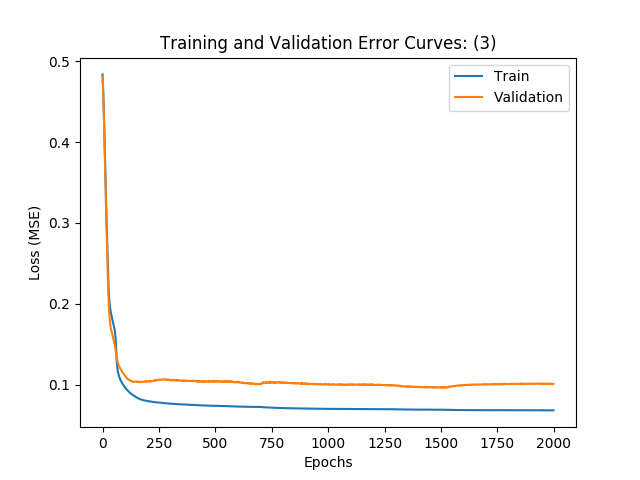

<IPython.core.display.Javascript object>


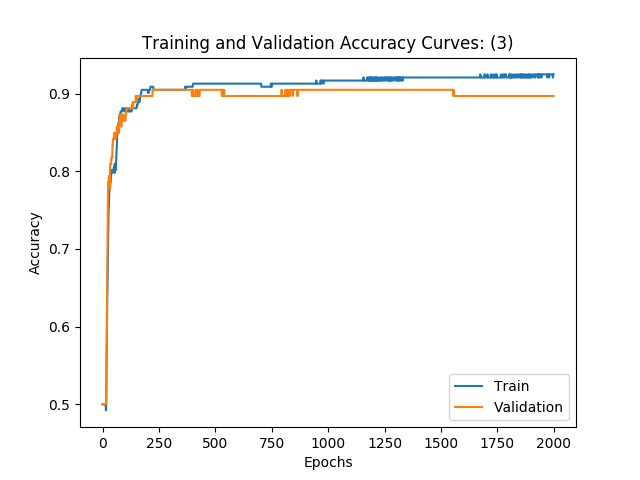

Matriz de confusão
[[1721  177]
 [   7   57]]

Train Loss:       0.0688
Validation Loss:  0.0962
Accuracy:         0.9062
MSE:              0.0938
AUROC:            0.9335


In [61]:
plot_training_error_curves(history, "(3)")
plot_training_acc_curves(history, "(3)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 2 (5)

In [25]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(5, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.9410 - acc: 0.4167 - val_loss: 0.7650 - val_acc: 0.4048
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.9095 - acc: 0.4167 - val_loss: 0.7407 - val_acc: 0.4127
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.8762 - acc: 0.4246 - val_loss: 0.7176 - val_acc: 0.4127
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.8479 - acc: 0.4286 - val_loss: 0.6958 - val_acc: 0.4286
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.8204 - acc: 0.4325 - val_loss: 0.6758 - val_acc: 0.4365
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.7981 - acc: 0.4365 - val_loss: 0.6578 - val_acc: 0.4444
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.7739 - acc: 0.4325 - val_loss: 0.6427 - val_acc: 0.4524
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.7538 - acc

252/252 [==============================] - 0s - loss: 0.1466 - acc: 0.8254 - val_loss: 0.2727 - val_acc: 0.8333
Epoch 66/2000
252/252 [==============================] - 0s - loss: 0.1436 - acc: 0.8254 - val_loss: 0.2681 - val_acc: 0.8333
Epoch 67/2000
252/252 [==============================] - 0s - loss: 0.1407 - acc: 0.8333 - val_loss: 0.2658 - val_acc: 0.8333
Epoch 68/2000
252/252 [==============================] - 0s - loss: 0.1385 - acc: 0.8333 - val_loss: 0.2624 - val_acc: 0.8333
Epoch 69/2000
252/252 [==============================] - 0s - loss: 0.1360 - acc: 0.8413 - val_loss: 0.2588 - val_acc: 0.8333
Epoch 70/2000
252/252 [==============================] - 0s - loss: 0.1341 - acc: 0.8373 - val_loss: 0.2535 - val_acc: 0.8333
Epoch 71/2000
252/252 [==============================] - 0s - loss: 0.1320 - acc: 0.8413 - val_loss: 0.2490 - val_acc: 0.8333
Epoch 72/2000
252/252 [==============================] - 0s - loss: 0.1303 - acc: 0.8452 - val_loss: 0.2471 - val_acc: 0.8333
Epoch 

252/252 [==============================] - 0s - loss: 0.0970 - acc: 0.9008 - val_loss: 0.1427 - val_acc: 0.8730
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.0967 - acc: 0.9008 - val_loss: 0.1422 - val_acc: 0.8730
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.0965 - acc: 0.9048 - val_loss: 0.1414 - val_acc: 0.8730
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.0964 - acc: 0.9048 - val_loss: 0.1414 - val_acc: 0.8730
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.0961 - acc: 0.9048 - val_loss: 0.1401 - val_acc: 0.8810
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.0960 - acc: 0.9048 - val_loss: 0.1383 - val_acc: 0.8810
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.0958 - acc: 0.9048 - val_loss: 0.1383 - val_acc: 0.8810
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.0955 - acc: 0.9048 - val_loss: 0.1373 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0875 - acc: 0.9048 - val_loss: 0.1154 - val_acc: 0.9048
Epoch 194/2000
252/252 [==============================] - 0s - loss: 0.0874 - acc: 0.9048 - val_loss: 0.1154 - val_acc: 0.9048
Epoch 195/2000
252/252 [==============================] - 0s - loss: 0.0874 - acc: 0.9048 - val_loss: 0.1151 - val_acc: 0.9048
Epoch 196/2000
252/252 [==============================] - 0s - loss: 0.0873 - acc: 0.9048 - val_loss: 0.1151 - val_acc: 0.9048
Epoch 197/2000
252/252 [==============================] - 0s - loss: 0.0872 - acc: 0.9048 - val_loss: 0.1146 - val_acc: 0.9048
Epoch 198/2000
252/252 [==============================] - 0s - loss: 0.0871 - acc: 0.9048 - val_loss: 0.1145 - val_acc: 0.9048
Epoch 199/2000
252/252 [==============================] - 0s - loss: 0.0870 - acc: 0.9048 - val_loss: 0.1148 - val_acc: 0.9048
Epoch 200/2000
252/252 [==============================] - 0s - loss: 0.0869 - acc: 0.9048 - val_loss: 0.1149 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0821 - acc: 0.9167 - val_loss: 0.1040 - val_acc: 0.8968
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0821 - acc: 0.9167 - val_loss: 0.1033 - val_acc: 0.8968
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0820 - acc: 0.9167 - val_loss: 0.1034 - val_acc: 0.8968
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0819 - acc: 0.9167 - val_loss: 0.1030 - val_acc: 0.8968
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0818 - acc: 0.9167 - val_loss: 0.1023 - val_acc: 0.8968
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0818 - acc: 0.9167 - val_loss: 0.1024 - val_acc: 0.8968
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0817 - acc: 0.9167 - val_loss: 0.1033 - val_acc: 0.8968
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0816 - acc: 0.9167 - val_loss: 0.1022 - val_acc: 0.8968

252/252 [==============================] - 0s - loss: 0.0767 - acc: 0.9167 - val_loss: 0.0928 - val_acc: 0.9048
Epoch 322/2000
252/252 [==============================] - 0s - loss: 0.0765 - acc: 0.9167 - val_loss: 0.0929 - val_acc: 0.9048
Epoch 323/2000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9167 - val_loss: 0.0927 - val_acc: 0.9048
Epoch 324/2000
252/252 [==============================] - 0s - loss: 0.0763 - acc: 0.9167 - val_loss: 0.0924 - val_acc: 0.9048
Epoch 325/2000
252/252 [==============================] - 0s - loss: 0.0764 - acc: 0.9167 - val_loss: 0.0916 - val_acc: 0.9048
Epoch 326/2000
252/252 [==============================] - 0s - loss: 0.0761 - acc: 0.9167 - val_loss: 0.0919 - val_acc: 0.9048
Epoch 327/2000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9167 - val_loss: 0.0920 - val_acc: 0.9048
Epoch 328/2000
252/252 [==============================] - 0s - loss: 0.0760 - acc: 0.9167 - val_loss: 0.0919 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0719 - acc: 0.9206 - val_loss: 0.0851 - val_acc: 0.9048
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0717 - acc: 0.9206 - val_loss: 0.0855 - val_acc: 0.9048
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0717 - acc: 0.9206 - val_loss: 0.0852 - val_acc: 0.9048
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0717 - acc: 0.9206 - val_loss: 0.0853 - val_acc: 0.9048
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0716 - acc: 0.9206 - val_loss: 0.0850 - val_acc: 0.9048
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0715 - acc: 0.9206 - val_loss: 0.0845 - val_acc: 0.9048
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0715 - acc: 0.9206 - val_loss: 0.0843 - val_acc: 0.9048
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0714 - acc: 0.9206 - val_loss: 0.0845 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9246 - val_loss: 0.0819 - val_acc: 0.9048
Epoch 450/2000
252/252 [==============================] - 0s - loss: 0.0680 - acc: 0.9286 - val_loss: 0.0820 - val_acc: 0.9048
Epoch 451/2000
252/252 [==============================] - 0s - loss: 0.0680 - acc: 0.9286 - val_loss: 0.0823 - val_acc: 0.9048
Epoch 452/2000
252/252 [==============================] - 0s - loss: 0.0678 - acc: 0.9246 - val_loss: 0.0820 - val_acc: 0.9048
Epoch 453/2000
252/252 [==============================] - 0s - loss: 0.0679 - acc: 0.9286 - val_loss: 0.0823 - val_acc: 0.9048
Epoch 454/2000
252/252 [==============================] - 0s - loss: 0.0677 - acc: 0.9286 - val_loss: 0.0820 - val_acc: 0.9048
Epoch 455/2000
252/252 [==============================] - 0s - loss: 0.0676 - acc: 0.9246 - val_loss: 0.0819 - val_acc: 0.9048
Epoch 456/2000
252/252 [==============================] - 0s - loss: 0.0675 - acc: 0.9246 - val_loss: 0.0823 - val_acc: 0.9127

252/252 [==============================] - 0s - loss: 0.0647 - acc: 0.9286 - val_loss: 0.0800 - val_acc: 0.9127
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0647 - acc: 0.9246 - val_loss: 0.0799 - val_acc: 0.9206
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0647 - acc: 0.9286 - val_loss: 0.0799 - val_acc: 0.9206
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0646 - acc: 0.9286 - val_loss: 0.0800 - val_acc: 0.9206
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0646 - acc: 0.9246 - val_loss: 0.0799 - val_acc: 0.9206
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0646 - acc: 0.9246 - val_loss: 0.0799 - val_acc: 0.9206
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0646 - acc: 0.9246 - val_loss: 0.0794 - val_acc: 0.9206
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0645 - acc: 0.9246 - val_loss: 0.0795 - val_acc: 0.9286

252/252 [==============================] - 0s - loss: 0.0631 - acc: 0.9246 - val_loss: 0.0782 - val_acc: 0.9286
Epoch 578/2000
252/252 [==============================] - 0s - loss: 0.0631 - acc: 0.9246 - val_loss: 0.0781 - val_acc: 0.9286
Epoch 579/2000
252/252 [==============================] - 0s - loss: 0.0632 - acc: 0.9246 - val_loss: 0.0780 - val_acc: 0.9286
Epoch 580/2000
252/252 [==============================] - 0s - loss: 0.0631 - acc: 0.9246 - val_loss: 0.0779 - val_acc: 0.9286
Epoch 581/2000
252/252 [==============================] - 0s - loss: 0.0631 - acc: 0.9246 - val_loss: 0.0781 - val_acc: 0.9286
Epoch 582/2000
252/252 [==============================] - 0s - loss: 0.0631 - acc: 0.9246 - val_loss: 0.0781 - val_acc: 0.9286
Epoch 583/2000
252/252 [==============================] - 0s - loss: 0.0630 - acc: 0.9246 - val_loss: 0.0781 - val_acc: 0.9286
Epoch 584/2000
252/252 [==============================] - 0s - loss: 0.0631 - acc: 0.9246 - val_loss: 0.0781 - val_acc: 0.9286

252/252 [==============================] - 0s - loss: 0.0619 - acc: 0.9286 - val_loss: 0.0777 - val_acc: 0.9286
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0619 - acc: 0.9286 - val_loss: 0.0776 - val_acc: 0.9286
Epoch 643/2000
252/252 [==============================] - ETA: 0s - loss: 0.0717 - acc: 0.937 - 0s - loss: 0.0619 - acc: 0.9286 - val_loss: 0.0777 - val_acc: 0.9286
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0619 - acc: 0.9286 - val_loss: 0.0777 - val_acc: 0.9286
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0618 - acc: 0.9286 - val_loss: 0.0777 - val_acc: 0.9286
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0619 - acc: 0.9286 - val_loss: 0.0777 - val_acc: 0.9286
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0619 - acc: 0.9286 - val_loss: 0.0776 - val_acc: 0.9286
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0618 - acc: 0.928

252/252 [==============================] - 0s - loss: 0.0609 - acc: 0.9286 - val_loss: 0.0768 - val_acc: 0.9286
Epoch 706/2000
252/252 [==============================] - ETA: 0s - loss: 0.0586 - acc: 0.968 - 0s - loss: 0.0609 - acc: 0.9286 - val_loss: 0.0767 - val_acc: 0.9286
Epoch 707/2000
252/252 [==============================] - 0s - loss: 0.0609 - acc: 0.9286 - val_loss: 0.0768 - val_acc: 0.9286
Epoch 708/2000
252/252 [==============================] - 0s - loss: 0.0608 - acc: 0.9286 - val_loss: 0.0768 - val_acc: 0.9286
Epoch 709/2000
252/252 [==============================] - 0s - loss: 0.0609 - acc: 0.9286 - val_loss: 0.0769 - val_acc: 0.9286
Epoch 710/2000
252/252 [==============================] - 0s - loss: 0.0608 - acc: 0.9286 - val_loss: 0.0770 - val_acc: 0.9286
Epoch 711/2000
252/252 [==============================] - 0s - loss: 0.0607 - acc: 0.9286 - val_loss: 0.0770 - val_acc: 0.9286
Epoch 712/2000
252/252 [==============================] - 0s - loss: 0.0607 - acc: 0.928

252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9286 - val_loss: 0.0769 - val_acc: 0.9365
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9286 - val_loss: 0.0769 - val_acc: 0.9365
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9286 - val_loss: 0.0770 - val_acc: 0.9365
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9286 - val_loss: 0.0769 - val_acc: 0.9365
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9286 - val_loss: 0.0768 - val_acc: 0.9365
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9286 - val_loss: 0.0771 - val_acc: 0.9365
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9286 - val_loss: 0.0770 - val_acc: 0.9365
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9286 - val_loss: 0.0769 - val_acc: 0.9365

252/252 [==============================] - 0s - loss: 0.0593 - acc: 0.9286 - val_loss: 0.0772 - val_acc: 0.9365
Epoch 834/2000
252/252 [==============================] - 0s - loss: 0.0593 - acc: 0.9286 - val_loss: 0.0771 - val_acc: 0.9365
Epoch 835/2000
252/252 [==============================] - 0s - loss: 0.0593 - acc: 0.9286 - val_loss: 0.0773 - val_acc: 0.9365
Epoch 836/2000
252/252 [==============================] - 0s - loss: 0.0593 - acc: 0.9286 - val_loss: 0.0773 - val_acc: 0.9365
Epoch 837/2000
252/252 [==============================] - 0s - loss: 0.0593 - acc: 0.9286 - val_loss: 0.0771 - val_acc: 0.9365
Epoch 838/2000
252/252 [==============================] - 0s - loss: 0.0593 - acc: 0.9286 - val_loss: 0.0773 - val_acc: 0.9365
Epoch 839/2000
252/252 [==============================] - 0s - loss: 0.0593 - acc: 0.9246 - val_loss: 0.0775 - val_acc: 0.9365
Epoch 840/2000
252/252 [==============================] - 0s - loss: 0.0593 - acc: 0.9246 - val_loss: 0.0774 - val_acc: 0.9365

252/252 [==============================] - 0s - loss: 0.0589 - acc: 0.9246 - val_loss: 0.0776 - val_acc: 0.9365
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0590 - acc: 0.9246 - val_loss: 0.0774 - val_acc: 0.9365
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0589 - acc: 0.9246 - val_loss: 0.0778 - val_acc: 0.9365
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0589 - acc: 0.9246 - val_loss: 0.0774 - val_acc: 0.9365
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0590 - acc: 0.9286 - val_loss: 0.0774 - val_acc: 0.9365
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0589 - acc: 0.9246 - val_loss: 0.0782 - val_acc: 0.9365
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0589 - acc: 0.9246 - val_loss: 0.0776 - val_acc: 0.9365
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0589 - acc: 0.9246 - val_loss: 0.0777 - val_acc: 0.9365

252/252 [==============================] - 0s - loss: 0.0588 - acc: 0.9246 - val_loss: 0.0784 - val_acc: 0.9365
Epoch 962/2000
252/252 [==============================] - 0s - loss: 0.0588 - acc: 0.9286 - val_loss: 0.0774 - val_acc: 0.9365
Epoch 963/2000
252/252 [==============================] - 0s - loss: 0.0587 - acc: 0.9246 - val_loss: 0.0781 - val_acc: 0.9365
Epoch 964/2000
252/252 [==============================] - 0s - loss: 0.0587 - acc: 0.9246 - val_loss: 0.0780 - val_acc: 0.9365
Epoch 965/2000
252/252 [==============================] - 0s - loss: 0.0587 - acc: 0.9246 - val_loss: 0.0772 - val_acc: 0.9365
Epoch 966/2000
252/252 [==============================] - 0s - loss: 0.0587 - acc: 0.9246 - val_loss: 0.0785 - val_acc: 0.9365
Epoch 967/2000
252/252 [==============================] - 0s - loss: 0.0586 - acc: 0.9246 - val_loss: 0.0773 - val_acc: 0.9365
Epoch 968/2000
252/252 [==============================] - 0s - loss: 0.0587 - acc: 0.9246 - val_loss: 0.0776 - val_acc: 0.9365

252/252 [==============================] - 0s - loss: 0.0584 - acc: 0.9286 - val_loss: 0.0777 - val_acc: 0.9365
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0584 - acc: 0.9286 - val_loss: 0.0782 - val_acc: 0.9365
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0585 - acc: 0.9246 - val_loss: 0.0780 - val_acc: 0.9365
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0586 - acc: 0.9286 - val_loss: 0.0770 - val_acc: 0.9365
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0584 - acc: 0.9246 - val_loss: 0.0783 - val_acc: 0.9365
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0584 - acc: 0.9246 - val_loss: 0.0784 - val_acc: 0.9365
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0584 - acc: 0.9246 - val_loss: 0.0774 - val_acc: 0.9365
Epoch 1032/2000
252/252 [==============================] - 0s - loss: 0.0585 - acc: 0.9286 - val_loss: 0.0777 - val_acc:

252/252 [==============================] - 0s - loss: 0.0582 - acc: 0.9325 - val_loss: 0.0773 - val_acc: 0.9286
Epoch 1090/2000
252/252 [==============================] - 0s - loss: 0.0583 - acc: 0.9325 - val_loss: 0.0776 - val_acc: 0.9286
Epoch 1091/2000
252/252 [==============================] - 0s - loss: 0.0582 - acc: 0.9325 - val_loss: 0.0778 - val_acc: 0.9286
Epoch 1092/2000
252/252 [==============================] - 0s - loss: 0.0583 - acc: 0.9325 - val_loss: 0.0779 - val_acc: 0.9286
Epoch 1093/2000
252/252 [==============================] - 0s - loss: 0.0582 - acc: 0.9325 - val_loss: 0.0774 - val_acc: 0.9286
Epoch 1094/2000
252/252 [==============================] - 0s - loss: 0.0583 - acc: 0.9325 - val_loss: 0.0778 - val_acc: 0.9286
Epoch 1095/2000
252/252 [==============================] - 0s - loss: 0.0582 - acc: 0.9325 - val_loss: 0.0776 - val_acc: 0.9286
Epoch 1096/2000
252/252 [==============================] - 0s - loss: 0.0583 - acc: 0.9325 - val_loss: 0.0781 - val_acc:

252/252 [==============================] - 0s - loss: 0.0582 - acc: 0.9365 - val_loss: 0.0776 - val_acc: 0.9286
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0582 - acc: 0.9325 - val_loss: 0.0787 - val_acc: 0.9286
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0582 - acc: 0.9286 - val_loss: 0.0775 - val_acc: 0.9286
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0582 - acc: 0.9325 - val_loss: 0.0767 - val_acc: 0.9286
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0583 - acc: 0.9365 - val_loss: 0.0783 - val_acc: 0.9286
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0582 - acc: 0.9325 - val_loss: 0.0779 - val_acc: 0.9286
Epoch 1159/2000
252/252 [==============================] - 0s - loss: 0.0581 - acc: 0.9325 - val_loss: 0.0773 - val_acc: 0.9286
Epoch 1160/2000
252/252 [==============================] - 0s - loss: 0.0581 - acc: 0.9365 - val_loss: 0.0774 - val_acc:

252/252 [==============================] - 0s - loss: 0.0580 - acc: 0.9365 - val_loss: 0.0773 - val_acc: 0.9286
Epoch 1218/2000
252/252 [==============================] - 0s - loss: 0.0581 - acc: 0.9365 - val_loss: 0.0773 - val_acc: 0.9286
Epoch 1219/2000
252/252 [==============================] - 0s - loss: 0.0581 - acc: 0.9365 - val_loss: 0.0783 - val_acc: 0.9286
Epoch 1220/2000
252/252 [==============================] - 0s - loss: 0.0580 - acc: 0.9365 - val_loss: 0.0771 - val_acc: 0.9286
Epoch 1221/2000
252/252 [==============================] - 0s - loss: 0.0581 - acc: 0.9365 - val_loss: 0.0771 - val_acc: 0.9286
Epoch 1222/2000
252/252 [==============================] - 0s - loss: 0.0581 - acc: 0.9365 - val_loss: 0.0781 - val_acc: 0.9286
Epoch 1223/2000
252/252 [==============================] - 0s - loss: 0.0581 - acc: 0.9365 - val_loss: 0.0774 - val_acc: 0.9286
Epoch 1224/2000
252/252 [==============================] - 0s - loss: 0.0581 - acc: 0.9365 - val_loss: 0.0774 - val_acc:

252/252 [==============================] - 0s - loss: 0.0580 - acc: 0.9365 - val_loss: 0.0783 - val_acc: 0.9286
Epoch 1281/2000
252/252 [==============================] - 0s - loss: 0.0580 - acc: 0.9365 - val_loss: 0.0798 - val_acc: 0.9206
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0578 - acc: 0.9365 - val_loss: 0.0787 - val_acc: 0.9206
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0579 - acc: 0.9365 - val_loss: 0.0785 - val_acc: 0.9286
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0579 - acc: 0.9365 - val_loss: 0.0790 - val_acc: 0.9206
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0580 - acc: 0.9365 - val_loss: 0.0781 - val_acc: 0.9286
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.0579 - acc: 0.9365 - val_loss: 0.0797 - val_acc: 0.9206
Epoch 1287/2000
252/252 [==============================] - 0s - loss: 0.0579 - acc: 0.9365 - val_loss: 0.0789 - val_acc:

252/252 [==============================] - 0s - loss: 0.0578 - acc: 0.9365 - val_loss: 0.0791 - val_acc: 0.9206
Epoch 1345/2000
252/252 [==============================] - 0s - loss: 0.0580 - acc: 0.9365 - val_loss: 0.0795 - val_acc: 0.9206
Epoch 1346/2000
252/252 [==============================] - 0s - loss: 0.0578 - acc: 0.9365 - val_loss: 0.0789 - val_acc: 0.9206
Epoch 1347/2000
252/252 [==============================] - 0s - loss: 0.0579 - acc: 0.9365 - val_loss: 0.0793 - val_acc: 0.9206
Epoch 1348/2000
252/252 [==============================] - 0s - loss: 0.0579 - acc: 0.9365 - val_loss: 0.0797 - val_acc: 0.9206
Epoch 1349/2000
252/252 [==============================] - 0s - loss: 0.0578 - acc: 0.9365 - val_loss: 0.0789 - val_acc: 0.9206
Epoch 1350/2000
252/252 [==============================] - 0s - loss: 0.0578 - acc: 0.9365 - val_loss: 0.0794 - val_acc: 0.9206
Epoch 1351/2000
252/252 [==============================] - 0s - loss: 0.0578 - acc: 0.9365 - val_loss: 0.0795 - val_acc:

252/252 [==============================] - 0s - loss: 0.0577 - acc: 0.9365 - val_loss: 0.0789 - val_acc: 0.9206
Epoch 1408/2000
252/252 [==============================] - 0s - loss: 0.0577 - acc: 0.9365 - val_loss: 0.0792 - val_acc: 0.9127
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0577 - acc: 0.9365 - val_loss: 0.0799 - val_acc: 0.9127
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0578 - acc: 0.9365 - val_loss: 0.0791 - val_acc: 0.9127
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0577 - acc: 0.9365 - val_loss: 0.0788 - val_acc: 0.9206
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0577 - acc: 0.9365 - val_loss: 0.0799 - val_acc: 0.9127
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0577 - acc: 0.9365 - val_loss: 0.0789 - val_acc: 0.9206
Epoch 1414/2000
252/252 [==============================] - 0s - loss: 0.0578 - acc: 0.9365 - val_loss: 0.0797 - val_acc:

252/252 [==============================] - 0s - loss: 0.0575 - acc: 0.9365 - val_loss: 0.0797 - val_acc: 0.9127
Epoch 1472/2000
252/252 [==============================] - 0s - loss: 0.0576 - acc: 0.9365 - val_loss: 0.0798 - val_acc: 0.9127
Epoch 1473/2000
252/252 [==============================] - 0s - loss: 0.0576 - acc: 0.9365 - val_loss: 0.0801 - val_acc: 0.9127
Epoch 1474/2000
252/252 [==============================] - 0s - loss: 0.0576 - acc: 0.9365 - val_loss: 0.0794 - val_acc: 0.9127
Epoch 1475/2000
252/252 [==============================] - 0s - loss: 0.0576 - acc: 0.9365 - val_loss: 0.0787 - val_acc: 0.9206
Epoch 1476/2000
252/252 [==============================] - 0s - loss: 0.0577 - acc: 0.9365 - val_loss: 0.0802 - val_acc: 0.9127
Epoch 1477/2000
252/252 [==============================] - 0s - loss: 0.0576 - acc: 0.9365 - val_loss: 0.0793 - val_acc: 0.9206
Epoch 1478/2000
252/252 [==============================] - 0s - loss: 0.0576 - acc: 0.9365 - val_loss: 0.0793 - val_acc:

252/252 [==============================] - 0s - loss: 0.0575 - acc: 0.9365 - val_loss: 0.0799 - val_acc: 0.9127
Epoch 1536/2000
252/252 [==============================] - 0s - loss: 0.0577 - acc: 0.9365 - val_loss: 0.0795 - val_acc: 0.9206
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0576 - acc: 0.9365 - val_loss: 0.0795 - val_acc: 0.9127
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0576 - acc: 0.9365 - val_loss: 0.0800 - val_acc: 0.9127
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0576 - acc: 0.9365 - val_loss: 0.0795 - val_acc: 0.9206
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0575 - acc: 0.9365 - val_loss: 0.0799 - val_acc: 0.9127
Epoch 1541/2000
252/252 [==============================] - 0s - loss: 0.0576 - acc: 0.9365 - val_loss: 0.0799 - val_acc: 0.9127
Epoch 1542/2000
252/252 [==============================] - 0s - loss: 0.0575 - acc: 0.9365 - val_loss: 0.0789 - val_acc:

252/252 [==============================] - 0s - loss: 0.0577 - acc: 0.9365 - val_loss: 0.0804 - val_acc: 0.9127
Epoch 1600/2000
252/252 [==============================] - 0s - loss: 0.0575 - acc: 0.9365 - val_loss: 0.0794 - val_acc: 0.9206
Epoch 1601/2000
252/252 [==============================] - 0s - loss: 0.0576 - acc: 0.9365 - val_loss: 0.0804 - val_acc: 0.9127
Epoch 1602/2000
252/252 [==============================] - 0s - loss: 0.0576 - acc: 0.9365 - val_loss: 0.0794 - val_acc: 0.9206
Epoch 1603/2000
252/252 [==============================] - 0s - loss: 0.0575 - acc: 0.9365 - val_loss: 0.0806 - val_acc: 0.9127
Epoch 1604/2000
252/252 [==============================] - 0s - loss: 0.0575 - acc: 0.9365 - val_loss: 0.0796 - val_acc: 0.9206
Epoch 1605/2000
252/252 [==============================] - 0s - loss: 0.0576 - acc: 0.9365 - val_loss: 0.0796 - val_acc: 0.9206
Epoch 1606/2000
252/252 [==============================] - 0s - loss: 0.0576 - acc: 0.9365 - val_loss: 0.0807 - val_acc:

252/252 [==============================] - 0s - loss: 0.0576 - acc: 0.9365 - val_loss: 0.0808 - val_acc: 0.9127
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0575 - acc: 0.9365 - val_loss: 0.0790 - val_acc: 0.9206
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0576 - acc: 0.9365 - val_loss: 0.0808 - val_acc: 0.9127
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0576 - acc: 0.9365 - val_loss: 0.0800 - val_acc: 0.9127
Epoch 1667/2000
252/252 [==============================] - ETA: 0s - loss: 0.0330 - acc: 0.968 - 0s - loss: 0.0576 - acc: 0.9365 - val_loss: 0.0800 - val_acc: 0.9127
Epoch 1668/2000
252/252 [==============================] - 0s - loss: 0.0575 - acc: 0.9365 - val_loss: 0.0802 - val_acc: 0.9127
Epoch 1669/2000
252/252 [==============================] - 0s - loss: 0.0575 - acc: 0.9365 - val_loss: 0.0803 - val_acc: 0.9127
Epoch 1670/2000
252/252 [==============================] - 0s - loss: 0.0576 - acc

252/252 [==============================] - 0s - loss: 0.0575 - acc: 0.9365 - val_loss: 0.0809 - val_acc: 0.9127
Epoch 1727/2000
252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9365 - val_loss: 0.0798 - val_acc: 0.9206
Epoch 1728/2000
252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9365 - val_loss: 0.0801 - val_acc: 0.9206
Epoch 1729/2000
252/252 [==============================] - 0s - loss: 0.0576 - acc: 0.9365 - val_loss: 0.0813 - val_acc: 0.9127
Epoch 1730/2000
252/252 [==============================] - 0s - loss: 0.0575 - acc: 0.9365 - val_loss: 0.0802 - val_acc: 0.9206
Epoch 1731/2000
252/252 [==============================] - 0s - loss: 0.0575 - acc: 0.9365 - val_loss: 0.0805 - val_acc: 0.9127
Epoch 1732/2000
252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9365 - val_loss: 0.0803 - val_acc: 0.9127
Epoch 1733/2000
252/252 [==============================] - 0s - loss: 0.0575 - acc: 0.9365 - val_loss: 0.0807 - val_acc:

252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9365 - val_loss: 0.0813 - val_acc: 0.9127
Epoch 1791/2000
252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9365 - val_loss: 0.0801 - val_acc: 0.9206
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0577 - acc: 0.9365 - val_loss: 0.0805 - val_acc: 0.9127
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9365 - val_loss: 0.0814 - val_acc: 0.9127
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0576 - acc: 0.9365 - val_loss: 0.0797 - val_acc: 0.9206
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0575 - acc: 0.9365 - val_loss: 0.0813 - val_acc: 0.9127
Epoch 1796/2000
252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9365 - val_loss: 0.0804 - val_acc: 0.9127
Epoch 1797/2000
252/252 [==============================] - 0s - loss: 0.0575 - acc: 0.9365 - val_loss: 0.0805 - val_acc:

252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9365 - val_loss: 0.0802 - val_acc: 0.9206
Epoch 1855/2000
252/252 [==============================] - 0s - loss: 0.0575 - acc: 0.9365 - val_loss: 0.0804 - val_acc: 0.9127
Epoch 1856/2000
252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9365 - val_loss: 0.0820 - val_acc: 0.9127
Epoch 1857/2000
252/252 [==============================] - 0s - loss: 0.0576 - acc: 0.9365 - val_loss: 0.0804 - val_acc: 0.9127
Epoch 1858/2000
252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9365 - val_loss: 0.0804 - val_acc: 0.9127
Epoch 1859/2000
252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9365 - val_loss: 0.0809 - val_acc: 0.9127
Epoch 1860/2000
252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9365 - val_loss: 0.0804 - val_acc: 0.9127
Epoch 1861/2000
252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9365 - val_loss: 0.0809 - val_acc:

252/252 [==============================] - 0s - loss: 0.0576 - acc: 0.9365 - val_loss: 0.0797 - val_acc: 0.9206
Epoch 1918/2000
252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9365 - val_loss: 0.0812 - val_acc: 0.9127
Epoch 1919/2000
252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9365 - val_loss: 0.0813 - val_acc: 0.9127
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9365 - val_loss: 0.0810 - val_acc: 0.9127
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9365 - val_loss: 0.0803 - val_acc: 0.9206
Epoch 1922/2000
252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9365 - val_loss: 0.0814 - val_acc: 0.9127
Epoch 1923/2000
252/252 [==============================] - 0s - loss: 0.0575 - acc: 0.9365 - val_loss: 0.0810 - val_acc: 0.9127
Epoch 1924/2000
252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9365 - val_loss: 0.0798 - val_acc:

252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9365 - val_loss: 0.0816 - val_acc: 0.9127
Epoch 1982/2000
252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9365 - val_loss: 0.0801 - val_acc: 0.9206
Epoch 1983/2000
252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9365 - val_loss: 0.0804 - val_acc: 0.9206
Epoch 1984/2000
252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9365 - val_loss: 0.0812 - val_acc: 0.9127
Epoch 1985/2000
252/252 [==============================] - 0s - loss: 0.0575 - acc: 0.9365 - val_loss: 0.0812 - val_acc: 0.9127
Epoch 1986/2000
252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9365 - val_loss: 0.0799 - val_acc: 0.9206
Epoch 1987/2000
252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9365 - val_loss: 0.0810 - val_acc: 0.9127
Epoch 1988/2000
252/252 [==============================] - 0s - loss: 0.0574 - acc: 0.9365 - val_loss: 0.0810 - val_acc:

In [26]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.073467710453192878, 0.899592252864021]


<IPython.core.display.Javascript object>


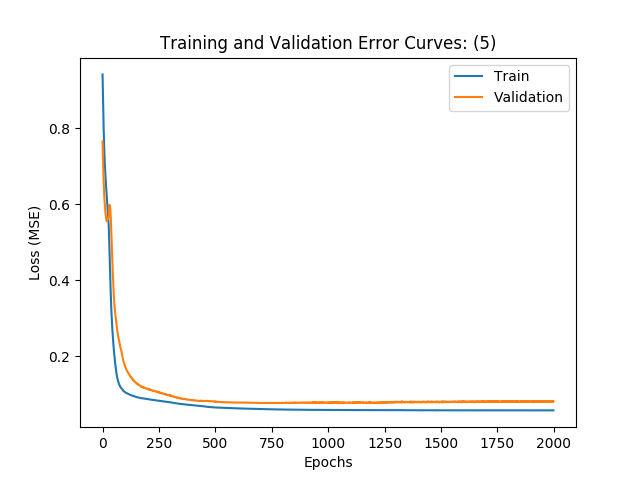

<IPython.core.display.Javascript object>


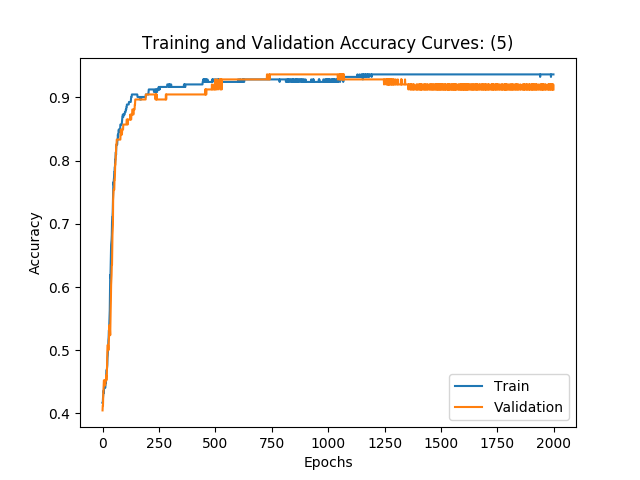

Matriz de confusão
[[1710  188]
 [   9   55]]

Train Loss:       0.0582
Validation Loss:  0.0767
Accuracy:         0.8996
MSE:              0.1004
AUROC:            0.9288


In [27]:
plot_training_error_curves(history, "(5)")
plot_training_acc_curves(history, "(5)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 3 (3, 5)

In [28]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(3, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(5, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.2159 - acc: 0.7341 - val_loss: 0.2213 - val_acc: 0.7540
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.2094 - acc: 0.7381 - val_loss: 0.2122 - val_acc: 0.7540
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.2038 - acc: 0.7540 - val_loss: 0.2055 - val_acc: 0.7460
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.1999 - acc: 0.7579 - val_loss: 0.1994 - val_acc: 0.7540
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.1955 - acc: 0.7619 - val_loss: 0.1941 - val_acc: 0.7698
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.1918 - acc: 0.7619 - val_loss: 0.1901 - val_acc: 0.7778
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.1886 - acc: 0.7738 - val_loss: 0.1853 - val_acc: 0.7857
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.1848 - acc

252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8929 - val_loss: 0.1064 - val_acc: 0.8810
Epoch 66/2000
252/252 [==============================] - 0s - loss: 0.0900 - acc: 0.8929 - val_loss: 0.1055 - val_acc: 0.8810
Epoch 67/2000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8929 - val_loss: 0.1053 - val_acc: 0.8810
Epoch 68/2000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8929 - val_loss: 0.1055 - val_acc: 0.8810
Epoch 69/2000
252/252 [==============================] - 0s - loss: 0.0891 - acc: 0.8929 - val_loss: 0.1044 - val_acc: 0.8810
Epoch 70/2000
252/252 [==============================] - 0s - loss: 0.0889 - acc: 0.8968 - val_loss: 0.1041 - val_acc: 0.8810
Epoch 71/2000
252/252 [==============================] - 0s - loss: 0.0886 - acc: 0.9008 - val_loss: 0.1035 - val_acc: 0.8810
Epoch 72/2000
252/252 [==============================] - 0s - loss: 0.0882 - acc: 0.9008 - val_loss: 0.1032 - val_acc: 0.8810
Epoch 

252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.8929 - val_loss: 0.0816 - val_acc: 0.8730
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.0747 - acc: 0.8968 - val_loss: 0.0818 - val_acc: 0.8730
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.8968 - val_loss: 0.0811 - val_acc: 0.8730
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.8968 - val_loss: 0.0809 - val_acc: 0.8730
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.0743 - acc: 0.8968 - val_loss: 0.0808 - val_acc: 0.8730
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.8968 - val_loss: 0.0803 - val_acc: 0.8730
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.0741 - acc: 0.8968 - val_loss: 0.0805 - val_acc: 0.8730
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.0739 - acc: 0.8968 - val_loss: 0.0799 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0702 - acc: 0.9048 - val_loss: 0.0712 - val_acc: 0.8968
Epoch 194/2000
252/252 [==============================] - 0s - loss: 0.0701 - acc: 0.9048 - val_loss: 0.0714 - val_acc: 0.9048
Epoch 195/2000
252/252 [==============================] - 0s - loss: 0.0702 - acc: 0.9048 - val_loss: 0.0709 - val_acc: 0.8968
Epoch 196/2000
252/252 [==============================] - 0s - loss: 0.0700 - acc: 0.9048 - val_loss: 0.0707 - val_acc: 0.9048
Epoch 197/2000
252/252 [==============================] - 0s - loss: 0.0700 - acc: 0.9048 - val_loss: 0.0709 - val_acc: 0.9048
Epoch 198/2000
252/252 [==============================] - 0s - loss: 0.0700 - acc: 0.9048 - val_loss: 0.0704 - val_acc: 0.8968
Epoch 199/2000
252/252 [==============================] - 0s - loss: 0.0699 - acc: 0.9048 - val_loss: 0.0708 - val_acc: 0.9048
Epoch 200/2000
252/252 [==============================] - 0s - loss: 0.0699 - acc: 0.9048 - val_loss: 0.0709 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0672 - acc: 0.9008 - val_loss: 0.0661 - val_acc: 0.9048
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0672 - acc: 0.9008 - val_loss: 0.0663 - val_acc: 0.9048
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0672 - acc: 0.9008 - val_loss: 0.0658 - val_acc: 0.9048
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0671 - acc: 0.9008 - val_loss: 0.0662 - val_acc: 0.9048
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0671 - acc: 0.9008 - val_loss: 0.0658 - val_acc: 0.9048
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0672 - acc: 0.9008 - val_loss: 0.0659 - val_acc: 0.9048
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0671 - acc: 0.9008 - val_loss: 0.0663 - val_acc: 0.9127
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0671 - acc: 0.9008 - val_loss: 0.0660 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0649 - acc: 0.9087 - val_loss: 0.0620 - val_acc: 0.9127
Epoch 322/2000
252/252 [==============================] - 0s - loss: 0.0648 - acc: 0.9087 - val_loss: 0.0623 - val_acc: 0.9206
Epoch 323/2000
252/252 [==============================] - 0s - loss: 0.0648 - acc: 0.9127 - val_loss: 0.0623 - val_acc: 0.9206
Epoch 324/2000
252/252 [==============================] - 0s - loss: 0.0647 - acc: 0.9087 - val_loss: 0.0624 - val_acc: 0.9206
Epoch 325/2000
252/252 [==============================] - 0s - loss: 0.0647 - acc: 0.9127 - val_loss: 0.0627 - val_acc: 0.9127
Epoch 326/2000
252/252 [==============================] - 0s - loss: 0.0647 - acc: 0.9087 - val_loss: 0.0625 - val_acc: 0.9206
Epoch 327/2000
252/252 [==============================] - 0s - loss: 0.0646 - acc: 0.9127 - val_loss: 0.0620 - val_acc: 0.9127
Epoch 328/2000
252/252 [==============================] - 0s - loss: 0.0647 - acc: 0.9127 - val_loss: 0.0622 - val_acc: 0.9206

252/252 [==============================] - 0s - loss: 0.0634 - acc: 0.9127 - val_loss: 0.0609 - val_acc: 0.9206
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0634 - acc: 0.9167 - val_loss: 0.0610 - val_acc: 0.9127
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0633 - acc: 0.9087 - val_loss: 0.0607 - val_acc: 0.9048
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0634 - acc: 0.9087 - val_loss: 0.0605 - val_acc: 0.9127
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0633 - acc: 0.9127 - val_loss: 0.0604 - val_acc: 0.9206
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0633 - acc: 0.9167 - val_loss: 0.0605 - val_acc: 0.9206
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0632 - acc: 0.9167 - val_loss: 0.0609 - val_acc: 0.9127
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0636 - acc: 0.9087 - val_loss: 0.0612 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0622 - acc: 0.9127 - val_loss: 0.0602 - val_acc: 0.9127
Epoch 450/2000
252/252 [==============================] - 0s - loss: 0.0622 - acc: 0.9127 - val_loss: 0.0598 - val_acc: 0.9206
Epoch 451/2000
252/252 [==============================] - 0s - loss: 0.0625 - acc: 0.9127 - val_loss: 0.0595 - val_acc: 0.9206
Epoch 452/2000
252/252 [==============================] - 0s - loss: 0.0623 - acc: 0.9127 - val_loss: 0.0593 - val_acc: 0.9206
Epoch 453/2000
252/252 [==============================] - 0s - loss: 0.0621 - acc: 0.9127 - val_loss: 0.0601 - val_acc: 0.9127
Epoch 454/2000
252/252 [==============================] - 0s - loss: 0.0622 - acc: 0.9127 - val_loss: 0.0604 - val_acc: 0.9206
Epoch 455/2000
252/252 [==============================] - 0s - loss: 0.0621 - acc: 0.9127 - val_loss: 0.0605 - val_acc: 0.9127
Epoch 456/2000
252/252 [==============================] - 0s - loss: 0.0621 - acc: 0.9127 - val_loss: 0.0599 - val_acc: 0.9127

252/252 [==============================] - 0s - loss: 0.0609 - acc: 0.9127 - val_loss: 0.0611 - val_acc: 0.9127
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0610 - acc: 0.9127 - val_loss: 0.0612 - val_acc: 0.9127
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0610 - acc: 0.9127 - val_loss: 0.0610 - val_acc: 0.9206
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0609 - acc: 0.9127 - val_loss: 0.0614 - val_acc: 0.9206
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0610 - acc: 0.9127 - val_loss: 0.0615 - val_acc: 0.9206
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0609 - acc: 0.9127 - val_loss: 0.0610 - val_acc: 0.9127
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0608 - acc: 0.9127 - val_loss: 0.0604 - val_acc: 0.9127
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0608 - acc: 0.9127 - val_loss: 0.0608 - val_acc: 0.9127

252/252 [==============================] - 0s - loss: 0.0597 - acc: 0.9127 - val_loss: 0.0610 - val_acc: 0.9206
Epoch 578/2000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9127 - val_loss: 0.0615 - val_acc: 0.9206
Epoch 579/2000
252/252 [==============================] - 0s - loss: 0.0598 - acc: 0.9127 - val_loss: 0.0614 - val_acc: 0.9206
Epoch 580/2000
252/252 [==============================] - 0s - loss: 0.0597 - acc: 0.9127 - val_loss: 0.0613 - val_acc: 0.9206
Epoch 581/2000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9127 - val_loss: 0.0613 - val_acc: 0.9127
Epoch 582/2000
252/252 [==============================] - 0s - loss: 0.0598 - acc: 0.9127 - val_loss: 0.0611 - val_acc: 0.9206
Epoch 583/2000
252/252 [==============================] - 0s - loss: 0.0597 - acc: 0.9127 - val_loss: 0.0611 - val_acc: 0.9206
Epoch 584/2000
252/252 [==============================] - 0s - loss: 0.0597 - acc: 0.9127 - val_loss: 0.0615 - val_acc: 0.9206

252/252 [==============================] - 0s - loss: 0.0590 - acc: 0.9167 - val_loss: 0.0611 - val_acc: 0.9206
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0592 - acc: 0.9127 - val_loss: 0.0615 - val_acc: 0.9206
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0590 - acc: 0.9167 - val_loss: 0.0602 - val_acc: 0.9286
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0590 - acc: 0.9167 - val_loss: 0.0604 - val_acc: 0.9286
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0590 - acc: 0.9167 - val_loss: 0.0611 - val_acc: 0.9286
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0588 - acc: 0.9167 - val_loss: 0.0610 - val_acc: 0.9286
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0590 - acc: 0.9127 - val_loss: 0.0611 - val_acc: 0.9286
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0589 - acc: 0.9167 - val_loss: 0.0611 - val_acc: 0.9206

252/252 [==============================] - 0s - loss: 0.0581 - acc: 0.9167 - val_loss: 0.0603 - val_acc: 0.9286
Epoch 706/2000
252/252 [==============================] - 0s - loss: 0.0580 - acc: 0.9167 - val_loss: 0.0606 - val_acc: 0.9286
Epoch 707/2000
252/252 [==============================] - 0s - loss: 0.0581 - acc: 0.9127 - val_loss: 0.0605 - val_acc: 0.9286
Epoch 708/2000
252/252 [==============================] - 0s - loss: 0.0582 - acc: 0.9206 - val_loss: 0.0603 - val_acc: 0.9286
Epoch 709/2000
252/252 [==============================] - 0s - loss: 0.0581 - acc: 0.9206 - val_loss: 0.0603 - val_acc: 0.9286
Epoch 710/2000
252/252 [==============================] - 0s - loss: 0.0581 - acc: 0.9167 - val_loss: 0.0601 - val_acc: 0.9286
Epoch 711/2000
252/252 [==============================] - 0s - loss: 0.0582 - acc: 0.9167 - val_loss: 0.0607 - val_acc: 0.9286
Epoch 712/2000
252/252 [==============================] - 0s - loss: 0.0582 - acc: 0.9167 - val_loss: 0.0602 - val_acc: 0.9286

252/252 [==============================] - 0s - loss: 0.0577 - acc: 0.9206 - val_loss: 0.0591 - val_acc: 0.9286
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0576 - acc: 0.9167 - val_loss: 0.0596 - val_acc: 0.9286
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0576 - acc: 0.9127 - val_loss: 0.0600 - val_acc: 0.9286
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0576 - acc: 0.9127 - val_loss: 0.0603 - val_acc: 0.9286
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0576 - acc: 0.9167 - val_loss: 0.0605 - val_acc: 0.9286
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0575 - acc: 0.9167 - val_loss: 0.0599 - val_acc: 0.9286
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0576 - acc: 0.9167 - val_loss: 0.0599 - val_acc: 0.9286
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0576 - acc: 0.9167 - val_loss: 0.0599 - val_acc: 0.9286

252/252 [==============================] - 0s - loss: 0.0572 - acc: 0.9246 - val_loss: 0.0597 - val_acc: 0.9286
Epoch 834/2000
252/252 [==============================] - 0s - loss: 0.0571 - acc: 0.9246 - val_loss: 0.0602 - val_acc: 0.9286
Epoch 835/2000
252/252 [==============================] - 0s - loss: 0.0572 - acc: 0.9206 - val_loss: 0.0603 - val_acc: 0.9286
Epoch 836/2000
252/252 [==============================] - 0s - loss: 0.0571 - acc: 0.9167 - val_loss: 0.0600 - val_acc: 0.9286
Epoch 837/2000
252/252 [==============================] - 0s - loss: 0.0570 - acc: 0.9167 - val_loss: 0.0602 - val_acc: 0.9286
Epoch 838/2000
252/252 [==============================] - 0s - loss: 0.0571 - acc: 0.9167 - val_loss: 0.0607 - val_acc: 0.9286
Epoch 839/2000
252/252 [==============================] - 0s - loss: 0.0571 - acc: 0.9167 - val_loss: 0.0603 - val_acc: 0.9286
Epoch 840/2000
252/252 [==============================] - 0s - loss: 0.0572 - acc: 0.9167 - val_loss: 0.0603 - val_acc: 0.9286

252/252 [==============================] - 0s - loss: 0.0565 - acc: 0.9246 - val_loss: 0.0609 - val_acc: 0.9286
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0567 - acc: 0.9206 - val_loss: 0.0602 - val_acc: 0.9286
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0567 - acc: 0.9286 - val_loss: 0.0603 - val_acc: 0.9286
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0566 - acc: 0.9286 - val_loss: 0.0613 - val_acc: 0.9286
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0566 - acc: 0.9206 - val_loss: 0.0608 - val_acc: 0.9286
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0565 - acc: 0.9246 - val_loss: 0.0605 - val_acc: 0.9286
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0566 - acc: 0.9286 - val_loss: 0.0600 - val_acc: 0.9286
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0564 - acc: 0.9286 - val_loss: 0.0602 - val_acc: 0.9286

252/252 [==============================] - 0s - loss: 0.0556 - acc: 0.9167 - val_loss: 0.0597 - val_acc: 0.9286
Epoch 962/2000
252/252 [==============================] - 0s - loss: 0.0556 - acc: 0.9167 - val_loss: 0.0594 - val_acc: 0.9286
Epoch 963/2000
252/252 [==============================] - 0s - loss: 0.0556 - acc: 0.9246 - val_loss: 0.0594 - val_acc: 0.9286
Epoch 964/2000
252/252 [==============================] - 0s - loss: 0.0555 - acc: 0.9167 - val_loss: 0.0603 - val_acc: 0.9286
Epoch 965/2000
252/252 [==============================] - 0s - loss: 0.0555 - acc: 0.9167 - val_loss: 0.0602 - val_acc: 0.9286
Epoch 966/2000
252/252 [==============================] - 0s - loss: 0.0555 - acc: 0.9167 - val_loss: 0.0600 - val_acc: 0.9286
Epoch 967/2000
252/252 [==============================] - 0s - loss: 0.0555 - acc: 0.9167 - val_loss: 0.0599 - val_acc: 0.9286
Epoch 968/2000
252/252 [==============================] - 0s - loss: 0.0555 - acc: 0.9206 - val_loss: 0.0598 - val_acc: 0.9286

252/252 [==============================] - 0s - loss: 0.0551 - acc: 0.9286 - val_loss: 0.0591 - val_acc: 0.9206
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0549 - acc: 0.9286 - val_loss: 0.0599 - val_acc: 0.9286
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0556 - acc: 0.9246 - val_loss: 0.0605 - val_acc: 0.9286
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0550 - acc: 0.9246 - val_loss: 0.0595 - val_acc: 0.9206
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0551 - acc: 0.9286 - val_loss: 0.0592 - val_acc: 0.9206
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0551 - acc: 0.9286 - val_loss: 0.0604 - val_acc: 0.9286
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0549 - acc: 0.9246 - val_loss: 0.0610 - val_acc: 0.9286
Epoch 1032/2000
252/252 [==============================] - 0s - loss: 0.0550 - acc: 0.9246 - val_loss: 0.0600 - val_acc:

252/252 [==============================] - 0s - loss: 0.0543 - acc: 0.9246 - val_loss: 0.0599 - val_acc: 0.9286
Epoch 1089/2000
252/252 [==============================] - 0s - loss: 0.0545 - acc: 0.9246 - val_loss: 0.0595 - val_acc: 0.9206
Epoch 1090/2000
252/252 [==============================] - 0s - loss: 0.0545 - acc: 0.9246 - val_loss: 0.0591 - val_acc: 0.9286
Epoch 1091/2000
252/252 [==============================] - 0s - loss: 0.0544 - acc: 0.9246 - val_loss: 0.0595 - val_acc: 0.9206
Epoch 1092/2000
252/252 [==============================] - 0s - loss: 0.0545 - acc: 0.9246 - val_loss: 0.0597 - val_acc: 0.9286
Epoch 1093/2000
252/252 [==============================] - 0s - loss: 0.0544 - acc: 0.9246 - val_loss: 0.0592 - val_acc: 0.9286
Epoch 1094/2000
252/252 [==============================] - 0s - loss: 0.0545 - acc: 0.9246 - val_loss: 0.0598 - val_acc: 0.9286
Epoch 1095/2000
252/252 [==============================] - 0s - loss: 0.0544 - acc: 0.9246 - val_loss: 0.0599 - val_acc:

252/252 [==============================] - 0s - loss: 0.0540 - acc: 0.9246 - val_loss: 0.0592 - val_acc: 0.9286
Epoch 1153/2000
252/252 [==============================] - 0s - loss: 0.0541 - acc: 0.9246 - val_loss: 0.0595 - val_acc: 0.9286
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0541 - acc: 0.9246 - val_loss: 0.0600 - val_acc: 0.9286
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0539 - acc: 0.9246 - val_loss: 0.0591 - val_acc: 0.9286
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0540 - acc: 0.9246 - val_loss: 0.0591 - val_acc: 0.9286
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0539 - acc: 0.9246 - val_loss: 0.0597 - val_acc: 0.9286
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0541 - acc: 0.9246 - val_loss: 0.0595 - val_acc: 0.9286
Epoch 1159/2000
252/252 [==============================] - 0s - loss: 0.0540 - acc: 0.9246 - val_loss: 0.0586 - val_acc:

252/252 [==============================] - 0s - loss: 0.0536 - acc: 0.9246 - val_loss: 0.0587 - val_acc: 0.9286
Epoch 1217/2000
252/252 [==============================] - 0s - loss: 0.0536 - acc: 0.9246 - val_loss: 0.0588 - val_acc: 0.9286
Epoch 1218/2000
252/252 [==============================] - 0s - loss: 0.0536 - acc: 0.9246 - val_loss: 0.0592 - val_acc: 0.9286
Epoch 1219/2000
252/252 [==============================] - 0s - loss: 0.0535 - acc: 0.9206 - val_loss: 0.0590 - val_acc: 0.9286
Epoch 1220/2000
252/252 [==============================] - 0s - loss: 0.0536 - acc: 0.9246 - val_loss: 0.0587 - val_acc: 0.9286
Epoch 1221/2000
252/252 [==============================] - 0s - loss: 0.0536 - acc: 0.9246 - val_loss: 0.0589 - val_acc: 0.9286
Epoch 1222/2000
252/252 [==============================] - 0s - loss: 0.0536 - acc: 0.9206 - val_loss: 0.0587 - val_acc: 0.9286
Epoch 1223/2000
252/252 [==============================] - 0s - loss: 0.0536 - acc: 0.9246 - val_loss: 0.0583 - val_acc:

252/252 [==============================] - 0s - loss: 0.0529 - acc: 0.9286 - val_loss: 0.0578 - val_acc: 0.9206
Epoch 1281/2000
252/252 [==============================] - 0s - loss: 0.0527 - acc: 0.9286 - val_loss: 0.0582 - val_acc: 0.9206
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0526 - acc: 0.9286 - val_loss: 0.0590 - val_acc: 0.9206
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0524 - acc: 0.9286 - val_loss: 0.0593 - val_acc: 0.9206
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0526 - acc: 0.9286 - val_loss: 0.0588 - val_acc: 0.9206
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0524 - acc: 0.9286 - val_loss: 0.0583 - val_acc: 0.9206
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.0524 - acc: 0.9286 - val_loss: 0.0586 - val_acc: 0.9206
Epoch 1287/2000
252/252 [==============================] - 0s - loss: 0.0525 - acc: 0.9286 - val_loss: 0.0583 - val_acc:

252/252 [==============================] - 0s - loss: 0.0520 - acc: 0.9325 - val_loss: 0.0586 - val_acc: 0.9206
Epoch 1345/2000
252/252 [==============================] - 0s - loss: 0.0520 - acc: 0.9325 - val_loss: 0.0588 - val_acc: 0.9206
Epoch 1346/2000
252/252 [==============================] - 0s - loss: 0.0519 - acc: 0.9325 - val_loss: 0.0573 - val_acc: 0.9206
Epoch 1347/2000
252/252 [==============================] - 0s - loss: 0.0520 - acc: 0.9325 - val_loss: 0.0574 - val_acc: 0.9206
Epoch 1348/2000
252/252 [==============================] - 0s - loss: 0.0520 - acc: 0.9286 - val_loss: 0.0577 - val_acc: 0.9206
Epoch 1349/2000
252/252 [==============================] - 0s - loss: 0.0520 - acc: 0.9286 - val_loss: 0.0574 - val_acc: 0.9206
Epoch 1350/2000
252/252 [==============================] - 0s - loss: 0.0520 - acc: 0.9325 - val_loss: 0.0580 - val_acc: 0.9206
Epoch 1351/2000
252/252 [==============================] - 0s - loss: 0.0519 - acc: 0.9325 - val_loss: 0.0580 - val_acc:

252/252 [==============================] - 0s - loss: 0.0517 - acc: 0.9286 - val_loss: 0.0577 - val_acc: 0.9206
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0517 - acc: 0.9286 - val_loss: 0.0571 - val_acc: 0.9206
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0517 - acc: 0.9286 - val_loss: 0.0570 - val_acc: 0.9206
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0518 - acc: 0.9286 - val_loss: 0.0575 - val_acc: 0.9206
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0517 - acc: 0.9286 - val_loss: 0.0575 - val_acc: 0.9206
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0516 - acc: 0.9286 - val_loss: 0.0571 - val_acc: 0.9206
Epoch 1414/2000
252/252 [==============================] - 0s - loss: 0.0517 - acc: 0.9286 - val_loss: 0.0574 - val_acc: 0.9206
Epoch 1415/2000
252/252 [==============================] - 0s - loss: 0.0516 - acc: 0.9286 - val_loss: 0.0574 - val_acc:

252/252 [==============================] - 0s - loss: 0.0516 - acc: 0.9286 - val_loss: 0.0572 - val_acc: 0.9206
Epoch 1473/2000
252/252 [==============================] - 0s - loss: 0.0515 - acc: 0.9286 - val_loss: 0.0573 - val_acc: 0.9206
Epoch 1474/2000
252/252 [==============================] - 0s - loss: 0.0519 - acc: 0.9286 - val_loss: 0.0570 - val_acc: 0.9206
Epoch 1475/2000
252/252 [==============================] - 0s - loss: 0.0515 - acc: 0.9286 - val_loss: 0.0568 - val_acc: 0.9286
Epoch 1476/2000
252/252 [==============================] - 0s - loss: 0.0518 - acc: 0.9286 - val_loss: 0.0567 - val_acc: 0.9206
Epoch 1477/2000
252/252 [==============================] - 0s - loss: 0.0514 - acc: 0.9286 - val_loss: 0.0580 - val_acc: 0.9206
Epoch 1478/2000
252/252 [==============================] - 0s - loss: 0.0517 - acc: 0.9286 - val_loss: 0.0571 - val_acc: 0.9206
Epoch 1479/2000
252/252 [==============================] - 0s - loss: 0.0516 - acc: 0.9286 - val_loss: 0.0567 - val_acc:

252/252 [==============================] - 0s - loss: 0.0513 - acc: 0.9286 - val_loss: 0.0571 - val_acc: 0.9206
Epoch 1536/2000
252/252 [==============================] - 0s - loss: 0.0513 - acc: 0.9286 - val_loss: 0.0577 - val_acc: 0.9206
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0513 - acc: 0.9286 - val_loss: 0.0570 - val_acc: 0.9206
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0514 - acc: 0.9286 - val_loss: 0.0568 - val_acc: 0.9286
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0516 - acc: 0.9286 - val_loss: 0.0571 - val_acc: 0.9206
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0515 - acc: 0.9286 - val_loss: 0.0578 - val_acc: 0.9206
Epoch 1541/2000
252/252 [==============================] - 0s - loss: 0.0515 - acc: 0.9286 - val_loss: 0.0573 - val_acc: 0.9206
Epoch 1542/2000
252/252 [==============================] - 0s - loss: 0.0515 - acc: 0.9286 - val_loss: 0.0572 - val_acc:

252/252 [==============================] - 0s - loss: 0.0510 - acc: 0.9286 - val_loss: 0.0570 - val_acc: 0.9206
Epoch 1600/2000
252/252 [==============================] - 0s - loss: 0.0513 - acc: 0.9286 - val_loss: 0.0569 - val_acc: 0.9206
Epoch 1601/2000
252/252 [==============================] - 0s - loss: 0.0513 - acc: 0.9286 - val_loss: 0.0571 - val_acc: 0.9206
Epoch 1602/2000
252/252 [==============================] - 0s - loss: 0.0510 - acc: 0.9286 - val_loss: 0.0576 - val_acc: 0.9206
Epoch 1603/2000
252/252 [==============================] - 0s - loss: 0.0511 - acc: 0.9286 - val_loss: 0.0574 - val_acc: 0.9206
Epoch 1604/2000
252/252 [==============================] - 0s - loss: 0.0510 - acc: 0.9286 - val_loss: 0.0574 - val_acc: 0.9206
Epoch 1605/2000
252/252 [==============================] - 0s - loss: 0.0510 - acc: 0.9286 - val_loss: 0.0575 - val_acc: 0.9206
Epoch 1606/2000
252/252 [==============================] - 0s - loss: 0.0511 - acc: 0.9286 - val_loss: 0.0578 - val_acc:

252/252 [==============================] - 0s - loss: 0.0507 - acc: 0.9286 - val_loss: 0.0580 - val_acc: 0.9206
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0506 - acc: 0.9286 - val_loss: 0.0577 - val_acc: 0.9206
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0507 - acc: 0.9286 - val_loss: 0.0576 - val_acc: 0.9206
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0509 - acc: 0.9286 - val_loss: 0.0579 - val_acc: 0.9206
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0507 - acc: 0.9286 - val_loss: 0.0581 - val_acc: 0.9206
Epoch 1668/2000
252/252 [==============================] - 0s - loss: 0.0508 - acc: 0.9325 - val_loss: 0.0575 - val_acc: 0.9206
Epoch 1669/2000
252/252 [==============================] - 0s - loss: 0.0509 - acc: 0.9325 - val_loss: 0.0580 - val_acc: 0.9206
Epoch 1670/2000
252/252 [==============================] - 0s - loss: 0.0508 - acc: 0.9286 - val_loss: 0.0590 - val_acc:

252/252 [==============================] - 0s - loss: 0.0507 - acc: 0.9325 - val_loss: 0.0584 - val_acc: 0.9286
Epoch 1728/2000
252/252 [==============================] - 0s - loss: 0.0504 - acc: 0.9286 - val_loss: 0.0586 - val_acc: 0.9206
Epoch 1729/2000
252/252 [==============================] - 0s - loss: 0.0504 - acc: 0.9325 - val_loss: 0.0589 - val_acc: 0.9206
Epoch 1730/2000
252/252 [==============================] - 0s - loss: 0.0504 - acc: 0.9325 - val_loss: 0.0585 - val_acc: 0.9286
Epoch 1731/2000
252/252 [==============================] - 0s - loss: 0.0504 - acc: 0.9286 - val_loss: 0.0589 - val_acc: 0.9286
Epoch 1732/2000
252/252 [==============================] - 0s - loss: 0.0504 - acc: 0.9286 - val_loss: 0.0586 - val_acc: 0.9286
Epoch 1733/2000
252/252 [==============================] - 0s - loss: 0.0503 - acc: 0.9286 - val_loss: 0.0591 - val_acc: 0.9206
Epoch 1734/2000
252/252 [==============================] - 0s - loss: 0.0504 - acc: 0.9325 - val_loss: 0.0592 - val_acc:

252/252 [==============================] - 0s - loss: 0.0504 - acc: 0.9325 - val_loss: 0.0595 - val_acc: 0.9365
Epoch 1791/2000
252/252 [==============================] - 0s - loss: 0.0503 - acc: 0.9325 - val_loss: 0.0609 - val_acc: 0.9206
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0503 - acc: 0.9286 - val_loss: 0.0612 - val_acc: 0.9206
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0502 - acc: 0.9325 - val_loss: 0.0599 - val_acc: 0.9206
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0501 - acc: 0.9325 - val_loss: 0.0595 - val_acc: 0.9286
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0503 - acc: 0.9325 - val_loss: 0.0592 - val_acc: 0.9286
Epoch 1796/2000
252/252 [==============================] - 0s - loss: 0.0501 - acc: 0.9325 - val_loss: 0.0603 - val_acc: 0.9206
Epoch 1797/2000
252/252 [==============================] - 0s - loss: 0.0501 - acc: 0.9286 - val_loss: 0.0599 - val_acc:

252/252 [==============================] - 0s - loss: 0.0499 - acc: 0.9325 - val_loss: 0.0601 - val_acc: 0.9206
Epoch 1855/2000
252/252 [==============================] - 0s - loss: 0.0503 - acc: 0.9325 - val_loss: 0.0607 - val_acc: 0.9206
Epoch 1856/2000
252/252 [==============================] - 0s - loss: 0.0499 - acc: 0.9325 - val_loss: 0.0612 - val_acc: 0.9127
Epoch 1857/2000
252/252 [==============================] - 0s - loss: 0.0505 - acc: 0.9286 - val_loss: 0.0616 - val_acc: 0.9206
Epoch 1858/2000
252/252 [==============================] - 0s - loss: 0.0500 - acc: 0.9325 - val_loss: 0.0609 - val_acc: 0.9286
Epoch 1859/2000
252/252 [==============================] - 0s - loss: 0.0505 - acc: 0.9325 - val_loss: 0.0605 - val_acc: 0.9286
Epoch 1860/2000
252/252 [==============================] - 0s - loss: 0.0500 - acc: 0.9325 - val_loss: 0.0619 - val_acc: 0.9127
Epoch 1861/2000
252/252 [==============================] - 0s - loss: 0.0499 - acc: 0.9286 - val_loss: 0.0613 - val_acc:

252/252 [==============================] - 0s - loss: 0.0485 - acc: 0.9365 - val_loss: 0.0605 - val_acc: 0.9206
Epoch 1919/2000
252/252 [==============================] - 0s - loss: 0.0487 - acc: 0.9365 - val_loss: 0.0607 - val_acc: 0.9206
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0487 - acc: 0.9365 - val_loss: 0.0602 - val_acc: 0.9286
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0488 - acc: 0.9365 - val_loss: 0.0599 - val_acc: 0.9286
Epoch 1922/2000
252/252 [==============================] - 0s - loss: 0.0485 - acc: 0.9365 - val_loss: 0.0603 - val_acc: 0.9286
Epoch 1923/2000
252/252 [==============================] - 0s - loss: 0.0486 - acc: 0.9365 - val_loss: 0.0600 - val_acc: 0.9286
Epoch 1924/2000
252/252 [==============================] - 0s - loss: 0.0486 - acc: 0.9365 - val_loss: 0.0606 - val_acc: 0.9206
Epoch 1925/2000
252/252 [==============================] - 0s - loss: 0.0487 - acc: 0.9365 - val_loss: 0.0599 - val_acc:

252/252 [==============================] - 0s - loss: 0.0470 - acc: 0.9405 - val_loss: 0.0599 - val_acc: 0.9286
Epoch 1983/2000
252/252 [==============================] - 0s - loss: 0.0471 - acc: 0.9405 - val_loss: 0.0591 - val_acc: 0.9286
Epoch 1984/2000
252/252 [==============================] - 0s - loss: 0.0474 - acc: 0.9405 - val_loss: 0.0589 - val_acc: 0.9365
Epoch 1985/2000
252/252 [==============================] - 0s - loss: 0.0475 - acc: 0.9405 - val_loss: 0.0593 - val_acc: 0.9365
Epoch 1986/2000
252/252 [==============================] - 0s - loss: 0.0473 - acc: 0.9405 - val_loss: 0.0596 - val_acc: 0.9365
Epoch 1987/2000
252/252 [==============================] - 0s - loss: 0.0470 - acc: 0.9405 - val_loss: 0.0598 - val_acc: 0.9286
Epoch 1988/2000
252/252 [==============================] - 0s - loss: 0.0471 - acc: 0.9405 - val_loss: 0.0592 - val_acc: 0.9365
Epoch 1989/2000
252/252 [==============================] - 0s - loss: 0.0470 - acc: 0.9405 - val_loss: 0.0588 - val_acc:

In [30]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.093179092373201489, 0.85423037722691608]


<IPython.core.display.Javascript object>


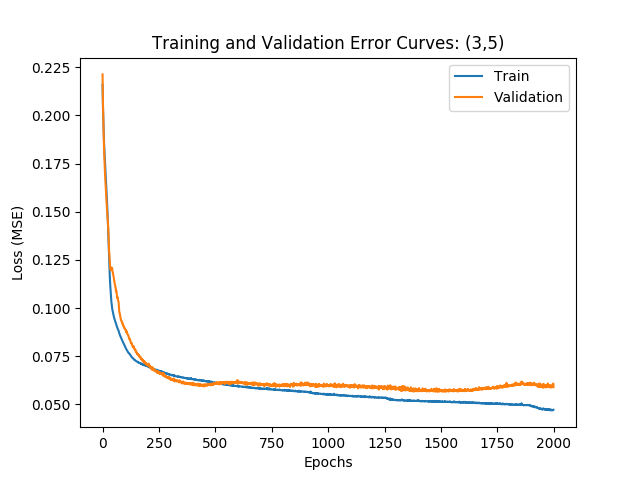

<IPython.core.display.Javascript object>


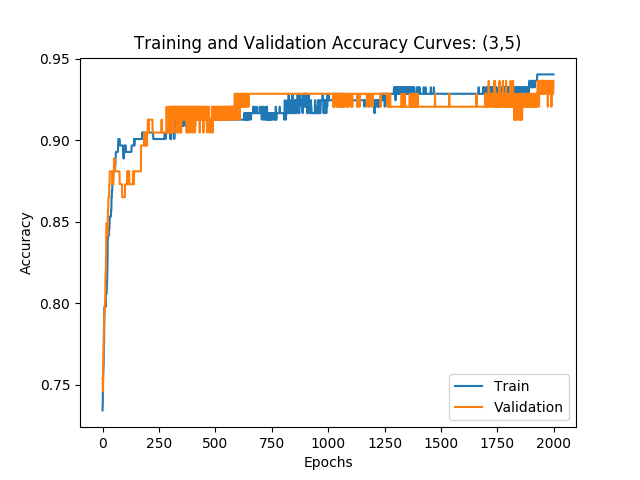

Matriz de confusão
[[1617  281]
 [   5   59]]

Train Loss:       0.0514
Validation Loss:  0.0566
Accuracy:         0.8542
MSE:              0.1458
AUROC:            0.9442


In [31]:
plot_training_error_curves(history, "(3,5)")
plot_training_acc_curves(history, "(3,5)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 4 (5,3)

In [32]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(5, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(3, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='tanh')) # 

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.5215 - acc: 0.3929 - val_loss: 0.5179 - val_acc: 0.3889
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.5038 - acc: 0.3929 - val_loss: 0.4990 - val_acc: 0.4048
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.4834 - acc: 0.4167 - val_loss: 0.4772 - val_acc: 0.4444
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.4618 - acc: 0.4206 - val_loss: 0.4523 - val_acc: 0.4524
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.4373 - acc: 0.4286 - val_loss: 0.4255 - val_acc: 0.4603
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.4137 - acc: 0.4484 - val_loss: 0.3982 - val_acc: 0.4603
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.3881 - acc: 0.4524 - val_loss: 0.3732 - val_acc: 0.4841
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.3644 - acc

252/252 [==============================] - 0s - loss: 0.0961 - acc: 0.8968 - val_loss: 0.0710 - val_acc: 0.9206
Epoch 66/2000
252/252 [==============================] - 0s - loss: 0.0958 - acc: 0.8968 - val_loss: 0.0708 - val_acc: 0.9206
Epoch 67/2000
252/252 [==============================] - 0s - loss: 0.0955 - acc: 0.8968 - val_loss: 0.0705 - val_acc: 0.9206
Epoch 68/2000
252/252 [==============================] - 0s - loss: 0.0953 - acc: 0.8968 - val_loss: 0.0701 - val_acc: 0.9206
Epoch 69/2000
252/252 [==============================] - 0s - loss: 0.0950 - acc: 0.8968 - val_loss: 0.0701 - val_acc: 0.9206
Epoch 70/2000
252/252 [==============================] - ETA: 0s - loss: 0.1747 - acc: 0.781 - 0s - loss: 0.0948 - acc: 0.8968 - val_loss: 0.0697 - val_acc: 0.9206
Epoch 71/2000
252/252 [==============================] - 0s - loss: 0.0946 - acc: 0.8968 - val_loss: 0.0698 - val_acc: 0.9206
Epoch 72/2000
252/252 [==============================] - 0s - loss: 0.0944 - acc: 0.8929 - val

252/252 [==============================] - 0s - loss: 0.0860 - acc: 0.8968 - val_loss: 0.0610 - val_acc: 0.9286
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.0859 - acc: 0.8968 - val_loss: 0.0609 - val_acc: 0.9286
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.0858 - acc: 0.8968 - val_loss: 0.0607 - val_acc: 0.9286
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.0857 - acc: 0.8968 - val_loss: 0.0606 - val_acc: 0.9286
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.0855 - acc: 0.8968 - val_loss: 0.0605 - val_acc: 0.9286
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.0854 - acc: 0.8968 - val_loss: 0.0604 - val_acc: 0.9286
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.0853 - acc: 0.8968 - val_loss: 0.0603 - val_acc: 0.9286
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.0853 - acc: 0.8968 - val_loss: 0.0602 - val_acc: 0.9286

252/252 [==============================] - 0s - loss: 0.0805 - acc: 0.8968 - val_loss: 0.0572 - val_acc: 0.9286
Epoch 194/2000
252/252 [==============================] - 0s - loss: 0.0804 - acc: 0.8968 - val_loss: 0.0571 - val_acc: 0.9286
Epoch 195/2000
252/252 [==============================] - 0s - loss: 0.0803 - acc: 0.8968 - val_loss: 0.0571 - val_acc: 0.9286
Epoch 196/2000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.8968 - val_loss: 0.0571 - val_acc: 0.9286
Epoch 197/2000
252/252 [==============================] - 0s - loss: 0.0802 - acc: 0.8968 - val_loss: 0.0570 - val_acc: 0.9286
Epoch 198/2000
252/252 [==============================] - 0s - loss: 0.0801 - acc: 0.8968 - val_loss: 0.0573 - val_acc: 0.9286
Epoch 199/2000
252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.8968 - val_loss: 0.0572 - val_acc: 0.9286
Epoch 200/2000
252/252 [==============================] - 0s - loss: 0.0800 - acc: 0.8968 - val_loss: 0.0569 - val_acc: 0.9286

252/252 [==============================] - 0s - loss: 0.0754 - acc: 0.9008 - val_loss: 0.0566 - val_acc: 0.9127
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0753 - acc: 0.9008 - val_loss: 0.0569 - val_acc: 0.9127
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9008 - val_loss: 0.0571 - val_acc: 0.9127
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0751 - acc: 0.9008 - val_loss: 0.0567 - val_acc: 0.9127
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9008 - val_loss: 0.0568 - val_acc: 0.9127
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9008 - val_loss: 0.0566 - val_acc: 0.9127
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9008 - val_loss: 0.0566 - val_acc: 0.9127
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0749 - acc: 0.9008 - val_loss: 0.0561 - val_acc: 0.9127

252/252 [==============================] - 0s - loss: 0.0689 - acc: 0.9008 - val_loss: 0.0552 - val_acc: 0.9048
Epoch 322/2000
252/252 [==============================] - 0s - loss: 0.0688 - acc: 0.9008 - val_loss: 0.0554 - val_acc: 0.9048
Epoch 323/2000
252/252 [==============================] - 0s - loss: 0.0687 - acc: 0.9008 - val_loss: 0.0554 - val_acc: 0.9048
Epoch 324/2000
252/252 [==============================] - 0s - loss: 0.0686 - acc: 0.9008 - val_loss: 0.0554 - val_acc: 0.9048
Epoch 325/2000
252/252 [==============================] - 0s - loss: 0.0684 - acc: 0.9008 - val_loss: 0.0554 - val_acc: 0.9048
Epoch 326/2000
252/252 [==============================] - 0s - loss: 0.0683 - acc: 0.9008 - val_loss: 0.0553 - val_acc: 0.9048
Epoch 327/2000
252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9008 - val_loss: 0.0552 - val_acc: 0.9048
Epoch 328/2000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9008 - val_loss: 0.0553 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0622 - acc: 0.9206 - val_loss: 0.0542 - val_acc: 0.8968
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0621 - acc: 0.9206 - val_loss: 0.0545 - val_acc: 0.8968
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0619 - acc: 0.9206 - val_loss: 0.0545 - val_acc: 0.8968
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0618 - acc: 0.9206 - val_loss: 0.0542 - val_acc: 0.8968
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0617 - acc: 0.9206 - val_loss: 0.0543 - val_acc: 0.8968
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0616 - acc: 0.9206 - val_loss: 0.0546 - val_acc: 0.8968
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0614 - acc: 0.9167 - val_loss: 0.0546 - val_acc: 0.8968
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0614 - acc: 0.9167 - val_loss: 0.0545 - val_acc: 0.8968

252/252 [==============================] - 0s - loss: 0.0556 - acc: 0.9325 - val_loss: 0.0555 - val_acc: 0.9048
Epoch 450/2000
252/252 [==============================] - 0s - loss: 0.0556 - acc: 0.9325 - val_loss: 0.0553 - val_acc: 0.9048
Epoch 451/2000
252/252 [==============================] - 0s - loss: 0.0556 - acc: 0.9325 - val_loss: 0.0557 - val_acc: 0.9048
Epoch 452/2000
252/252 [==============================] - 0s - loss: 0.0553 - acc: 0.9325 - val_loss: 0.0555 - val_acc: 0.9048
Epoch 453/2000
252/252 [==============================] - 0s - loss: 0.0552 - acc: 0.9325 - val_loss: 0.0555 - val_acc: 0.9048
Epoch 454/2000
252/252 [==============================] - 0s - loss: 0.0551 - acc: 0.9325 - val_loss: 0.0553 - val_acc: 0.9048
Epoch 455/2000
252/252 [==============================] - 0s - loss: 0.0550 - acc: 0.9325 - val_loss: 0.0552 - val_acc: 0.9048
Epoch 456/2000
252/252 [==============================] - 0s - loss: 0.0549 - acc: 0.9325 - val_loss: 0.0553 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0487 - acc: 0.9405 - val_loss: 0.0525 - val_acc: 0.9206
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0485 - acc: 0.9405 - val_loss: 0.0526 - val_acc: 0.9206
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0485 - acc: 0.9405 - val_loss: 0.0528 - val_acc: 0.9206
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0484 - acc: 0.9405 - val_loss: 0.0528 - val_acc: 0.9206
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0482 - acc: 0.9405 - val_loss: 0.0530 - val_acc: 0.9206
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0482 - acc: 0.9405 - val_loss: 0.0531 - val_acc: 0.9206
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0480 - acc: 0.9405 - val_loss: 0.0528 - val_acc: 0.9206
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0480 - acc: 0.9405 - val_loss: 0.0525 - val_acc: 0.9206

252/252 [==============================] - 0s - loss: 0.0425 - acc: 0.9524 - val_loss: 0.0510 - val_acc: 0.9206
Epoch 578/2000
252/252 [==============================] - 0s - loss: 0.0425 - acc: 0.9524 - val_loss: 0.0508 - val_acc: 0.9206
Epoch 579/2000
252/252 [==============================] - 0s - loss: 0.0424 - acc: 0.9524 - val_loss: 0.0512 - val_acc: 0.9206
Epoch 580/2000
252/252 [==============================] - 0s - loss: 0.0424 - acc: 0.9524 - val_loss: 0.0510 - val_acc: 0.9206
Epoch 581/2000
252/252 [==============================] - 0s - loss: 0.0422 - acc: 0.9524 - val_loss: 0.0507 - val_acc: 0.9206
Epoch 582/2000
252/252 [==============================] - 0s - loss: 0.0424 - acc: 0.9524 - val_loss: 0.0508 - val_acc: 0.9206
Epoch 583/2000
252/252 [==============================] - 0s - loss: 0.0421 - acc: 0.9524 - val_loss: 0.0509 - val_acc: 0.9206
Epoch 584/2000
252/252 [==============================] - 0s - loss: 0.0421 - acc: 0.9524 - val_loss: 0.0509 - val_acc: 0.9206

252/252 [==============================] - 0s - loss: 0.0388 - acc: 0.9563 - val_loss: 0.0521 - val_acc: 0.9048
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0388 - acc: 0.9603 - val_loss: 0.0519 - val_acc: 0.9127
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0387 - acc: 0.9563 - val_loss: 0.0520 - val_acc: 0.9048
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0387 - acc: 0.9563 - val_loss: 0.0521 - val_acc: 0.9048
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0387 - acc: 0.9563 - val_loss: 0.0520 - val_acc: 0.9048
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0385 - acc: 0.9563 - val_loss: 0.0520 - val_acc: 0.9127
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0385 - acc: 0.9563 - val_loss: 0.0523 - val_acc: 0.9048
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0385 - acc: 0.9563 - val_loss: 0.0522 - val_acc: 0.9127

252/252 [==============================] - 0s - loss: 0.0364 - acc: 0.9643 - val_loss: 0.0543 - val_acc: 0.9286
Epoch 706/2000
252/252 [==============================] - 0s - loss: 0.0363 - acc: 0.9683 - val_loss: 0.0547 - val_acc: 0.9206
Epoch 707/2000
252/252 [==============================] - 0s - loss: 0.0363 - acc: 0.9683 - val_loss: 0.0547 - val_acc: 0.9206
Epoch 708/2000
252/252 [==============================] - 0s - loss: 0.0363 - acc: 0.9643 - val_loss: 0.0549 - val_acc: 0.9206
Epoch 709/2000
252/252 [==============================] - 0s - loss: 0.0362 - acc: 0.9683 - val_loss: 0.0548 - val_acc: 0.9206
Epoch 710/2000
252/252 [==============================] - 0s - loss: 0.0361 - acc: 0.9683 - val_loss: 0.0547 - val_acc: 0.9286
Epoch 711/2000
252/252 [==============================] - 0s - loss: 0.0361 - acc: 0.9683 - val_loss: 0.0550 - val_acc: 0.9206
Epoch 712/2000
252/252 [==============================] - 0s - loss: 0.0360 - acc: 0.9683 - val_loss: 0.0552 - val_acc: 0.9206

252/252 [==============================] - 0s - loss: 0.0340 - acc: 0.9683 - val_loss: 0.0575 - val_acc: 0.9206
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0339 - acc: 0.9722 - val_loss: 0.0574 - val_acc: 0.9206
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0339 - acc: 0.9722 - val_loss: 0.0573 - val_acc: 0.9206
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0339 - acc: 0.9722 - val_loss: 0.0573 - val_acc: 0.9206
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0338 - acc: 0.9722 - val_loss: 0.0575 - val_acc: 0.9206
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0338 - acc: 0.9722 - val_loss: 0.0575 - val_acc: 0.9206
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0338 - acc: 0.9722 - val_loss: 0.0578 - val_acc: 0.9206
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0338 - acc: 0.9722 - val_loss: 0.0577 - val_acc: 0.9127

252/252 [==============================] - 0s - loss: 0.0318 - acc: 0.9722 - val_loss: 0.0587 - val_acc: 0.9206
Epoch 834/2000
252/252 [==============================] - 0s - loss: 0.0318 - acc: 0.9683 - val_loss: 0.0587 - val_acc: 0.9127
Epoch 835/2000
252/252 [==============================] - 0s - loss: 0.0318 - acc: 0.9683 - val_loss: 0.0589 - val_acc: 0.9206
Epoch 836/2000
252/252 [==============================] - 0s - loss: 0.0318 - acc: 0.9683 - val_loss: 0.0590 - val_acc: 0.9127
Epoch 837/2000
252/252 [==============================] - 0s - loss: 0.0318 - acc: 0.9683 - val_loss: 0.0589 - val_acc: 0.9206
Epoch 838/2000
252/252 [==============================] - 0s - loss: 0.0317 - acc: 0.9722 - val_loss: 0.0586 - val_acc: 0.9127
Epoch 839/2000
252/252 [==============================] - 0s - loss: 0.0317 - acc: 0.9683 - val_loss: 0.0587 - val_acc: 0.9206
Epoch 840/2000
252/252 [==============================] - 0s - loss: 0.0316 - acc: 0.9683 - val_loss: 0.0586 - val_acc: 0.9127

252/252 [==============================] - 0s - loss: 0.0300 - acc: 0.9722 - val_loss: 0.0593 - val_acc: 0.9127
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0300 - acc: 0.9722 - val_loss: 0.0593 - val_acc: 0.9127
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0300 - acc: 0.9722 - val_loss: 0.0593 - val_acc: 0.9127
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0300 - acc: 0.9683 - val_loss: 0.0592 - val_acc: 0.9127
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0299 - acc: 0.9683 - val_loss: 0.0594 - val_acc: 0.9127
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0299 - acc: 0.9683 - val_loss: 0.0595 - val_acc: 0.9127
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0299 - acc: 0.9683 - val_loss: 0.0590 - val_acc: 0.9127
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0298 - acc: 0.9683 - val_loss: 0.0595 - val_acc: 0.9127

252/252 [==============================] - 0s - loss: 0.0286 - acc: 0.9683 - val_loss: 0.0601 - val_acc: 0.9048
Epoch 962/2000
252/252 [==============================] - 0s - loss: 0.0286 - acc: 0.9683 - val_loss: 0.0601 - val_acc: 0.9048
Epoch 963/2000
252/252 [==============================] - 0s - loss: 0.0285 - acc: 0.9683 - val_loss: 0.0600 - val_acc: 0.9048
Epoch 964/2000
252/252 [==============================] - 0s - loss: 0.0285 - acc: 0.9683 - val_loss: 0.0603 - val_acc: 0.9048
Epoch 965/2000
252/252 [==============================] - 0s - loss: 0.0284 - acc: 0.9683 - val_loss: 0.0603 - val_acc: 0.9127
Epoch 966/2000
252/252 [==============================] - 0s - loss: 0.0284 - acc: 0.9683 - val_loss: 0.0603 - val_acc: 0.9048
Epoch 967/2000
252/252 [==============================] - 0s - loss: 0.0284 - acc: 0.9683 - val_loss: 0.0602 - val_acc: 0.9048
Epoch 968/2000
252/252 [==============================] - 0s - loss: 0.0284 - acc: 0.9683 - val_loss: 0.0601 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0274 - acc: 0.9683 - val_loss: 0.0600 - val_acc: 0.9048
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0274 - acc: 0.9683 - val_loss: 0.0602 - val_acc: 0.9048
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0274 - acc: 0.9683 - val_loss: 0.0604 - val_acc: 0.9048
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0274 - acc: 0.9683 - val_loss: 0.0605 - val_acc: 0.9048
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0274 - acc: 0.9683 - val_loss: 0.0607 - val_acc: 0.9048
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0273 - acc: 0.9683 - val_loss: 0.0605 - val_acc: 0.9048
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0274 - acc: 0.9683 - val_loss: 0.0609 - val_acc: 0.9048
Epoch 1032/2000
252/252 [==============================] - 0s - loss: 0.0273 - acc: 0.9683 - val_loss: 0.0608 - val_acc:

252/252 [==============================] - 0s - loss: 0.0267 - acc: 0.9683 - val_loss: 0.0614 - val_acc: 0.9048
Epoch 1090/2000
252/252 [==============================] - 0s - loss: 0.0266 - acc: 0.9683 - val_loss: 0.0611 - val_acc: 0.9048
Epoch 1091/2000
252/252 [==============================] - 0s - loss: 0.0266 - acc: 0.9683 - val_loss: 0.0611 - val_acc: 0.9048
Epoch 1092/2000
252/252 [==============================] - 0s - loss: 0.0266 - acc: 0.9683 - val_loss: 0.0614 - val_acc: 0.9048
Epoch 1093/2000
252/252 [==============================] - 0s - loss: 0.0266 - acc: 0.9683 - val_loss: 0.0612 - val_acc: 0.9048
Epoch 1094/2000
252/252 [==============================] - 0s - loss: 0.0265 - acc: 0.9683 - val_loss: 0.0609 - val_acc: 0.9048
Epoch 1095/2000
252/252 [==============================] - 0s - loss: 0.0265 - acc: 0.9683 - val_loss: 0.0609 - val_acc: 0.9048
Epoch 1096/2000
252/252 [==============================] - 0s - loss: 0.0266 - acc: 0.9683 - val_loss: 0.0609 - val_acc:

252/252 [==============================] - 0s - loss: 0.0260 - acc: 0.9683 - val_loss: 0.0598 - val_acc: 0.9048
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0260 - acc: 0.9683 - val_loss: 0.0588 - val_acc: 0.9127
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0260 - acc: 0.9683 - val_loss: 0.0585 - val_acc: 0.9127
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0260 - acc: 0.9683 - val_loss: 0.0587 - val_acc: 0.9127
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0260 - acc: 0.9683 - val_loss: 0.0591 - val_acc: 0.9127
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0259 - acc: 0.9722 - val_loss: 0.0589 - val_acc: 0.9206
Epoch 1159/2000
252/252 [==============================] - 0s - loss: 0.0260 - acc: 0.9683 - val_loss: 0.0589 - val_acc: 0.9127
Epoch 1160/2000
252/252 [==============================] - 0s - loss: 0.0258 - acc: 0.9722 - val_loss: 0.0587 - val_acc:

252/252 [==============================] - 0s - loss: 0.0254 - acc: 0.9722 - val_loss: 0.0604 - val_acc: 0.9206
Epoch 1218/2000
252/252 [==============================] - 0s - loss: 0.0253 - acc: 0.9722 - val_loss: 0.0609 - val_acc: 0.9206
Epoch 1219/2000
252/252 [==============================] - 0s - loss: 0.0253 - acc: 0.9722 - val_loss: 0.0611 - val_acc: 0.9206
Epoch 1220/2000
252/252 [==============================] - 0s - loss: 0.0253 - acc: 0.9722 - val_loss: 0.0607 - val_acc: 0.9206
Epoch 1221/2000
252/252 [==============================] - 0s - loss: 0.0254 - acc: 0.9722 - val_loss: 0.0609 - val_acc: 0.9206
Epoch 1222/2000
252/252 [==============================] - 0s - loss: 0.0253 - acc: 0.9722 - val_loss: 0.0614 - val_acc: 0.9206
Epoch 1223/2000
252/252 [==============================] - 0s - loss: 0.0253 - acc: 0.9722 - val_loss: 0.0618 - val_acc: 0.9206
Epoch 1224/2000
252/252 [==============================] - 0s - loss: 0.0253 - acc: 0.9722 - val_loss: 0.0600 - val_acc:

252/252 [==============================] - 0s - loss: 0.0248 - acc: 0.9722 - val_loss: 0.0610 - val_acc: 0.9206
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0248 - acc: 0.9722 - val_loss: 0.0614 - val_acc: 0.9206
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0248 - acc: 0.9722 - val_loss: 0.0607 - val_acc: 0.9206
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0248 - acc: 0.9722 - val_loss: 0.0605 - val_acc: 0.9206
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0248 - acc: 0.9722 - val_loss: 0.0606 - val_acc: 0.9127
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.0248 - acc: 0.9722 - val_loss: 0.0610 - val_acc: 0.9206
Epoch 1287/2000
252/252 [==============================] - 0s - loss: 0.0248 - acc: 0.9722 - val_loss: 0.0610 - val_acc: 0.9127
Epoch 1288/2000
252/252 [==============================] - 0s - loss: 0.0248 - acc: 0.9722 - val_loss: 0.0609 - val_acc:

252/252 [==============================] - 0s - loss: 0.0245 - acc: 0.9722 - val_loss: 0.0629 - val_acc: 0.9127
Epoch 1346/2000
252/252 [==============================] - 0s - loss: 0.0244 - acc: 0.9722 - val_loss: 0.0634 - val_acc: 0.9127
Epoch 1347/2000
252/252 [==============================] - 0s - loss: 0.0244 - acc: 0.9722 - val_loss: 0.0627 - val_acc: 0.9127
Epoch 1348/2000
252/252 [==============================] - 0s - loss: 0.0244 - acc: 0.9722 - val_loss: 0.0612 - val_acc: 0.9206
Epoch 1349/2000
252/252 [==============================] - 0s - loss: 0.0245 - acc: 0.9722 - val_loss: 0.0611 - val_acc: 0.9206
Epoch 1350/2000
252/252 [==============================] - 0s - loss: 0.0244 - acc: 0.9722 - val_loss: 0.0606 - val_acc: 0.9206
Epoch 1351/2000
252/252 [==============================] - 0s - loss: 0.0244 - acc: 0.9722 - val_loss: 0.0606 - val_acc: 0.9127
Epoch 1352/2000
252/252 [==============================] - 0s - loss: 0.0245 - acc: 0.9722 - val_loss: 0.0611 - val_acc:

252/252 [==============================] - 0s - loss: 0.0241 - acc: 0.9722 - val_loss: 0.0621 - val_acc: 0.9127
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0240 - acc: 0.9722 - val_loss: 0.0622 - val_acc: 0.9127
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0241 - acc: 0.9722 - val_loss: 0.0622 - val_acc: 0.9206
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0240 - acc: 0.9722 - val_loss: 0.0626 - val_acc: 0.9206
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0241 - acc: 0.9722 - val_loss: 0.0632 - val_acc: 0.9127
Epoch 1414/2000
252/252 [==============================] - 0s - loss: 0.0241 - acc: 0.9722 - val_loss: 0.0628 - val_acc: 0.9127
Epoch 1415/2000
252/252 [==============================] - 0s - loss: 0.0241 - acc: 0.9722 - val_loss: 0.0633 - val_acc: 0.9127
Epoch 1416/2000
252/252 [==============================] - 0s - loss: 0.0241 - acc: 0.9722 - val_loss: 0.0635 - val_acc:

252/252 [==============================] - 0s - loss: 0.0238 - acc: 0.9762 - val_loss: 0.0639 - val_acc: 0.9127
Epoch 1473/2000
252/252 [==============================] - 0s - loss: 0.0238 - acc: 0.9762 - val_loss: 0.0641 - val_acc: 0.9127
Epoch 1474/2000
252/252 [==============================] - 0s - loss: 0.0238 - acc: 0.9722 - val_loss: 0.0643 - val_acc: 0.9127
Epoch 1475/2000
252/252 [==============================] - 0s - loss: 0.0238 - acc: 0.9722 - val_loss: 0.0646 - val_acc: 0.9127
Epoch 1476/2000
252/252 [==============================] - 0s - loss: 0.0238 - acc: 0.9762 - val_loss: 0.0644 - val_acc: 0.9127
Epoch 1477/2000
252/252 [==============================] - 0s - loss: 0.0238 - acc: 0.9762 - val_loss: 0.0644 - val_acc: 0.9127
Epoch 1478/2000
252/252 [==============================] - 0s - loss: 0.0237 - acc: 0.9762 - val_loss: 0.0644 - val_acc: 0.9127
Epoch 1479/2000
252/252 [==============================] - 0s - loss: 0.0237 - acc: 0.9762 - val_loss: 0.0646 - val_acc:

252/252 [==============================] - 0s - loss: 0.0235 - acc: 0.9762 - val_loss: 0.0655 - val_acc: 0.9127
Epoch 1536/2000
252/252 [==============================] - 0s - loss: 0.0235 - acc: 0.9762 - val_loss: 0.0655 - val_acc: 0.9127
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0235 - acc: 0.9762 - val_loss: 0.0654 - val_acc: 0.9127
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0235 - acc: 0.9762 - val_loss: 0.0654 - val_acc: 0.9127
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0235 - acc: 0.9762 - val_loss: 0.0656 - val_acc: 0.9127
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0235 - acc: 0.9762 - val_loss: 0.0657 - val_acc: 0.9206
Epoch 1541/2000
252/252 [==============================] - 0s - loss: 0.0235 - acc: 0.9762 - val_loss: 0.0655 - val_acc: 0.9206
Epoch 1542/2000
252/252 [==============================] - 0s - loss: 0.0235 - acc: 0.9762 - val_loss: 0.0658 - val_acc:

252/252 [==============================] - 0s - loss: 0.0233 - acc: 0.9762 - val_loss: 0.0653 - val_acc: 0.9206
Epoch 1600/2000
252/252 [==============================] - 0s - loss: 0.0233 - acc: 0.9762 - val_loss: 0.0653 - val_acc: 0.9206
Epoch 1601/2000
252/252 [==============================] - 0s - loss: 0.0233 - acc: 0.9762 - val_loss: 0.0652 - val_acc: 0.9206
Epoch 1602/2000
252/252 [==============================] - 0s - loss: 0.0233 - acc: 0.9762 - val_loss: 0.0654 - val_acc: 0.9206
Epoch 1603/2000
252/252 [==============================] - 0s - loss: 0.0233 - acc: 0.9762 - val_loss: 0.0654 - val_acc: 0.9127
Epoch 1604/2000
252/252 [==============================] - 0s - loss: 0.0232 - acc: 0.9762 - val_loss: 0.0653 - val_acc: 0.9127
Epoch 1605/2000
252/252 [==============================] - 0s - loss: 0.0232 - acc: 0.9762 - val_loss: 0.0656 - val_acc: 0.9206
Epoch 1606/2000
252/252 [==============================] - 0s - loss: 0.0232 - acc: 0.9762 - val_loss: 0.0655 - val_acc:

252/252 [==============================] - 0s - loss: 0.0230 - acc: 0.9762 - val_loss: 0.0682 - val_acc: 0.9286
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0231 - acc: 0.9762 - val_loss: 0.0680 - val_acc: 0.9286
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0231 - acc: 0.9762 - val_loss: 0.0681 - val_acc: 0.9286
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0230 - acc: 0.9762 - val_loss: 0.0680 - val_acc: 0.9206
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0231 - acc: 0.9762 - val_loss: 0.0681 - val_acc: 0.9127
Epoch 1668/2000
252/252 [==============================] - 0s - loss: 0.0230 - acc: 0.9762 - val_loss: 0.0682 - val_acc: 0.9206
Epoch 1669/2000
252/252 [==============================] - 0s - loss: 0.0231 - acc: 0.9762 - val_loss: 0.0681 - val_acc: 0.9206
Epoch 1670/2000
252/252 [==============================] - 0s - loss: 0.0230 - acc: 0.9762 - val_loss: 0.0680 - val_acc:

252/252 [==============================] - 0s - loss: 0.0229 - acc: 0.9762 - val_loss: 0.0664 - val_acc: 0.9286
Epoch 1728/2000
252/252 [==============================] - 0s - loss: 0.0229 - acc: 0.9762 - val_loss: 0.0672 - val_acc: 0.9286
Epoch 1729/2000
252/252 [==============================] - 0s - loss: 0.0229 - acc: 0.9762 - val_loss: 0.0677 - val_acc: 0.9286
Epoch 1730/2000
252/252 [==============================] - 0s - loss: 0.0230 - acc: 0.9762 - val_loss: 0.0675 - val_acc: 0.9206
Epoch 1731/2000
252/252 [==============================] - 0s - loss: 0.0228 - acc: 0.9762 - val_loss: 0.0671 - val_acc: 0.9286
Epoch 1732/2000
252/252 [==============================] - 0s - loss: 0.0229 - acc: 0.9762 - val_loss: 0.0674 - val_acc: 0.9286
Epoch 1733/2000
252/252 [==============================] - 0s - loss: 0.0228 - acc: 0.9762 - val_loss: 0.0678 - val_acc: 0.9286
Epoch 1734/2000
252/252 [==============================] - 0s - loss: 0.0228 - acc: 0.9762 - val_loss: 0.0671 - val_acc:

252/252 [==============================] - 0s - loss: 0.0227 - acc: 0.9762 - val_loss: 0.0707 - val_acc: 0.9286
Epoch 1792/2000
252/252 [==============================] - ETA: 0s - loss: 0.0540 - acc: 0.937 - 0s - loss: 0.0228 - acc: 0.9762 - val_loss: 0.0699 - val_acc: 0.9286
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0227 - acc: 0.9762 - val_loss: 0.0700 - val_acc: 0.9286
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0227 - acc: 0.9762 - val_loss: 0.0700 - val_acc: 0.9286
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0227 - acc: 0.9762 - val_loss: 0.0704 - val_acc: 0.9286
Epoch 1796/2000
252/252 [==============================] - 0s - loss: 0.0228 - acc: 0.9762 - val_loss: 0.0694 - val_acc: 0.9286
Epoch 1797/2000
252/252 [==============================] - 0s - loss: 0.0227 - acc: 0.9762 - val_loss: 0.0692 - val_acc: 0.9286
Epoch 1798/2000
252/252 [==============================] - 0s - loss: 0.0227 - acc

252/252 [==============================] - 0s - loss: 0.0225 - acc: 0.9762 - val_loss: 0.0726 - val_acc: 0.9286
Epoch 1855/2000
252/252 [==============================] - 0s - loss: 0.0225 - acc: 0.9762 - val_loss: 0.0728 - val_acc: 0.9286
Epoch 1856/2000
252/252 [==============================] - 0s - loss: 0.0227 - acc: 0.9762 - val_loss: 0.0726 - val_acc: 0.9286
Epoch 1857/2000
252/252 [==============================] - 0s - loss: 0.0225 - acc: 0.9762 - val_loss: 0.0735 - val_acc: 0.9286
Epoch 1858/2000
252/252 [==============================] - 0s - loss: 0.0226 - acc: 0.9762 - val_loss: 0.0738 - val_acc: 0.9286
Epoch 1859/2000
252/252 [==============================] - 0s - loss: 0.0225 - acc: 0.9762 - val_loss: 0.0733 - val_acc: 0.9286
Epoch 1860/2000
252/252 [==============================] - 0s - loss: 0.0225 - acc: 0.9762 - val_loss: 0.0723 - val_acc: 0.9286
Epoch 1861/2000
252/252 [==============================] - 0s - loss: 0.0228 - acc: 0.9762 - val_loss: 0.0724 - val_acc:

252/252 [==============================] - 0s - loss: 0.0224 - acc: 0.9762 - val_loss: 0.0717 - val_acc: 0.9286
Epoch 1919/2000
252/252 [==============================] - 0s - loss: 0.0225 - acc: 0.9762 - val_loss: 0.0723 - val_acc: 0.9286
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0226 - acc: 0.9762 - val_loss: 0.0725 - val_acc: 0.9286
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0223 - acc: 0.9762 - val_loss: 0.0733 - val_acc: 0.9286
Epoch 1922/2000
252/252 [==============================] - 0s - loss: 0.0224 - acc: 0.9762 - val_loss: 0.0735 - val_acc: 0.9286
Epoch 1923/2000
252/252 [==============================] - 0s - loss: 0.0225 - acc: 0.9762 - val_loss: 0.0734 - val_acc: 0.9286
Epoch 1924/2000
252/252 [==============================] - 0s - loss: 0.0226 - acc: 0.9762 - val_loss: 0.0736 - val_acc: 0.9286
Epoch 1925/2000
252/252 [==============================] - 0s - loss: 0.0224 - acc: 0.9762 - val_loss: 0.0735 - val_acc:

252/252 [==============================] - 0s - loss: 0.0223 - acc: 0.9762 - val_loss: 0.0704 - val_acc: 0.9286
Epoch 1982/2000
252/252 [==============================] - 0s - loss: 0.0223 - acc: 0.9762 - val_loss: 0.0704 - val_acc: 0.9286
Epoch 1983/2000
252/252 [==============================] - 0s - loss: 0.0223 - acc: 0.9762 - val_loss: 0.0706 - val_acc: 0.9286
Epoch 1984/2000
252/252 [==============================] - 0s - loss: 0.0223 - acc: 0.9762 - val_loss: 0.0705 - val_acc: 0.9286
Epoch 1985/2000
252/252 [==============================] - 0s - loss: 0.0224 - acc: 0.9762 - val_loss: 0.0708 - val_acc: 0.9286
Epoch 1986/2000
252/252 [==============================] - 0s - loss: 0.0224 - acc: 0.9762 - val_loss: 0.0710 - val_acc: 0.9286
Epoch 1987/2000
252/252 [==============================] - 0s - loss: 0.0223 - acc: 0.9762 - val_loss: 0.0713 - val_acc: 0.9286
Epoch 1988/2000
252/252 [==============================] - 0s - loss: 0.0223 - acc: 0.9762 - val_loss: 0.0713 - val_acc:

In [33]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.12374421902509761, 0.86748216099938369]


<IPython.core.display.Javascript object>


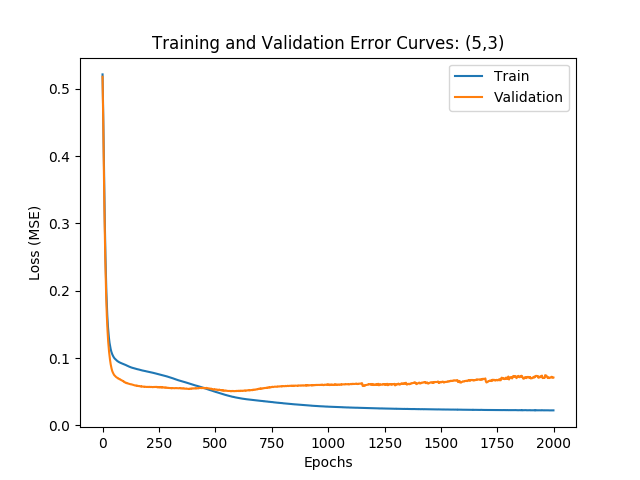

<IPython.core.display.Javascript object>


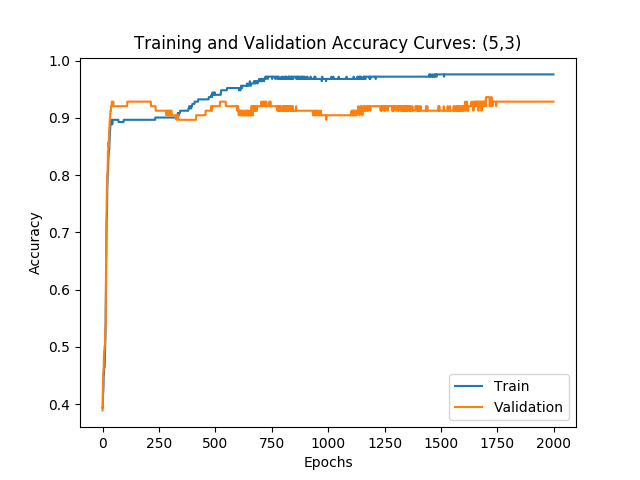

Matriz de confusão
[[1646  252]
 [   8   56]]

Train Loss:       0.0433
Validation Loss:  0.0506
Accuracy:         0.8675
MSE:              0.1325
AUROC:            0.9001


In [34]:
plot_training_error_curves(history, "(5,3)")
plot_training_acc_curves(history, "(5,3)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 5 (2)

In [35]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(2, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.3021 - acc: 0.5913 - val_loss: 0.3729 - val_acc: 0.5238
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.2894 - acc: 0.6111 - val_loss: 0.3605 - val_acc: 0.5317
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.2777 - acc: 0.6230 - val_loss: 0.3493 - val_acc: 0.5317
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.2668 - acc: 0.6429 - val_loss: 0.3396 - val_acc: 0.5714
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.2568 - acc: 0.6627 - val_loss: 0.3316 - val_acc: 0.6032
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.2479 - acc: 0.6667 - val_loss: 0.3238 - val_acc: 0.6349
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.2400 - acc: 0.6984 - val_loss: 0.3163 - val_acc: 0.6429
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.2318 - acc

252/252 [==============================] - 0s - loss: 0.1103 - acc: 0.8889 - val_loss: 0.1487 - val_acc: 0.8810
Epoch 66/2000
252/252 [==============================] - 0s - loss: 0.1097 - acc: 0.8889 - val_loss: 0.1477 - val_acc: 0.8810
Epoch 67/2000
252/252 [==============================] - 0s - loss: 0.1092 - acc: 0.8849 - val_loss: 0.1465 - val_acc: 0.8810
Epoch 68/2000
252/252 [==============================] - 0s - loss: 0.1086 - acc: 0.8849 - val_loss: 0.1457 - val_acc: 0.8810
Epoch 69/2000
252/252 [==============================] - 0s - loss: 0.1083 - acc: 0.8849 - val_loss: 0.1450 - val_acc: 0.8889
Epoch 70/2000
252/252 [==============================] - 0s - loss: 0.1078 - acc: 0.8849 - val_loss: 0.1439 - val_acc: 0.8889
Epoch 71/2000
252/252 [==============================] - 0s - loss: 0.1075 - acc: 0.8849 - val_loss: 0.1427 - val_acc: 0.8889
Epoch 72/2000
252/252 [==============================] - 0s - loss: 0.1069 - acc: 0.8849 - val_loss: 0.1420 - val_acc: 0.8889
Epoch 

252/252 [==============================] - 0s - loss: 0.0962 - acc: 0.8889 - val_loss: 0.1195 - val_acc: 0.9048
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.0962 - acc: 0.8889 - val_loss: 0.1196 - val_acc: 0.9048
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.0961 - acc: 0.8889 - val_loss: 0.1194 - val_acc: 0.9048
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.0960 - acc: 0.8929 - val_loss: 0.1193 - val_acc: 0.9048
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.0960 - acc: 0.8929 - val_loss: 0.1193 - val_acc: 0.9048
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.0958 - acc: 0.8968 - val_loss: 0.1190 - val_acc: 0.9048
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.0957 - acc: 0.8968 - val_loss: 0.1188 - val_acc: 0.9048
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.0957 - acc: 0.8968 - val_loss: 0.1190 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0932 - acc: 0.8849 - val_loss: 0.1182 - val_acc: 0.9048
Epoch 194/2000
252/252 [==============================] - 0s - loss: 0.0932 - acc: 0.8849 - val_loss: 0.1181 - val_acc: 0.9048
Epoch 195/2000
252/252 [==============================] - 0s - loss: 0.0932 - acc: 0.8849 - val_loss: 0.1181 - val_acc: 0.9048
Epoch 196/2000
252/252 [==============================] - 0s - loss: 0.0931 - acc: 0.8889 - val_loss: 0.1182 - val_acc: 0.9048
Epoch 197/2000
252/252 [==============================] - 0s - loss: 0.0931 - acc: 0.8889 - val_loss: 0.1180 - val_acc: 0.9048
Epoch 198/2000
252/252 [==============================] - 0s - loss: 0.0931 - acc: 0.8889 - val_loss: 0.1179 - val_acc: 0.9048
Epoch 199/2000
252/252 [==============================] - 0s - loss: 0.0931 - acc: 0.8889 - val_loss: 0.1181 - val_acc: 0.9048
Epoch 200/2000
252/252 [==============================] - 0s - loss: 0.0930 - acc: 0.8889 - val_loss: 0.1181 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0919 - acc: 0.9008 - val_loss: 0.1184 - val_acc: 0.9048
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0919 - acc: 0.8968 - val_loss: 0.1184 - val_acc: 0.9048
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0918 - acc: 0.8968 - val_loss: 0.1186 - val_acc: 0.9127
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0918 - acc: 0.8968 - val_loss: 0.1185 - val_acc: 0.9127
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0918 - acc: 0.8968 - val_loss: 0.1186 - val_acc: 0.9127
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0918 - acc: 0.8968 - val_loss: 0.1184 - val_acc: 0.9048
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0917 - acc: 0.9008 - val_loss: 0.1185 - val_acc: 0.9048
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0917 - acc: 0.9008 - val_loss: 0.1188 - val_acc: 0.9127

252/252 [==============================] - 0s - loss: 0.0913 - acc: 0.9008 - val_loss: 0.1182 - val_acc: 0.9127
Epoch 322/2000
252/252 [==============================] - 0s - loss: 0.0913 - acc: 0.8968 - val_loss: 0.1182 - val_acc: 0.9048
Epoch 323/2000
252/252 [==============================] - 0s - loss: 0.0913 - acc: 0.8968 - val_loss: 0.1182 - val_acc: 0.9127
Epoch 324/2000
252/252 [==============================] - 0s - loss: 0.0913 - acc: 0.9008 - val_loss: 0.1186 - val_acc: 0.9127
Epoch 325/2000
252/252 [==============================] - 0s - loss: 0.0913 - acc: 0.9008 - val_loss: 0.1186 - val_acc: 0.9127
Epoch 326/2000
252/252 [==============================] - 0s - loss: 0.0913 - acc: 0.9008 - val_loss: 0.1185 - val_acc: 0.9127
Epoch 327/2000
252/252 [==============================] - 0s - loss: 0.0913 - acc: 0.9008 - val_loss: 0.1187 - val_acc: 0.9127
Epoch 328/2000
252/252 [==============================] - 0s - loss: 0.0913 - acc: 0.8968 - val_loss: 0.1186 - val_acc: 0.9127

252/252 [==============================] - 0s - loss: 0.0911 - acc: 0.8929 - val_loss: 0.1184 - val_acc: 0.9127
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0912 - acc: 0.8929 - val_loss: 0.1182 - val_acc: 0.9127
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0911 - acc: 0.8929 - val_loss: 0.1185 - val_acc: 0.9127
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0912 - acc: 0.8929 - val_loss: 0.1187 - val_acc: 0.9127
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0911 - acc: 0.8929 - val_loss: 0.1189 - val_acc: 0.9127
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0911 - acc: 0.8929 - val_loss: 0.1188 - val_acc: 0.9048
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0911 - acc: 0.8929 - val_loss: 0.1185 - val_acc: 0.9127
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0911 - acc: 0.8929 - val_loss: 0.1182 - val_acc: 0.9127

252/252 [==============================] - 0s - loss: 0.0910 - acc: 0.8929 - val_loss: 0.1185 - val_acc: 0.9127
Epoch 450/2000
252/252 [==============================] - 0s - loss: 0.0910 - acc: 0.8929 - val_loss: 0.1184 - val_acc: 0.9127
Epoch 451/2000
252/252 [==============================] - 0s - loss: 0.0910 - acc: 0.8929 - val_loss: 0.1184 - val_acc: 0.9127
Epoch 452/2000
252/252 [==============================] - 0s - loss: 0.0910 - acc: 0.8929 - val_loss: 0.1185 - val_acc: 0.9127
Epoch 453/2000
252/252 [==============================] - 0s - loss: 0.0910 - acc: 0.8929 - val_loss: 0.1188 - val_acc: 0.9127
Epoch 454/2000
252/252 [==============================] - 0s - loss: 0.0910 - acc: 0.8929 - val_loss: 0.1188 - val_acc: 0.9127
Epoch 455/2000
252/252 [==============================] - 0s - loss: 0.0910 - acc: 0.8889 - val_loss: 0.1185 - val_acc: 0.9127
Epoch 456/2000
252/252 [==============================] - 0s - loss: 0.0910 - acc: 0.8889 - val_loss: 0.1185 - val_acc: 0.9127

252/252 [==============================] - 0s - loss: 0.0909 - acc: 0.8889 - val_loss: 0.1184 - val_acc: 0.9127
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0909 - acc: 0.8889 - val_loss: 0.1185 - val_acc: 0.9127
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0909 - acc: 0.8889 - val_loss: 0.1190 - val_acc: 0.9048
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.8889 - val_loss: 0.1190 - val_acc: 0.9048
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0909 - acc: 0.8849 - val_loss: 0.1189 - val_acc: 0.9048
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0909 - acc: 0.8889 - val_loss: 0.1189 - val_acc: 0.9048
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0909 - acc: 0.8889 - val_loss: 0.1186 - val_acc: 0.9127
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.8889 - val_loss: 0.1184 - val_acc: 0.9127

252/252 [==============================] - 0s - loss: 0.0907 - acc: 0.8889 - val_loss: 0.1193 - val_acc: 0.9048
Epoch 578/2000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.8889 - val_loss: 0.1195 - val_acc: 0.9048
Epoch 579/2000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.8889 - val_loss: 0.1196 - val_acc: 0.9048
Epoch 580/2000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.8889 - val_loss: 0.1192 - val_acc: 0.9048
Epoch 581/2000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.8889 - val_loss: 0.1191 - val_acc: 0.8968
Epoch 582/2000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.8889 - val_loss: 0.1192 - val_acc: 0.9048
Epoch 583/2000
252/252 [==============================] - 0s - loss: 0.0908 - acc: 0.8889 - val_loss: 0.1193 - val_acc: 0.9048
Epoch 584/2000
252/252 [==============================] - ETA: 0s - loss: 0.1172 - acc: 0.812 - 0s - loss: 0.0907 - acc: 0.888

252/252 [==============================] - 0s - loss: 0.0906 - acc: 0.8929 - val_loss: 0.1198 - val_acc: 0.9048
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0906 - acc: 0.8889 - val_loss: 0.1200 - val_acc: 0.8968
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0906 - acc: 0.8889 - val_loss: 0.1200 - val_acc: 0.8968
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0906 - acc: 0.8849 - val_loss: 0.1200 - val_acc: 0.8968
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0906 - acc: 0.8889 - val_loss: 0.1198 - val_acc: 0.8968
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0906 - acc: 0.8889 - val_loss: 0.1196 - val_acc: 0.8968
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0906 - acc: 0.8889 - val_loss: 0.1195 - val_acc: 0.8968
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0906 - acc: 0.8889 - val_loss: 0.1197 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0905 - acc: 0.8849 - val_loss: 0.1199 - val_acc: 0.8968
Epoch 706/2000
252/252 [==============================] - 0s - loss: 0.0905 - acc: 0.8889 - val_loss: 0.1195 - val_acc: 0.9048
Epoch 707/2000
252/252 [==============================] - 0s - loss: 0.0905 - acc: 0.8889 - val_loss: 0.1195 - val_acc: 0.9048
Epoch 708/2000
252/252 [==============================] - 0s - loss: 0.0905 - acc: 0.8889 - val_loss: 0.1195 - val_acc: 0.9048
Epoch 709/2000
252/252 [==============================] - 0s - loss: 0.0905 - acc: 0.8889 - val_loss: 0.1196 - val_acc: 0.9048
Epoch 710/2000
252/252 [==============================] - 0s - loss: 0.0905 - acc: 0.8889 - val_loss: 0.1194 - val_acc: 0.9048
Epoch 711/2000
252/252 [==============================] - 0s - loss: 0.0907 - acc: 0.8889 - val_loss: 0.1193 - val_acc: 0.9048
Epoch 712/2000
252/252 [==============================] - 0s - loss: 0.0905 - acc: 0.8889 - val_loss: 0.1197 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0905 - acc: 0.8889 - val_loss: 0.1198 - val_acc: 0.8968
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0904 - acc: 0.8889 - val_loss: 0.1197 - val_acc: 0.8968
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0904 - acc: 0.8889 - val_loss: 0.1198 - val_acc: 0.9048
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0904 - acc: 0.8889 - val_loss: 0.1200 - val_acc: 0.9048
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0905 - acc: 0.8889 - val_loss: 0.1203 - val_acc: 0.8968
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0904 - acc: 0.8849 - val_loss: 0.1203 - val_acc: 0.8968
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0904 - acc: 0.8889 - val_loss: 0.1201 - val_acc: 0.8968
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0904 - acc: 0.8889 - val_loss: 0.1199 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0904 - acc: 0.8889 - val_loss: 0.1205 - val_acc: 0.8968
Epoch 834/2000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8889 - val_loss: 0.1202 - val_acc: 0.8968
Epoch 835/2000
252/252 [==============================] - 0s - loss: 0.0904 - acc: 0.8889 - val_loss: 0.1204 - val_acc: 0.9048
Epoch 836/2000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8889 - val_loss: 0.1204 - val_acc: 0.9048
Epoch 837/2000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8889 - val_loss: 0.1206 - val_acc: 0.8968
Epoch 838/2000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8889 - val_loss: 0.1204 - val_acc: 0.8968
Epoch 839/2000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8889 - val_loss: 0.1200 - val_acc: 0.9048
Epoch 840/2000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8889 - val_loss: 0.1202 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8889 - val_loss: 0.1203 - val_acc: 0.9048
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8889 - val_loss: 0.1206 - val_acc: 0.9048
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8929 - val_loss: 0.1204 - val_acc: 0.9048
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8929 - val_loss: 0.1204 - val_acc: 0.9048
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8929 - val_loss: 0.1207 - val_acc: 0.9048
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8889 - val_loss: 0.1207 - val_acc: 0.8968
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8889 - val_loss: 0.1207 - val_acc: 0.8968
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8889 - val_loss: 0.1203 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8929 - val_loss: 0.1200 - val_acc: 0.9048
Epoch 962/2000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8929 - val_loss: 0.1202 - val_acc: 0.9048
Epoch 963/2000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8889 - val_loss: 0.1204 - val_acc: 0.8968
Epoch 964/2000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8889 - val_loss: 0.1206 - val_acc: 0.9048
Epoch 965/2000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8889 - val_loss: 0.1206 - val_acc: 0.8968
Epoch 966/2000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8889 - val_loss: 0.1209 - val_acc: 0.8968
Epoch 967/2000
252/252 [==============================] - 0s - loss: 0.0903 - acc: 0.8849 - val_loss: 0.1204 - val_acc: 0.9048
Epoch 968/2000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8889 - val_loss: 0.1207 - val_acc: 0.8968

252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8929 - val_loss: 0.1206 - val_acc: 0.9048
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8929 - val_loss: 0.1207 - val_acc: 0.9048
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8929 - val_loss: 0.1208 - val_acc: 0.9048
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8929 - val_loss: 0.1207 - val_acc: 0.9048
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8929 - val_loss: 0.1208 - val_acc: 0.9048
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8889 - val_loss: 0.1211 - val_acc: 0.8968
Epoch 1031/2000
252/252 [==============================] - ETA: 0s - loss: 0.1074 - acc: 0.875 - 0s - loss: 0.0902 - acc: 0.8889 - val_loss: 0.1209 - val_acc: 0.8968
Epoch 1032/2000
252/252 [==============================] - 0s - loss: 0.0902 - acc

252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8929 - val_loss: 0.1211 - val_acc: 0.9048
Epoch 1089/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8929 - val_loss: 0.1212 - val_acc: 0.9048
Epoch 1090/2000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8929 - val_loss: 0.1214 - val_acc: 0.8968
Epoch 1091/2000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8889 - val_loss: 0.1213 - val_acc: 0.8968
Epoch 1092/2000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8849 - val_loss: 0.1212 - val_acc: 0.8968
Epoch 1093/2000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8929 - val_loss: 0.1210 - val_acc: 0.9048
Epoch 1094/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8929 - val_loss: 0.1211 - val_acc: 0.9048
Epoch 1095/2000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8889 - val_loss: 0.1212 - val_acc:

252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8849 - val_loss: 0.1220 - val_acc: 0.8968
Epoch 1153/2000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8849 - val_loss: 0.1223 - val_acc: 0.8968
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8849 - val_loss: 0.1221 - val_acc: 0.8968
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8889 - val_loss: 0.1216 - val_acc: 0.9048
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8929 - val_loss: 0.1214 - val_acc: 0.8968
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8929 - val_loss: 0.1216 - val_acc: 0.9048
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8929 - val_loss: 0.1218 - val_acc: 0.9048
Epoch 1159/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8929 - val_loss: 0.1217 - val_acc:

252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8889 - val_loss: 0.1219 - val_acc: 0.8968
Epoch 1217/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8889 - val_loss: 0.1217 - val_acc: 0.9048
Epoch 1218/2000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8849 - val_loss: 0.1218 - val_acc: 0.8968
Epoch 1219/2000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8889 - val_loss: 0.1215 - val_acc: 0.9048
Epoch 1220/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8929 - val_loss: 0.1215 - val_acc: 0.9048
Epoch 1221/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8929 - val_loss: 0.1214 - val_acc: 0.9048
Epoch 1222/2000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8929 - val_loss: 0.1218 - val_acc: 0.8968
Epoch 1223/2000
252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8889 - val_loss: 0.1219 - val_acc:

252/252 [==============================] - 0s - loss: 0.0902 - acc: 0.8929 - val_loss: 0.1222 - val_acc: 0.9048
Epoch 1281/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8889 - val_loss: 0.1224 - val_acc: 0.8968
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8889 - val_loss: 0.1224 - val_acc: 0.9048
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8929 - val_loss: 0.1223 - val_acc: 0.9048
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8849 - val_loss: 0.1227 - val_acc: 0.8968
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8889 - val_loss: 0.1226 - val_acc: 0.9048
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8889 - val_loss: 0.1225 - val_acc: 0.8968
Epoch 1287/2000
252/252 [==============================] - 0s - loss: 0.0901 - acc: 0.8929 - val_loss: 0.1223 - val_acc:

252/252 [==============================] - 0s - loss: 0.0900 - acc: 0.8929 - val_loss: 0.1240 - val_acc: 0.8968
Epoch 1344/2000
252/252 [==============================] - 0s - loss: 0.0900 - acc: 0.8929 - val_loss: 0.1237 - val_acc: 0.9048
Epoch 1345/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8968 - val_loss: 0.1237 - val_acc: 0.9048
Epoch 1346/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8968 - val_loss: 0.1235 - val_acc: 0.9048
Epoch 1347/2000
252/252 [==============================] - 0s - loss: 0.0900 - acc: 0.8929 - val_loss: 0.1239 - val_acc: 0.9048
Epoch 1348/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8929 - val_loss: 0.1238 - val_acc: 0.9048
Epoch 1349/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8929 - val_loss: 0.1237 - val_acc: 0.9048
Epoch 1350/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8929 - val_loss: 0.1236 - val_acc:

252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1245 - val_acc: 0.9048
Epoch 1407/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8929 - val_loss: 0.1245 - val_acc: 0.9048
Epoch 1408/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8929 - val_loss: 0.1245 - val_acc: 0.8968
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8929 - val_loss: 0.1245 - val_acc: 0.9048
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8929 - val_loss: 0.1242 - val_acc: 0.9048
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8929 - val_loss: 0.1245 - val_acc: 0.9048
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8929 - val_loss: 0.1244 - val_acc: 0.9048
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8929 - val_loss: 0.1247 - val_acc:

252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8929 - val_loss: 0.1247 - val_acc: 0.9048
Epoch 1470/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8929 - val_loss: 0.1251 - val_acc: 0.9048
Epoch 1471/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1247 - val_acc: 0.9048
Epoch 1472/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8929 - val_loss: 0.1248 - val_acc: 0.9048
Epoch 1473/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1247 - val_acc: 0.9048
Epoch 1474/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1245 - val_acc: 0.9048
Epoch 1475/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1248 - val_acc: 0.9048
Epoch 1476/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8929 - val_loss: 0.1245 - val_acc:

252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1250 - val_acc: 0.9048
Epoch 1534/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1252 - val_acc: 0.9048
Epoch 1535/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1252 - val_acc: 0.9048
Epoch 1536/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1253 - val_acc: 0.9048
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1257 - val_acc: 0.9048
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1253 - val_acc: 0.9048
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1251 - val_acc: 0.9048
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1252 - val_acc:

252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1253 - val_acc: 0.9048
Epoch 1598/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1255 - val_acc: 0.9048
Epoch 1599/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1258 - val_acc: 0.9048
Epoch 1600/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1257 - val_acc: 0.9048
Epoch 1601/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1253 - val_acc: 0.9048
Epoch 1602/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1253 - val_acc: 0.9048
Epoch 1603/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8929 - val_loss: 0.1254 - val_acc: 0.9048
Epoch 1604/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8929 - val_loss: 0.1251 - val_acc:

252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1260 - val_acc: 0.9048
Epoch 1662/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8929 - val_loss: 0.1259 - val_acc: 0.9048
Epoch 1663/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1260 - val_acc: 0.8968
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8929 - val_loss: 0.1256 - val_acc: 0.9048
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1259 - val_acc: 0.9048
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1258 - val_acc: 0.9048
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1259 - val_acc: 0.9048
Epoch 1668/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1258 - val_acc:

252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1257 - val_acc: 0.9048
Epoch 1726/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1260 - val_acc: 0.9048
Epoch 1727/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1259 - val_acc: 0.9048
Epoch 1728/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1259 - val_acc: 0.9048
Epoch 1729/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8929 - val_loss: 0.1256 - val_acc: 0.8968
Epoch 1730/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1255 - val_acc: 0.9048
Epoch 1731/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1259 - val_acc: 0.8968
Epoch 1732/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1260 - val_acc:

252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8929 - val_loss: 0.1266 - val_acc: 0.9048
Epoch 1790/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1260 - val_acc: 0.9048
Epoch 1791/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1260 - val_acc: 0.9048
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1258 - val_acc: 0.9048
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1260 - val_acc: 0.9048
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8929 - val_loss: 0.1267 - val_acc: 0.9048
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1267 - val_acc: 0.9048
Epoch 1796/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1263 - val_acc:

252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1262 - val_acc: 0.9048
Epoch 1854/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1262 - val_acc: 0.9048
Epoch 1855/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1260 - val_acc: 0.9048
Epoch 1856/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1264 - val_acc: 0.9048
Epoch 1857/2000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8929 - val_loss: 0.1269 - val_acc: 0.9048
Epoch 1858/2000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8929 - val_loss: 0.1265 - val_acc: 0.9048
Epoch 1859/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1263 - val_acc: 0.9048
Epoch 1860/2000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8929 - val_loss: 0.1263 - val_acc:

252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8929 - val_loss: 0.1268 - val_acc: 0.9048
Epoch 1917/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8889 - val_loss: 0.1270 - val_acc: 0.8968
Epoch 1918/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1270 - val_acc: 0.9048
Epoch 1919/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1273 - val_acc: 0.9048
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1269 - val_acc: 0.9048
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1270 - val_acc: 0.9048
Epoch 1922/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1270 - val_acc: 0.9048
Epoch 1923/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1265 - val_acc:

252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1268 - val_acc: 0.9048
Epoch 1981/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1269 - val_acc: 0.9048
Epoch 1982/2000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8929 - val_loss: 0.1268 - val_acc: 0.9048
Epoch 1983/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1268 - val_acc: 0.9048
Epoch 1984/2000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8929 - val_loss: 0.1268 - val_acc: 0.9048
Epoch 1985/2000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8929 - val_loss: 0.1269 - val_acc: 0.9048
Epoch 1986/2000
252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8929 - val_loss: 0.1273 - val_acc: 0.9048
Epoch 1987/2000
252/252 [==============================] - 0s - loss: 0.0899 - acc: 0.8929 - val_loss: 0.1266 - val_acc:

In [36]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.08949543347356273, 0.89602446471028618]


<IPython.core.display.Javascript object>


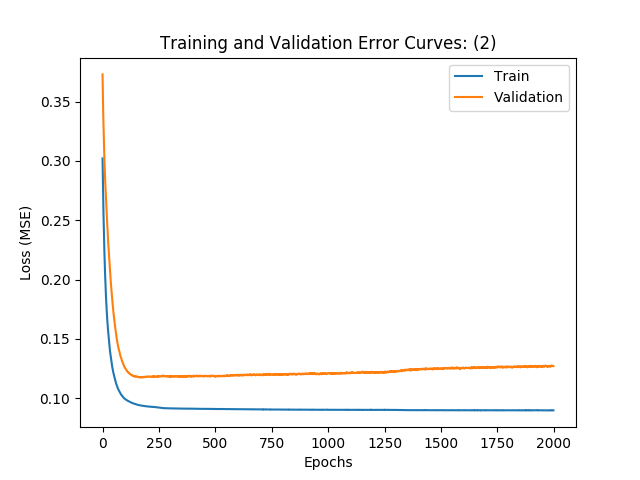

<IPython.core.display.Javascript object>


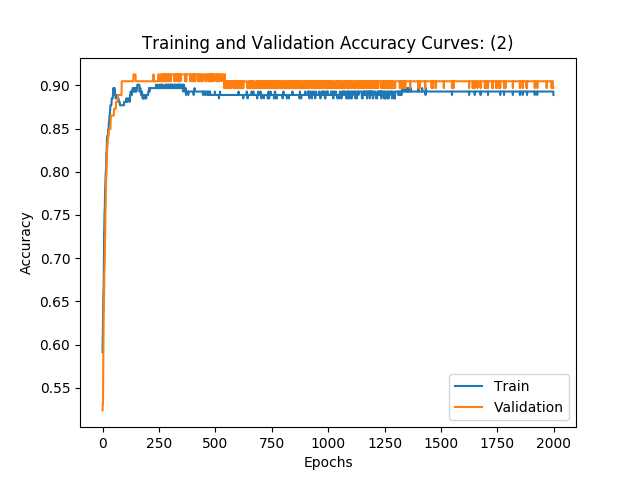

Matriz de confusão
[[1703  195]
 [   8   56]]

Train Loss:       0.0938
Validation Loss:  0.1174
Accuracy:         0.8965
MSE:              0.1035
AUROC:            0.9252


In [37]:
plot_training_error_curves(history, "(2)")
plot_training_acc_curves(history, "(2)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

## RNA 6 (4)

In [38]:
# Aq## RNA 5 (2)ui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(4, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 

adam = optimizers.Adam(lr=learnRate)
classifier.compile(optimizer=adam,
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))

Train on 252 samples, validate on 126 samples
Epoch 1/2000
252/252 [==============================] - 0s - loss: 0.7770 - acc: 0.5397 - val_loss: 0.6510 - val_acc: 0.6190
Epoch 2/2000
252/252 [==============================] - 0s - loss: 0.7184 - acc: 0.5794 - val_loss: 0.5958 - val_acc: 0.6270
Epoch 3/2000
252/252 [==============================] - 0s - loss: 0.6636 - acc: 0.6071 - val_loss: 0.5487 - val_acc: 0.6508
Epoch 4/2000
252/252 [==============================] - 0s - loss: 0.6147 - acc: 0.6190 - val_loss: 0.5085 - val_acc: 0.6429
Epoch 5/2000
252/252 [==============================] - 0s - loss: 0.5783 - acc: 0.6349 - val_loss: 0.4721 - val_acc: 0.6667
Epoch 6/2000
252/252 [==============================] - 0s - loss: 0.5368 - acc: 0.6429 - val_loss: 0.4440 - val_acc: 0.6825
Epoch 7/2000
252/252 [==============================] - 0s - loss: 0.5096 - acc: 0.6389 - val_loss: 0.4174 - val_acc: 0.7143
Epoch 8/2000
252/252 [==============================] - 0s - loss: 0.4844 - acc

252/252 [==============================] - 0s - loss: 0.1439 - acc: 0.8373 - val_loss: 0.1620 - val_acc: 0.8651
Epoch 66/2000
252/252 [==============================] - 0s - loss: 0.1429 - acc: 0.8373 - val_loss: 0.1610 - val_acc: 0.8651
Epoch 67/2000
252/252 [==============================] - 0s - loss: 0.1419 - acc: 0.8373 - val_loss: 0.1601 - val_acc: 0.8651
Epoch 68/2000
252/252 [==============================] - 0s - loss: 0.1409 - acc: 0.8413 - val_loss: 0.1594 - val_acc: 0.8651
Epoch 69/2000
252/252 [==============================] - 0s - loss: 0.1401 - acc: 0.8413 - val_loss: 0.1585 - val_acc: 0.8651
Epoch 70/2000
252/252 [==============================] - 0s - loss: 0.1393 - acc: 0.8413 - val_loss: 0.1578 - val_acc: 0.8651
Epoch 71/2000
252/252 [==============================] - 0s - loss: 0.1383 - acc: 0.8452 - val_loss: 0.1569 - val_acc: 0.8651
Epoch 72/2000
252/252 [==============================] - 0s - loss: 0.1376 - acc: 0.8452 - val_loss: 0.1558 - val_acc: 0.8651
Epoch 

252/252 [==============================] - 0s - loss: 0.1094 - acc: 0.8690 - val_loss: 0.1290 - val_acc: 0.8730
Epoch 130/2000
252/252 [==============================] - 0s - loss: 0.1091 - acc: 0.8690 - val_loss: 0.1288 - val_acc: 0.8730
Epoch 131/2000
252/252 [==============================] - 0s - loss: 0.1089 - acc: 0.8690 - val_loss: 0.1286 - val_acc: 0.8730
Epoch 132/2000
252/252 [==============================] - 0s - loss: 0.1087 - acc: 0.8690 - val_loss: 0.1286 - val_acc: 0.8730
Epoch 133/2000
252/252 [==============================] - 0s - loss: 0.1084 - acc: 0.8690 - val_loss: 0.1283 - val_acc: 0.8730
Epoch 134/2000
252/252 [==============================] - 0s - loss: 0.1081 - acc: 0.8690 - val_loss: 0.1283 - val_acc: 0.8730
Epoch 135/2000
252/252 [==============================] - 0s - loss: 0.1079 - acc: 0.8690 - val_loss: 0.1281 - val_acc: 0.8730
Epoch 136/2000
252/252 [==============================] - 0s - loss: 0.1078 - acc: 0.8690 - val_loss: 0.1282 - val_acc: 0.8730

252/252 [==============================] - 0s - loss: 0.0950 - acc: 0.8849 - val_loss: 0.1266 - val_acc: 0.8810
Epoch 194/2000
252/252 [==============================] - 0s - loss: 0.0949 - acc: 0.8889 - val_loss: 0.1263 - val_acc: 0.8810
Epoch 195/2000
252/252 [==============================] - 0s - loss: 0.0948 - acc: 0.8849 - val_loss: 0.1262 - val_acc: 0.8810
Epoch 196/2000
252/252 [==============================] - 0s - loss: 0.0947 - acc: 0.8849 - val_loss: 0.1260 - val_acc: 0.8810
Epoch 197/2000
252/252 [==============================] - 0s - loss: 0.0946 - acc: 0.8889 - val_loss: 0.1259 - val_acc: 0.8810
Epoch 198/2000
252/252 [==============================] - 0s - loss: 0.0945 - acc: 0.8889 - val_loss: 0.1257 - val_acc: 0.8810
Epoch 199/2000
252/252 [==============================] - 0s - loss: 0.0945 - acc: 0.8889 - val_loss: 0.1257 - val_acc: 0.8810
Epoch 200/2000
252/252 [==============================] - 0s - loss: 0.0944 - acc: 0.8889 - val_loss: 0.1258 - val_acc: 0.8810

252/252 [==============================] - 0s - loss: 0.0898 - acc: 0.8889 - val_loss: 0.1173 - val_acc: 0.8889
Epoch 258/2000
252/252 [==============================] - 0s - loss: 0.0897 - acc: 0.8889 - val_loss: 0.1173 - val_acc: 0.8889
Epoch 259/2000
252/252 [==============================] - 0s - loss: 0.0896 - acc: 0.8889 - val_loss: 0.1169 - val_acc: 0.8889
Epoch 260/2000
252/252 [==============================] - 0s - loss: 0.0894 - acc: 0.8889 - val_loss: 0.1166 - val_acc: 0.8889
Epoch 261/2000
252/252 [==============================] - 0s - loss: 0.0893 - acc: 0.8889 - val_loss: 0.1164 - val_acc: 0.8889
Epoch 262/2000
252/252 [==============================] - 0s - loss: 0.0892 - acc: 0.8929 - val_loss: 0.1161 - val_acc: 0.8889
Epoch 263/2000
252/252 [==============================] - 0s - loss: 0.0890 - acc: 0.8968 - val_loss: 0.1159 - val_acc: 0.8889
Epoch 264/2000
252/252 [==============================] - 0s - loss: 0.0888 - acc: 0.8968 - val_loss: 0.1157 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0752 - acc: 0.9087 - val_loss: 0.1020 - val_acc: 0.8889
Epoch 322/2000
252/252 [==============================] - ETA: 0s - loss: 0.0403 - acc: 0.968 - 0s - loss: 0.0751 - acc: 0.9087 - val_loss: 0.1018 - val_acc: 0.8889
Epoch 323/2000
252/252 [==============================] - 0s - loss: 0.0750 - acc: 0.9087 - val_loss: 0.1016 - val_acc: 0.8889
Epoch 324/2000
252/252 [==============================] - 0s - loss: 0.0748 - acc: 0.9087 - val_loss: 0.1013 - val_acc: 0.8889
Epoch 325/2000
252/252 [==============================] - 0s - loss: 0.0746 - acc: 0.9087 - val_loss: 0.1011 - val_acc: 0.8889
Epoch 326/2000
252/252 [==============================] - 0s - loss: 0.0745 - acc: 0.9087 - val_loss: 0.1011 - val_acc: 0.8889
Epoch 327/2000
252/252 [==============================] - 0s - loss: 0.0744 - acc: 0.9127 - val_loss: 0.1013 - val_acc: 0.8968
Epoch 328/2000
252/252 [==============================] - 0s - loss: 0.0742 - acc: 0.912

252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9286 - val_loss: 0.0935 - val_acc: 0.8889
Epoch 386/2000
252/252 [==============================] - 0s - loss: 0.0685 - acc: 0.9286 - val_loss: 0.0935 - val_acc: 0.8889
Epoch 387/2000
252/252 [==============================] - 0s - loss: 0.0684 - acc: 0.9286 - val_loss: 0.0935 - val_acc: 0.8889
Epoch 388/2000
252/252 [==============================] - 0s - loss: 0.0683 - acc: 0.9286 - val_loss: 0.0934 - val_acc: 0.8889
Epoch 389/2000
252/252 [==============================] - 0s - loss: 0.0683 - acc: 0.9286 - val_loss: 0.0934 - val_acc: 0.8889
Epoch 390/2000
252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9286 - val_loss: 0.0934 - val_acc: 0.8889
Epoch 391/2000
252/252 [==============================] - 0s - loss: 0.0682 - acc: 0.9286 - val_loss: 0.0932 - val_acc: 0.8889
Epoch 392/2000
252/252 [==============================] - 0s - loss: 0.0681 - acc: 0.9286 - val_loss: 0.0930 - val_acc: 0.8889

252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9325 - val_loss: 0.0908 - val_acc: 0.8968
Epoch 450/2000
252/252 [==============================] - 0s - loss: 0.0661 - acc: 0.9325 - val_loss: 0.0906 - val_acc: 0.8968
Epoch 451/2000
252/252 [==============================] - 0s - loss: 0.0660 - acc: 0.9325 - val_loss: 0.0907 - val_acc: 0.8968
Epoch 452/2000
252/252 [==============================] - 0s - loss: 0.0659 - acc: 0.9325 - val_loss: 0.0906 - val_acc: 0.8968
Epoch 453/2000
252/252 [==============================] - 0s - loss: 0.0659 - acc: 0.9325 - val_loss: 0.0906 - val_acc: 0.8968
Epoch 454/2000
252/252 [==============================] - 0s - loss: 0.0659 - acc: 0.9325 - val_loss: 0.0904 - val_acc: 0.8968
Epoch 455/2000
252/252 [==============================] - 0s - loss: 0.0659 - acc: 0.9325 - val_loss: 0.0902 - val_acc: 0.9048
Epoch 456/2000
252/252 [==============================] - 0s - loss: 0.0658 - acc: 0.9325 - val_loss: 0.0905 - val_acc: 0.8968

252/252 [==============================] - 0s - loss: 0.0646 - acc: 0.9286 - val_loss: 0.0898 - val_acc: 0.9127
Epoch 514/2000
252/252 [==============================] - 0s - loss: 0.0645 - acc: 0.9286 - val_loss: 0.0897 - val_acc: 0.9127
Epoch 515/2000
252/252 [==============================] - 0s - loss: 0.0645 - acc: 0.9286 - val_loss: 0.0897 - val_acc: 0.9127
Epoch 516/2000
252/252 [==============================] - 0s - loss: 0.0645 - acc: 0.9286 - val_loss: 0.0896 - val_acc: 0.9127
Epoch 517/2000
252/252 [==============================] - 0s - loss: 0.0646 - acc: 0.9286 - val_loss: 0.0896 - val_acc: 0.9127
Epoch 518/2000
252/252 [==============================] - 0s - loss: 0.0644 - acc: 0.9286 - val_loss: 0.0898 - val_acc: 0.9127
Epoch 519/2000
252/252 [==============================] - 0s - loss: 0.0644 - acc: 0.9286 - val_loss: 0.0900 - val_acc: 0.9127
Epoch 520/2000
252/252 [==============================] - 0s - loss: 0.0645 - acc: 0.9286 - val_loss: 0.0902 - val_acc: 0.9127

252/252 [==============================] - 0s - loss: 0.0636 - acc: 0.9325 - val_loss: 0.0898 - val_acc: 0.9127
Epoch 578/2000
252/252 [==============================] - 0s - loss: 0.0635 - acc: 0.9325 - val_loss: 0.0896 - val_acc: 0.9127
Epoch 579/2000
252/252 [==============================] - 0s - loss: 0.0635 - acc: 0.9325 - val_loss: 0.0897 - val_acc: 0.9127
Epoch 580/2000
252/252 [==============================] - 0s - loss: 0.0635 - acc: 0.9325 - val_loss: 0.0894 - val_acc: 0.9127
Epoch 581/2000
252/252 [==============================] - 0s - loss: 0.0635 - acc: 0.9325 - val_loss: 0.0896 - val_acc: 0.9127
Epoch 582/2000
252/252 [==============================] - 0s - loss: 0.0634 - acc: 0.9325 - val_loss: 0.0896 - val_acc: 0.9127
Epoch 583/2000
252/252 [==============================] - 0s - loss: 0.0634 - acc: 0.9325 - val_loss: 0.0897 - val_acc: 0.9127
Epoch 584/2000
252/252 [==============================] - 0s - loss: 0.0634 - acc: 0.9325 - val_loss: 0.0896 - val_acc: 0.9127

252/252 [==============================] - 0s - loss: 0.0629 - acc: 0.9246 - val_loss: 0.0893 - val_acc: 0.9127
Epoch 642/2000
252/252 [==============================] - 0s - loss: 0.0628 - acc: 0.9246 - val_loss: 0.0892 - val_acc: 0.9127
Epoch 643/2000
252/252 [==============================] - 0s - loss: 0.0628 - acc: 0.9246 - val_loss: 0.0891 - val_acc: 0.9127
Epoch 644/2000
252/252 [==============================] - 0s - loss: 0.0628 - acc: 0.9286 - val_loss: 0.0890 - val_acc: 0.9127
Epoch 645/2000
252/252 [==============================] - 0s - loss: 0.0628 - acc: 0.9286 - val_loss: 0.0890 - val_acc: 0.9127
Epoch 646/2000
252/252 [==============================] - 0s - loss: 0.0628 - acc: 0.9246 - val_loss: 0.0890 - val_acc: 0.9127
Epoch 647/2000
252/252 [==============================] - 0s - loss: 0.0629 - acc: 0.9286 - val_loss: 0.0889 - val_acc: 0.9127
Epoch 648/2000
252/252 [==============================] - 0s - loss: 0.0629 - acc: 0.9246 - val_loss: 0.0890 - val_acc: 0.9127

252/252 [==============================] - 0s - loss: 0.0624 - acc: 0.9325 - val_loss: 0.0883 - val_acc: 0.9048
Epoch 706/2000
252/252 [==============================] - 0s - loss: 0.0624 - acc: 0.9325 - val_loss: 0.0884 - val_acc: 0.9048
Epoch 707/2000
252/252 [==============================] - 0s - loss: 0.0623 - acc: 0.9246 - val_loss: 0.0885 - val_acc: 0.9127
Epoch 708/2000
252/252 [==============================] - 0s - loss: 0.0623 - acc: 0.9246 - val_loss: 0.0886 - val_acc: 0.9127
Epoch 709/2000
252/252 [==============================] - 0s - loss: 0.0624 - acc: 0.9246 - val_loss: 0.0887 - val_acc: 0.9127
Epoch 710/2000
252/252 [==============================] - 0s - loss: 0.0623 - acc: 0.9246 - val_loss: 0.0886 - val_acc: 0.9127
Epoch 711/2000
252/252 [==============================] - 0s - loss: 0.0623 - acc: 0.9286 - val_loss: 0.0884 - val_acc: 0.9048
Epoch 712/2000
252/252 [==============================] - 0s - loss: 0.0623 - acc: 0.9286 - val_loss: 0.0886 - val_acc: 0.9127

252/252 [==============================] - 0s - loss: 0.0616 - acc: 0.9286 - val_loss: 0.0880 - val_acc: 0.9048
Epoch 770/2000
252/252 [==============================] - 0s - loss: 0.0615 - acc: 0.9286 - val_loss: 0.0878 - val_acc: 0.9048
Epoch 771/2000
252/252 [==============================] - 0s - loss: 0.0615 - acc: 0.9325 - val_loss: 0.0878 - val_acc: 0.9048
Epoch 772/2000
252/252 [==============================] - 0s - loss: 0.0616 - acc: 0.9325 - val_loss: 0.0879 - val_acc: 0.9048
Epoch 773/2000
252/252 [==============================] - 0s - loss: 0.0615 - acc: 0.9325 - val_loss: 0.0881 - val_acc: 0.9048
Epoch 774/2000
252/252 [==============================] - 0s - loss: 0.0615 - acc: 0.9286 - val_loss: 0.0882 - val_acc: 0.9048
Epoch 775/2000
252/252 [==============================] - 0s - loss: 0.0616 - acc: 0.9286 - val_loss: 0.0884 - val_acc: 0.9048
Epoch 776/2000
252/252 [==============================] - 0s - loss: 0.0615 - acc: 0.9286 - val_loss: 0.0881 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0613 - acc: 0.9325 - val_loss: 0.0882 - val_acc: 0.9048
Epoch 834/2000
252/252 [==============================] - 0s - loss: 0.0613 - acc: 0.9325 - val_loss: 0.0884 - val_acc: 0.9048
Epoch 835/2000
252/252 [==============================] - 0s - loss: 0.0612 - acc: 0.9325 - val_loss: 0.0882 - val_acc: 0.9048
Epoch 836/2000
252/252 [==============================] - 0s - loss: 0.0612 - acc: 0.9325 - val_loss: 0.0883 - val_acc: 0.9048
Epoch 837/2000
252/252 [==============================] - 0s - loss: 0.0612 - acc: 0.9325 - val_loss: 0.0884 - val_acc: 0.9048
Epoch 838/2000
252/252 [==============================] - 0s - loss: 0.0612 - acc: 0.9325 - val_loss: 0.0884 - val_acc: 0.9048
Epoch 839/2000
252/252 [==============================] - 0s - loss: 0.0612 - acc: 0.9325 - val_loss: 0.0885 - val_acc: 0.9048
Epoch 840/2000
252/252 [==============================] - 0s - loss: 0.0612 - acc: 0.9325 - val_loss: 0.0884 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0611 - acc: 0.9325 - val_loss: 0.0887 - val_acc: 0.9048
Epoch 898/2000
252/252 [==============================] - 0s - loss: 0.0610 - acc: 0.9325 - val_loss: 0.0886 - val_acc: 0.9048
Epoch 899/2000
252/252 [==============================] - 0s - loss: 0.0611 - acc: 0.9325 - val_loss: 0.0884 - val_acc: 0.9048
Epoch 900/2000
252/252 [==============================] - 0s - loss: 0.0611 - acc: 0.9325 - val_loss: 0.0888 - val_acc: 0.9048
Epoch 901/2000
252/252 [==============================] - 0s - loss: 0.0611 - acc: 0.9325 - val_loss: 0.0887 - val_acc: 0.9048
Epoch 902/2000
252/252 [==============================] - 0s - loss: 0.0611 - acc: 0.9325 - val_loss: 0.0885 - val_acc: 0.9048
Epoch 903/2000
252/252 [==============================] - 0s - loss: 0.0610 - acc: 0.9325 - val_loss: 0.0886 - val_acc: 0.9048
Epoch 904/2000
252/252 [==============================] - 0s - loss: 0.0611 - acc: 0.9325 - val_loss: 0.0884 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0609 - acc: 0.9325 - val_loss: 0.0890 - val_acc: 0.9048
Epoch 962/2000
252/252 [==============================] - 0s - loss: 0.0609 - acc: 0.9325 - val_loss: 0.0888 - val_acc: 0.9048
Epoch 963/2000
252/252 [==============================] - 0s - loss: 0.0609 - acc: 0.9325 - val_loss: 0.0889 - val_acc: 0.9048
Epoch 964/2000
252/252 [==============================] - 0s - loss: 0.0610 - acc: 0.9325 - val_loss: 0.0886 - val_acc: 0.8968
Epoch 965/2000
252/252 [==============================] - 0s - loss: 0.0610 - acc: 0.9325 - val_loss: 0.0885 - val_acc: 0.8968
Epoch 966/2000
252/252 [==============================] - 0s - loss: 0.0611 - acc: 0.9325 - val_loss: 0.0891 - val_acc: 0.9048
Epoch 967/2000
252/252 [==============================] - 0s - loss: 0.0609 - acc: 0.9325 - val_loss: 0.0892 - val_acc: 0.9048
Epoch 968/2000
252/252 [==============================] - 0s - loss: 0.0609 - acc: 0.9325 - val_loss: 0.0889 - val_acc: 0.9048

252/252 [==============================] - 0s - loss: 0.0609 - acc: 0.9325 - val_loss: 0.0890 - val_acc: 0.8968
Epoch 1026/2000
252/252 [==============================] - 0s - loss: 0.0607 - acc: 0.9325 - val_loss: 0.0889 - val_acc: 0.8968
Epoch 1027/2000
252/252 [==============================] - 0s - loss: 0.0607 - acc: 0.9325 - val_loss: 0.0891 - val_acc: 0.8968
Epoch 1028/2000
252/252 [==============================] - 0s - loss: 0.0608 - acc: 0.9325 - val_loss: 0.0892 - val_acc: 0.8968
Epoch 1029/2000
252/252 [==============================] - 0s - loss: 0.0608 - acc: 0.9325 - val_loss: 0.0891 - val_acc: 0.8968
Epoch 1030/2000
252/252 [==============================] - 0s - loss: 0.0608 - acc: 0.9325 - val_loss: 0.0891 - val_acc: 0.8968
Epoch 1031/2000
252/252 [==============================] - 0s - loss: 0.0608 - acc: 0.9325 - val_loss: 0.0892 - val_acc: 0.8968
Epoch 1032/2000
252/252 [==============================] - 0s - loss: 0.0608 - acc: 0.9325 - val_loss: 0.0890 - val_acc:

252/252 [==============================] - 0s - loss: 0.0607 - acc: 0.9325 - val_loss: 0.0892 - val_acc: 0.8889
Epoch 1090/2000
252/252 [==============================] - 0s - loss: 0.0607 - acc: 0.9325 - val_loss: 0.0894 - val_acc: 0.8889
Epoch 1091/2000
252/252 [==============================] - 0s - loss: 0.0607 - acc: 0.9325 - val_loss: 0.0891 - val_acc: 0.8889
Epoch 1092/2000
252/252 [==============================] - 0s - loss: 0.0606 - acc: 0.9325 - val_loss: 0.0892 - val_acc: 0.8889
Epoch 1093/2000
252/252 [==============================] - 0s - loss: 0.0607 - acc: 0.9325 - val_loss: 0.0892 - val_acc: 0.8889
Epoch 1094/2000
252/252 [==============================] - 0s - loss: 0.0606 - acc: 0.9325 - val_loss: 0.0893 - val_acc: 0.8889
Epoch 1095/2000
252/252 [==============================] - 0s - loss: 0.0606 - acc: 0.9325 - val_loss: 0.0896 - val_acc: 0.8889
Epoch 1096/2000
252/252 [==============================] - 0s - loss: 0.0606 - acc: 0.9325 - val_loss: 0.0895 - val_acc:

252/252 [==============================] - 0s - loss: 0.0606 - acc: 0.9325 - val_loss: 0.0899 - val_acc: 0.8889
Epoch 1154/2000
252/252 [==============================] - 0s - loss: 0.0605 - acc: 0.9325 - val_loss: 0.0899 - val_acc: 0.8889
Epoch 1155/2000
252/252 [==============================] - 0s - loss: 0.0606 - acc: 0.9325 - val_loss: 0.0900 - val_acc: 0.8889
Epoch 1156/2000
252/252 [==============================] - 0s - loss: 0.0605 - acc: 0.9325 - val_loss: 0.0900 - val_acc: 0.8889
Epoch 1157/2000
252/252 [==============================] - 0s - loss: 0.0606 - acc: 0.9325 - val_loss: 0.0897 - val_acc: 0.8889
Epoch 1158/2000
252/252 [==============================] - 0s - loss: 0.0606 - acc: 0.9325 - val_loss: 0.0897 - val_acc: 0.8889
Epoch 1159/2000
252/252 [==============================] - ETA: 0s - loss: 0.1123 - acc: 0.875 - 0s - loss: 0.0605 - acc: 0.9325 - val_loss: 0.0900 - val_acc: 0.8889
Epoch 1160/2000
252/252 [==============================] - 0s - loss: 0.0605 - acc

252/252 [==============================] - 0s - loss: 0.0605 - acc: 0.9325 - val_loss: 0.0901 - val_acc: 0.8889
Epoch 1217/2000
252/252 [==============================] - 0s - loss: 0.0604 - acc: 0.9325 - val_loss: 0.0902 - val_acc: 0.8889
Epoch 1218/2000
252/252 [==============================] - 0s - loss: 0.0604 - acc: 0.9325 - val_loss: 0.0901 - val_acc: 0.8889
Epoch 1219/2000
252/252 [==============================] - 0s - loss: 0.0604 - acc: 0.9325 - val_loss: 0.0899 - val_acc: 0.8889
Epoch 1220/2000
252/252 [==============================] - 0s - loss: 0.0604 - acc: 0.9325 - val_loss: 0.0901 - val_acc: 0.8889
Epoch 1221/2000
252/252 [==============================] - 0s - loss: 0.0604 - acc: 0.9325 - val_loss: 0.0900 - val_acc: 0.8889
Epoch 1222/2000
252/252 [==============================] - 0s - loss: 0.0604 - acc: 0.9325 - val_loss: 0.0902 - val_acc: 0.8889
Epoch 1223/2000
252/252 [==============================] - 0s - loss: 0.0604 - acc: 0.9325 - val_loss: 0.0902 - val_acc:

252/252 [==============================] - 0s - loss: 0.0604 - acc: 0.9325 - val_loss: 0.0903 - val_acc: 0.8889
Epoch 1280/2000
252/252 [==============================] - 0s - loss: 0.0603 - acc: 0.9325 - val_loss: 0.0902 - val_acc: 0.8889
Epoch 1281/2000
252/252 [==============================] - 0s - loss: 0.0603 - acc: 0.9325 - val_loss: 0.0899 - val_acc: 0.8889
Epoch 1282/2000
252/252 [==============================] - 0s - loss: 0.0603 - acc: 0.9325 - val_loss: 0.0898 - val_acc: 0.8889
Epoch 1283/2000
252/252 [==============================] - 0s - loss: 0.0604 - acc: 0.9325 - val_loss: 0.0899 - val_acc: 0.8889
Epoch 1284/2000
252/252 [==============================] - 0s - loss: 0.0603 - acc: 0.9325 - val_loss: 0.0903 - val_acc: 0.8889
Epoch 1285/2000
252/252 [==============================] - 0s - loss: 0.0603 - acc: 0.9325 - val_loss: 0.0903 - val_acc: 0.8889
Epoch 1286/2000
252/252 [==============================] - 0s - loss: 0.0604 - acc: 0.9325 - val_loss: 0.0904 - val_acc:

252/252 [==============================] - 0s - loss: 0.0602 - acc: 0.9325 - val_loss: 0.0902 - val_acc: 0.8889
Epoch 1344/2000
252/252 [==============================] - 0s - loss: 0.0602 - acc: 0.9325 - val_loss: 0.0904 - val_acc: 0.8889
Epoch 1345/2000
252/252 [==============================] - 0s - loss: 0.0602 - acc: 0.9325 - val_loss: 0.0904 - val_acc: 0.8810
Epoch 1346/2000
252/252 [==============================] - 0s - loss: 0.0602 - acc: 0.9325 - val_loss: 0.0905 - val_acc: 0.8810
Epoch 1347/2000
252/252 [==============================] - 0s - loss: 0.0602 - acc: 0.9325 - val_loss: 0.0905 - val_acc: 0.8810
Epoch 1348/2000
252/252 [==============================] - 0s - loss: 0.0602 - acc: 0.9325 - val_loss: 0.0902 - val_acc: 0.8889
Epoch 1349/2000
252/252 [==============================] - 0s - loss: 0.0602 - acc: 0.9325 - val_loss: 0.0903 - val_acc: 0.8810
Epoch 1350/2000
252/252 [==============================] - 0s - loss: 0.0603 - acc: 0.9325 - val_loss: 0.0905 - val_acc:

252/252 [==============================] - 0s - loss: 0.0602 - acc: 0.9325 - val_loss: 0.0906 - val_acc: 0.8810
Epoch 1408/2000
252/252 [==============================] - 0s - loss: 0.0601 - acc: 0.9325 - val_loss: 0.0906 - val_acc: 0.8810
Epoch 1409/2000
252/252 [==============================] - 0s - loss: 0.0601 - acc: 0.9325 - val_loss: 0.0905 - val_acc: 0.8810
Epoch 1410/2000
252/252 [==============================] - 0s - loss: 0.0601 - acc: 0.9325 - val_loss: 0.0903 - val_acc: 0.8810
Epoch 1411/2000
252/252 [==============================] - 0s - loss: 0.0602 - acc: 0.9325 - val_loss: 0.0902 - val_acc: 0.8889
Epoch 1412/2000
252/252 [==============================] - 0s - loss: 0.0602 - acc: 0.9325 - val_loss: 0.0904 - val_acc: 0.8810
Epoch 1413/2000
252/252 [==============================] - 0s - loss: 0.0603 - acc: 0.9325 - val_loss: 0.0901 - val_acc: 0.8889
Epoch 1414/2000
252/252 [==============================] - 0s - loss: 0.0602 - acc: 0.9325 - val_loss: 0.0900 - val_acc:

252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9325 - val_loss: 0.0906 - val_acc: 0.8810
Epoch 1472/2000
252/252 [==============================] - 0s - loss: 0.0601 - acc: 0.9325 - val_loss: 0.0904 - val_acc: 0.8810
Epoch 1473/2000
252/252 [==============================] - 0s - loss: 0.0602 - acc: 0.9325 - val_loss: 0.0907 - val_acc: 0.8810
Epoch 1474/2000
252/252 [==============================] - 0s - loss: 0.0601 - acc: 0.9325 - val_loss: 0.0908 - val_acc: 0.8810
Epoch 1475/2000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9325 - val_loss: 0.0905 - val_acc: 0.8889
Epoch 1476/2000
252/252 [==============================] - ETA: 0s - loss: 0.0154 - acc: 1.000 - 0s - loss: 0.0601 - acc: 0.9325 - val_loss: 0.0905 - val_acc: 0.8810
Epoch 1477/2000
252/252 [==============================] - 0s - loss: 0.0602 - acc: 0.9325 - val_loss: 0.0902 - val_acc: 0.8810
Epoch 1478/2000
252/252 [==============================] - 0s - loss: 0.0600 - acc

252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9325 - val_loss: 0.0910 - val_acc: 0.8810
Epoch 1535/2000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9325 - val_loss: 0.0909 - val_acc: 0.8810
Epoch 1536/2000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9325 - val_loss: 0.0909 - val_acc: 0.8889
Epoch 1537/2000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9325 - val_loss: 0.0908 - val_acc: 0.8889
Epoch 1538/2000
252/252 [==============================] - 0s - loss: 0.0601 - acc: 0.9325 - val_loss: 0.0907 - val_acc: 0.8889
Epoch 1539/2000
252/252 [==============================] - 0s - loss: 0.0601 - acc: 0.9325 - val_loss: 0.0910 - val_acc: 0.8810
Epoch 1540/2000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9325 - val_loss: 0.0909 - val_acc: 0.8810
Epoch 1541/2000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9325 - val_loss: 0.0910 - val_acc:

252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9325 - val_loss: 0.0910 - val_acc: 0.8889
Epoch 1598/2000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9325 - val_loss: 0.0909 - val_acc: 0.8889
Epoch 1599/2000
252/252 [==============================] - 0s - loss: 0.0601 - acc: 0.9325 - val_loss: 0.0912 - val_acc: 0.8810
Epoch 1600/2000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9325 - val_loss: 0.0912 - val_acc: 0.8810
Epoch 1601/2000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9325 - val_loss: 0.0912 - val_acc: 0.8889
Epoch 1602/2000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9325 - val_loss: 0.0911 - val_acc: 0.8889
Epoch 1603/2000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9325 - val_loss: 0.0908 - val_acc: 0.8889
Epoch 1604/2000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9325 - val_loss: 0.0908 - val_acc:

252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9325 - val_loss: 0.0913 - val_acc: 0.8889
Epoch 1661/2000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9325 - val_loss: 0.0914 - val_acc: 0.8889
Epoch 1662/2000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9325 - val_loss: 0.0911 - val_acc: 0.8889
Epoch 1663/2000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9325 - val_loss: 0.0912 - val_acc: 0.8889
Epoch 1664/2000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9325 - val_loss: 0.0913 - val_acc: 0.8889
Epoch 1665/2000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9325 - val_loss: 0.0910 - val_acc: 0.8889
Epoch 1666/2000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9325 - val_loss: 0.0913 - val_acc: 0.8889
Epoch 1667/2000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9325 - val_loss: 0.0913 - val_acc:

252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9325 - val_loss: 0.0917 - val_acc: 0.8889
Epoch 1725/2000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9325 - val_loss: 0.0914 - val_acc: 0.8889
Epoch 1726/2000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9325 - val_loss: 0.0913 - val_acc: 0.8889
Epoch 1727/2000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9325 - val_loss: 0.0915 - val_acc: 0.8889
Epoch 1728/2000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9325 - val_loss: 0.0916 - val_acc: 0.8889
Epoch 1729/2000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9325 - val_loss: 0.0915 - val_acc: 0.8889
Epoch 1730/2000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9325 - val_loss: 0.0917 - val_acc: 0.8889
Epoch 1731/2000
252/252 [==============================] - 0s - loss: 0.0601 - acc: 0.9325 - val_loss: 0.0919 - val_acc:

252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9325 - val_loss: 0.0920 - val_acc: 0.8889
Epoch 1789/2000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9325 - val_loss: 0.0917 - val_acc: 0.8889
Epoch 1790/2000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9325 - val_loss: 0.0919 - val_acc: 0.8889
Epoch 1791/2000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9325 - val_loss: 0.0917 - val_acc: 0.8889
Epoch 1792/2000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9325 - val_loss: 0.0918 - val_acc: 0.8889
Epoch 1793/2000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9325 - val_loss: 0.0918 - val_acc: 0.8889
Epoch 1794/2000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9325 - val_loss: 0.0919 - val_acc: 0.8889
Epoch 1795/2000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9325 - val_loss: 0.0917 - val_acc:

252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9325 - val_loss: 0.0919 - val_acc: 0.8889
Epoch 1853/2000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9325 - val_loss: 0.0918 - val_acc: 0.8889
Epoch 1854/2000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9325 - val_loss: 0.0919 - val_acc: 0.8889
Epoch 1855/2000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9325 - val_loss: 0.0917 - val_acc: 0.8889
Epoch 1856/2000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9325 - val_loss: 0.0917 - val_acc: 0.8889
Epoch 1857/2000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9325 - val_loss: 0.0918 - val_acc: 0.8889
Epoch 1858/2000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9325 - val_loss: 0.0918 - val_acc: 0.8889
Epoch 1859/2000
252/252 [==============================] - 0s - loss: 0.0600 - acc: 0.9325 - val_loss: 0.0922 - val_acc:

252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9325 - val_loss: 0.0922 - val_acc: 0.8889
Epoch 1917/2000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9325 - val_loss: 0.0922 - val_acc: 0.8889
Epoch 1918/2000
252/252 [==============================] - 0s - loss: 0.0598 - acc: 0.9325 - val_loss: 0.0922 - val_acc: 0.8889
Epoch 1919/2000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9325 - val_loss: 0.0923 - val_acc: 0.8889
Epoch 1920/2000
252/252 [==============================] - 0s - loss: 0.0598 - acc: 0.9325 - val_loss: 0.0922 - val_acc: 0.8889
Epoch 1921/2000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9325 - val_loss: 0.0920 - val_acc: 0.8889
Epoch 1922/2000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9325 - val_loss: 0.0919 - val_acc: 0.8889
Epoch 1923/2000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9325 - val_loss: 0.0921 - val_acc:

252/252 [==============================] - 0s - loss: 0.0598 - acc: 0.9325 - val_loss: 0.0924 - val_acc: 0.8889
Epoch 1980/2000
252/252 [==============================] - 0s - loss: 0.0598 - acc: 0.9325 - val_loss: 0.0924 - val_acc: 0.8889
Epoch 1981/2000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9325 - val_loss: 0.0921 - val_acc: 0.8889
Epoch 1982/2000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9325 - val_loss: 0.0921 - val_acc: 0.8889
Epoch 1983/2000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9325 - val_loss: 0.0924 - val_acc: 0.8889
Epoch 1984/2000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9325 - val_loss: 0.0922 - val_acc: 0.8889
Epoch 1985/2000
252/252 [==============================] - 0s - loss: 0.0598 - acc: 0.9325 - val_loss: 0.0924 - val_acc: 0.8889
Epoch 1986/2000
252/252 [==============================] - 0s - loss: 0.0599 - acc: 0.9325 - val_loss: 0.0922 - val_acc:

In [39]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

  32/1962 [..............................] - ETA: 0s[0.086874268128784418, 0.88481141698226773]


<IPython.core.display.Javascript object>


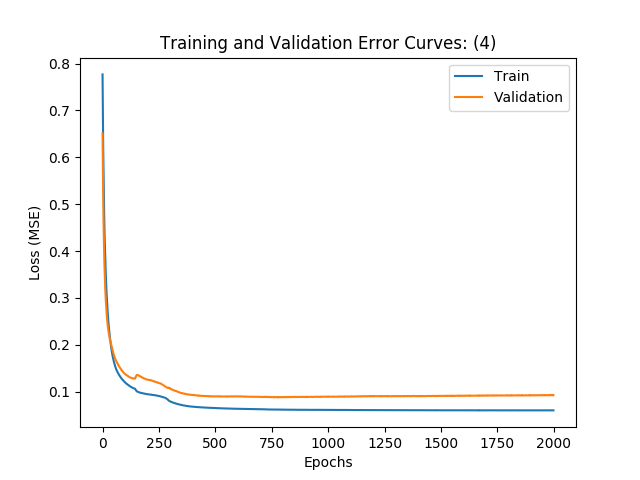

<IPython.core.display.Javascript object>


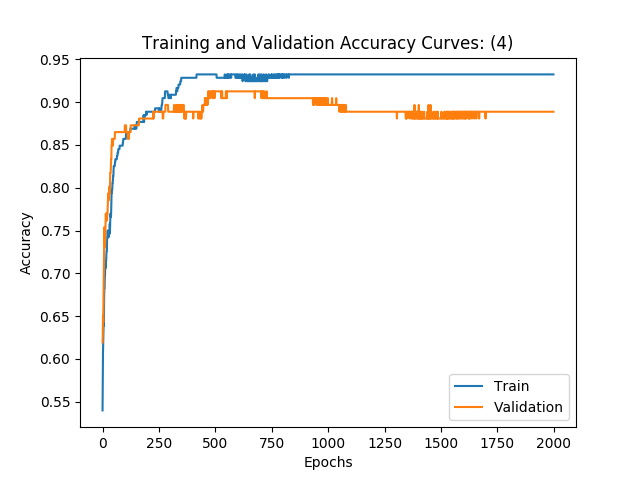

Matriz de confusão
[[1683  215]
 [   9   55]]

Train Loss:       0.0615
Validation Loss:  0.0878
Accuracy:         0.8858
MSE:              0.1142
AUROC:            0.9326


In [40]:
plot_training_error_curves(history, "(4)")
plot_training_acc_curves(history, "(4)")

## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="MSE:", value=mean_squared_error(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))